# nb-model_xg-model-neural-process-2

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath, exists
from pathlib import Path
from functools import partial
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_xg-model-neural-process-2.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
from verification.batch_norm import BatchNormVerificationCallback
from verification.batch_gradient import BatchGradientVerificationCallback

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, load_json, dump_json, load_df, str_now, makedir_if_not_exists, is_valid, isnt, compose, pd_split_ternary_to_binary, df_del_midx_level, midx_intersect, pd_get_midx_level, pd_rows, df_midx_restack
from model.common import ASSETS, DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TEST_RATIO, VAL_RATIO, EXPECTED_NUM_HOURS
from model.pl_xgdm import XGDataModule
from model.pl_np import NPModel
from model.np_util2 import AttentiveNP
from recon.viz import *
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_xg-model-neural-process-2.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Prune the xg data down to the data of interest to use in further experiments.

In [2]:
%autoreload 1
%aimport model.np_util2, model.train_util, model.pl_np, model.pl_generic, model.metrics_util, model.model_util

## Load Data

In [3]:
max_epochs = None
min_epochs = 20
model_name = 'anp'
asset_name = ASSETS[0]
fdata_name = 'h_pba_mzo,h_vol_mzo'
ldata_name = 'ddir'
model_type = 'reg'
monitor = 'val_accuracy' if (model_type=='clf') else 'val_mae'
num_classes = 2 if (model_type=='clf') else None

optimize_dir = {
    'val_loss': 'minimize'
}.get(monitor, 'maximize')

pl_model_fn, pt_model_fn = NPModel, AttentiveNP
model_name = f'{model_type}_{pl_model_fn.__name__}_{pt_model_fn.__name__}'
t_params = pl_model_fn.suggest_params(trial=None, num_classes=num_classes)
logging.getLogger("lightning").setLevel(logging.ERROR)
print('cuda status: {}'.format('✓' if (torch.cuda.is_available()) else '🞩'))

cuda status: ✓


In [4]:
t_params =  {
    'window_size': 10,
    'feat_dim': None,
    'train_shuffle': False,
    'epochs': 400,
    'batch_size': 256,
    'batch_step_size': 128,
    'context_size': 128,
    'train_context_in_target': False,
    'train_sample_context': False,
    'loss': model_type,
    'class_weights': None,
    'opt': {'name': 'adam', 'kwargs': {'lr': 1e-06}},
    'num_workers': 0,
    'pin_memory': True
}

In [5]:
fret=None
dm = XGDataModule(t_params, asset_name, fdata_name, ldata_name, fret=fret)
dm.prepare_data()
dm.setup()

In [6]:
dm.fobs

(6, 5, 80)

In [7]:
# tcn_sizes = [(31, 11), (6, 26), (5, 19), (27, 15)]
# tcn_depth = [(4, 2), (5, 3), (4, 4), (4, 3)]
# tcn_kernel_sizes = [(15, 47), (7, 39), (17, 47), (15, 15)]
# tcn_input_dropout = [(.01, .10), (0, 0), (.21, .63), (.77, .33)]
# tcn_output_dropout = [(.02, .45), (.15, .74), (.82, .69), (.64, .18)]
# tcn_global_dropout = [(.04, .35), (.08, .23), (.46, .47), (.13, 0)]

In [8]:
use_det_path = True

params_ffn = {
    'out_shapes': [100, 10],
    'act': 'relu',
    'init': 'xavier_uniform',
}

params_stcn = {
    'size': 4*5,
    'depth': 4,
    'kernel_sizes': 15,
    'input_dropout': 0.0,
    'output_dropout': 0.0,
    'global_dropout': 0.0,
    'global_dilation': True,
    'block_act': 'relu',
    'out_act': 'relu',
    'block_init': 'kaiming_uniform',
    'out_init': 'kaiming_uniform',
    'pad_mode': 'full'
}

m_params = {
    'ft_name': 'stcn', 'ft_params': params_stcn,
    'det_encoder_params': {
        'class_agg': False, 'rt_name': None, 'rt_params': params_ffn,
        'sa_depth': 1, 'sa_heads': 4, 'sa_dropout': 0.0,
        'xa_depth': 1, 'xa_heads': 4, 'xa_dropout': 0.0
    },
    'lat_encoder_params': {
        'latent_size': 1,
        'rt_name': None, 'rt_params': params_ffn,
        'dist_type': 'normal',
        'sa_depth': 1, 'sa_heads': 4, 'sa_dropout': 0.0,
        'min_std': .01, 'use_lvar': False
    },
    'decoder_params': {
        'de_name': 'ffn', 'de_params': params_ffn,
        'dist_type': 'normal',
        'min_std': .01, 'use_lvar': False
    },
    'use_det_path': use_det_path,
    'sample_latent': True,
    'use_lvar': False,
    'context_in_target': False,
    'label_size': num_classes-1 if (is_valid(num_classes)) else 1
}

In [9]:
mdl = pl_model_fn(pt_model_fn, m_params, t_params, dm.fobs)

rt_in_shape: (20, 1, 291)


In [10]:
mdl

NPModel(
  (model): AttentiveNP(
    (feat_transform): StackedTCN(
      (model): Sequential(
        (rb[conv2d]_0): ResidualBlock(
          (net): Sequential(
            (tl[(6, 5, 80)->(20, 1, 94)]_0_0): TemporalLayer2d(
              (layer): Sequential(
                (0): ReplicationPad2d((14, 14, 0, 0))
                (1): Conv2d(6, 20, kernel_size=(5, 15), stride=(1, 1))
                (2): ReLU()
                (3): Dropout(p=0.0, inplace=False)
              )
            )
            (tl[(20, 1, 94)->(20, 1, 122)]_0_1): TemporalLayer2d(
              (layer): Sequential(
                (0): ReplicationPad2d((28, 28, 0, 0))
                (1): Conv2d(20, 20, kernel_size=(1, 15), stride=(1, 1), dilation=(1, 2))
                (2): ReLU()
                (3): Dropout(p=0.0, inplace=False)
              )
            )
            (tl[(20, 1, 122)->(20, 1, 178)]_0_2): TemporalLayer2d(
              (layer): Sequential(
                (0): ReplicationPad2d((56, 56, 0, 

## Neural Process

In [11]:
trial_time = str_now().replace(' ', '_').replace(':', '-')
study_dir = MODEL_DIR +sep.join(['log', model_name, asset_name, dm.name]) +sep
makedir_if_not_exists(study_dir)
trial_dir = f'{study_dir}{trial_time}{sep}'

csv_log = pl.loggers.csv_logs.CSVLogger(trial_dir, name='', version='')
tb_log = pl.loggers.tensorboard.TensorBoardLogger(trial_dir, name='', \
    version='', log_graph=False)
chk_callback = pl.callbacks.ModelCheckpoint(f'{trial_dir}chk{sep}', \
    monitor=monitor, mode=optimize_dir[:3])
#es_callback = EarlyStopping(monitor=monitor, min_delta=0.00, patience=30, verbose=False, mode='min')
#ver_callbacks = (BatchNormVerificationCallback(), \
                #BatchGradientVerificationCallback())
ver_callbacks = ()

trainer = pl.Trainer(max_epochs=max_epochs or t_params['epochs'],
			min_epochs=min_epochs, logger=[csv_log, tb_log],
			callbacks=[chk_callback, *ver_callbacks],
			limit_val_batches=1.0, gradient_clip_val=0., #track_grad_norm=2,
			auto_lr_find=False, amp_level='O1', precision=16,
			default_root_dir=trial_dir, weights_summary=None,
			gpus=-1 if (torch.cuda.is_available()) else None)

In [12]:
trainer.fit(mdl, datamodule=dm)

/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

val pred
tensor([ 2.1865,  2.2988, -0.5021,  1.4903,  2.1128,  1.2439, -0.3747, -1.0912,
         0.8682,  0.8008], device='cuda:0')
val pred
tensor([-0.4041, -0.4201,  0.2100,  1.7043,  2.3210,  0.7895,  0.8696, -0.8449,
         1.0576,  1.5849], device='cuda:0')


/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

train pred
tensor([-1.4817,  1.5985,  2.5622, -0.2000,  1.0249,  2.0374,  1.0739, -1.1124,
         1.8517,  1.9666], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3580,  0.6446, -0.1643,  0.8349,  2.3019,  0.6055, -0.0770,  0.7348,
         0.6422,  0.8808], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6842,  2.2359,  1.0430, -0.6173,  1.0388,  0.8452,  1.6954, -0.3073,
         2.7174,  1.2656], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([2.5407, 1.7213, 0.7353, 1.2826, 0.5952, 0.6314, 0.3998, 0.6889, 0.0314,
        0.8551], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4131,  1.5620,  1.4974, -0.7217,  0.3543,  1.0159,  3.0267, -0.2636,
         2.4678, -1.1701], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6060,  1.0173, -1.1229,  1.1140,  1.7552,  0.3818, -0.3821,  0.4310,
         1.2283,  0.5885], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.8660,  1.3969,  0.8445,  2.0

Validating: 0it [00:00, ?it/s]

val pred
tensor([2.5864, 0.2101, 0.6267, 1.2161, 1.0712, 0.1098, 0.0316, 1.4966, 2.1027,
        1.0886], device='cuda:0')
val pred
tensor([-1.1943,  0.1989,  3.0653,  0.8657,  0.1347,  1.0349,  0.8305,  0.0687,
         0.7657, -1.5296], device='cuda:0')
val pred
tensor([ 0.3610, -0.8698,  0.4780,  0.8853,  1.7191,  1.4320,  1.4972,  1.9791,
         1.7876,  0.6420], device='cuda:0')
train pred
tensor([-0.0367,  1.1980, -0.5688,  2.8819, -1.3610,  0.2575,  2.7334,  1.2835,
         1.9483,  3.6039], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.2617, -0.2599,  1.0005,  0.5985, -0.7096,  0.9485, -1.0892, -1.2700,
         0.9959,  0.0288], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.6087, -0.1893, -0.5081,  0.9676,  0.5491,  1.1886,  2.9555,  1.4456,
         0.8990, -2.1605], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1197,  1.4436,  1.1263,  1.3602,  1.4725,  0.7674,  1.9472,  1.1741,
         0.0696, -1.3079], device='cuda:

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4774,  0.5146,  0.3459,  0.6950,  2.1209,  0.5175, -0.7546,  2.1076,
         1.6961,  2.3642], device='cuda:0')
val pred
tensor([ 2.7574,  1.8446,  0.4361,  0.1972,  1.7992, -0.2807,  2.2226,  0.1713,
         1.8390, -0.6415], device='cuda:0')
val pred
tensor([ 0.9564, -0.8249,  0.7345, -0.5235, -1.3311,  0.8399,  1.8821,  2.2011,
        -0.8588, -0.2619], device='cuda:0')
train pred
tensor([-0.6530,  1.3153, -1.3044, -0.2793,  1.2302, -0.3748,  1.2041,  1.0513,
         2.9729, -0.0993], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.9044,  2.7141,  2.3253,  2.7035, -0.4833,  0.2725, -0.8497,  1.8454,
         3.1205, -0.4998], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0978,  0.0856, -1.0224,  3.1678,  0.6735,  1.8131,  3.0348, -0.4987,
        -1.3858,  2.9527], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3758,  2.0791,  3.2367,  1.5445,  0.4267, -1.3472, -0.1803,  1.0991,
         0.8889,  0.5834], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.1022,  0.6604,  1.0733,  1.1555,  0.5443,  0.4625, -1.4202,  0.4006,
        -0.0813, -1.0144], device='cuda:0')
val pred
tensor([ 0.9061,  0.7688, -0.1029,  0.7395,  0.2349,  0.3433,  0.1963,  0.2677,
         0.7814, -1.2686], device='cuda:0')
val pred
tensor([-0.1758,  0.5658,  2.4709,  0.6234,  0.2657, -0.5364, -0.4629,  0.0890,
        -0.6664,  1.6144], device='cuda:0')
train pred
tensor([-0.4675, -0.1328,  1.3407,  1.2430,  0.2262,  0.2526,  1.4731, -0.4242,
        -0.5665,  2.6365], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4034, -0.7961, -1.2693,  0.6117, -0.7196, -0.3518,  0.8621,  2.7602,
         0.9931,  0.6780], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1518,  1.2423, -1.2503,  1.7859,  1.8574, -0.3063, -0.6224,  1.1198,
        -0.2755, -0.2916], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4308e+00,  1.1724e+00,  1.3548e+00,  1.4575e+00,  2.4979e-01,
         1.7668e+00,  1.4025e+00,  3.

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.2423,  0.0618,  1.9384,  0.5925, -0.6338,  1.5261, -1.0601, -0.4950,
         0.2712,  0.1344], device='cuda:0')
val pred
tensor([ 1.6086, -0.1543, -0.2791,  1.7119,  0.4313,  2.2724,  0.3752,  0.7674,
         1.0817, -2.8064], device='cuda:0')
val pred
tensor([ 0.5205,  2.6129,  0.9269, -0.5696,  1.8705,  0.5464,  2.6326,  2.0310,
         2.5125, -0.7205], device='cuda:0')
train pred
tensor([ 1.3546,  2.2096,  0.1249, -0.0639,  2.1570,  1.3549,  0.7954,  0.4991,
         1.7992,  0.0828], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0267,  0.0834,  2.1707,  0.3917,  1.9448, -0.2800,  1.5482, -0.7002,
        -0.1277, -0.4906], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5397, -2.2719,  1.5425,  1.4478, -1.1863,  0.8764,  3.0544, -0.7644,
         0.9853, -0.3424], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0908,  0.5819,  0.6084,  0.0513,  2.4687,  0.1761,  0.3180,  0.4969,
         0.0459,  1.5187], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0035,  2.1944,  2.0545,  0.9608,  0.1883,  1.9886, -1.1294,  0.6311,
         1.6076,  0.3687], device='cuda:0')
val pred
tensor([-1.0261,  2.4464,  2.0628,  2.4910,  1.2796,  0.1321, -0.8686,  2.7753,
         2.8135, -0.4433], device='cuda:0')
val pred
tensor([ 0.4190, -0.4427,  0.1592, -0.5056,  2.6615, -0.3098,  0.1375, -0.0354,
         2.4068,  0.0849], device='cuda:0')
train pred
tensor([-1.4802,  1.8620, -0.0423,  2.3034, -0.3433,  1.5312,  3.9342,  0.4931,
         1.5992,  0.5847], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1518,  0.4395,  2.3269,  1.5905, -0.4281,  0.0031,  0.7993,  0.2079,
        -0.3711, -0.7347], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5499,  0.5048,  0.7717, -0.2098, -0.3021, -1.4094,  2.1952, -0.3644,
        -0.7966,  1.9309], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3484,  0.5930,  1.3814, -0.7252, -0.9862,  1.0615,  0.5400,  0.2684,
         1.6758,  0.0711], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.7270, -0.4227,  0.8269,  0.2731,  1.2970, -0.6674,  0.5809,  1.2107,
        -0.1230,  0.2616], device='cuda:0')
val pred
tensor([ 1.0197,  0.8041,  0.3870,  1.1711,  0.6643, -0.3875,  0.8174, -0.9922,
         1.0506,  1.5718], device='cuda:0')
val pred
tensor([-0.2017,  3.8085,  0.2013,  2.0061,  0.7976, -0.7873,  1.1964,  2.1023,
        -0.4533, -1.7466], device='cuda:0')
train pred
tensor([ 2.4231, -0.3050,  1.9120,  0.3034,  0.8604,  2.2808,  0.4315, -1.4898,
        -0.2069, -1.3215], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4381, -2.2040,  1.8807,  1.5193,  0.6320,  1.5771,  0.1493, -0.1105,
         2.9433,  0.3278], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3201,  3.3161,  1.7715,  0.5825, -0.2119,  0.0663,  1.2108, -0.9843,
        -1.2275,  0.8954], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6434,  1.8592,  2.5182, -0.8486, -0.2159,  0.7394,  0.5321,  2.0526,
         0.6830, -1.8016], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.8421,  0.2870,  1.2087, -0.7339,  1.2012,  1.7418,  0.3375,  3.2652,
         0.3451,  1.7118], device='cuda:0')
val pred
tensor([-0.7845, -0.9764, -1.2454,  1.8557,  1.6262, -0.2475,  1.9542, -0.2384,
        -0.0911, -1.1242], device='cuda:0')
val pred
tensor([ 2.5365, -1.2151, -1.1265,  0.7107,  0.7798,  0.7054, -0.5184,  0.5150,
        -0.2601,  1.8619], device='cuda:0')
train pred
tensor([-0.3026,  0.6574,  0.4037,  0.8160,  1.0888, -1.0656, -0.0506, -1.0402,
         0.6954,  0.8713], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 2.4295,  2.2430, -0.7119,  0.8967,  0.8762,  1.3122,  0.5843, -1.6375,
         1.1548,  1.6947], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2695,  0.0191,  2.3710,  0.1244, -1.2610, -1.9489,  1.2895, -0.2910,
         0.5494,  1.2460], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9174, -0.8187,  0.3785,  0.9052,  0.7003,  0.8935, -0.2693, -1.3236,
         0.0573,  0.9312], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5030,  1.2825,  1.5202,  1.4821,  0.3854,  1.7753, -1.2014,  1.3499,
         0.0786,  1.4196], device='cuda:0')
val pred
tensor([ 0.3676,  0.0322,  0.7191, -0.5148,  0.8147,  0.5067,  1.3291,  0.4935,
         0.3941,  2.3169], device='cuda:0')
val pred
tensor([ 0.9382, -2.0839,  0.3284,  0.6601,  0.0939, -0.6138,  0.9028,  1.2935,
         1.5033,  0.8534], device='cuda:0')
train pred
tensor([-0.7015,  1.6696,  1.7348, -1.7881, -0.4096,  1.7505,  0.9546,  0.9944,
         0.2071,  0.5101], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 2.1266, -2.9988,  0.7258,  0.6050,  0.3748, -0.1220,  1.8298,  2.5770,
         0.1583, -1.0425], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8350, -1.4459,  1.3753,  1.6672, -0.1543, -0.1784,  0.1571,  0.5398,
        -0.8117,  0.7760], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1533,  0.4894,  1.6603,  2.2352,  1.0629, -0.1477, -0.0764,  0.7051,
         0.2268,  0.8780], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.2758, -0.7262,  1.2217,  0.3985,  2.4691,  0.5908,  0.4409,  0.2480,
         1.6814,  0.1023], device='cuda:0')
val pred
tensor([-0.4422, -0.0303,  0.4482,  0.3342,  1.5510,  1.6001,  0.6429,  1.1061,
        -0.9205,  0.2034], device='cuda:0')
val pred
tensor([ 1.1710,  1.4685,  1.8111,  0.1844, -0.9374,  0.5315,  0.2070,  0.1554,
        -0.8457,  0.5448], device='cuda:0')
train pred
tensor([ 0.3608, -0.3204,  1.7192, -1.0131, -0.4718,  0.7100, -0.4354, -0.2069,
        -1.4320,  1.6129], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6755,  0.0879,  1.0589, -0.9456, -0.9261,  1.0097,  2.7125, -0.3119,
         0.7458,  0.1622], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0483,  1.2677,  1.0728,  0.1236,  0.4532,  0.5473, -0.4747,  1.1899,
         0.9822,  2.1848], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7273,  0.4899,  0.8158, -1.6418,  1.4920,  0.3607,  1.3499,  1.7757,
         0.2998,  0.7840], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4732,  0.2753, -0.3484,  0.0555,  0.7509,  0.4725,  1.2605,  1.7891,
         1.5703,  0.1019], device='cuda:0')
val pred
tensor([ 0.5726, -0.2534, -0.6849, -0.9271, -0.5794,  2.0326,  1.8087, -0.1252,
        -1.0334, -0.1339], device='cuda:0')
val pred
tensor([ 1.0789, -0.3206,  0.1948, -0.9887,  1.4136,  1.2489, -0.8161,  1.7549,
         2.0308,  1.3267], device='cuda:0')
train pred
tensor([-1.0932,  2.0479,  0.0380,  0.3594,  1.7703,  1.1183,  0.2658,  1.2648,
         0.7047,  1.5404], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5905,  1.7545, -0.1602,  1.6427,  0.6553,  1.6542, -0.8294, -0.1176,
         0.2881,  0.0590], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.8238,  2.7556,  0.2310,  1.4369,  0.6886,  1.1110,  2.1280, -0.1405,
         1.8762, -0.7135], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.2072, -0.6911,  2.0696,  2.2149, -0.5477,  1.8104, -0.4468, -0.4726,
         0.3892,  0.6872], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0587,  2.2647,  2.2430,  0.9474, -0.0363,  0.7242,  1.7562,  0.1131,
         0.7166,  0.1694], device='cuda:0')
val pred
tensor([ 2.2091,  0.9048,  3.8124,  0.8074, -0.4232,  1.1396,  1.5452,  1.0289,
        -0.0474, -0.4588], device='cuda:0')
val pred
tensor([-0.6448, -1.4522,  0.1977, -0.5047,  0.9950, -1.0488,  0.6710, -2.0180,
         0.2849,  0.5672], device='cuda:0')
train pred
tensor([-1.2707,  2.5407,  0.3178,  1.5824,  0.3974,  0.0772,  0.0036,  0.8065,
         1.0697, -0.3965], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8826, -0.6909,  1.4334, -0.7247, -0.9824,  1.8962, -0.0467,  1.0124,
         0.1773,  1.3233], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 2.1187,  1.7592,  0.8193, -0.3516,  0.0517,  1.4749,  0.8066,  0.9737,
         0.6446,  2.1885], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.5391,  0.2080, -1.3912,  2.1039,  0.6426,  0.9800,  2.0655, -0.2924,
         1.9253,  0.2791], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1767,  1.9352, -0.1855,  1.4963,  0.3903, -0.9100,  0.5769,  1.0892,
         0.8928,  1.9045], device='cuda:0')
val pred
tensor([ 0.9821,  1.3526,  2.2754, -0.3437,  0.5304,  1.1705,  1.0657, -0.7903,
         0.5087,  1.5379], device='cuda:0')
val pred
tensor([ 0.6131,  2.4659,  0.6457,  0.3807,  1.1458, -0.0659,  1.7255, -0.8555,
        -0.3536,  1.7524], device='cuda:0')
train pred
tensor([ 2.7419,  1.3854,  1.6541,  0.2261,  1.3566, -1.7689,  0.0731, -0.2149,
         1.2182,  1.4047], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5430,  1.2779, -0.7312,  0.5211, -1.3836, -0.0110,  0.0407, -0.9621,
        -0.5941,  1.1521], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2024,  2.0794,  1.7670,  0.0470, -0.7113,  2.4106,  0.8903,  0.4637,
         1.2076,  2.6549], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2568,  1.0368, -0.4610, -1.0494,  1.5604, -0.5018,  1.3635,  2.3103,
        -1.9128,  0.6006], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6399,  0.8816,  0.7181,  0.6069,  0.4324, -0.3837, -0.2976,  0.5291,
         1.7294,  0.3460], device='cuda:0')
val pred
tensor([-0.5468, -0.1261, -1.3565, -0.2026,  1.0146,  0.6707,  0.4090,  1.2316,
         1.0441,  1.0335], device='cuda:0')
val pred
tensor([-0.1614, -1.1019, -0.4307, -0.9536,  0.3940,  1.1507, -1.1221, -1.1282,
         0.6033, -0.9225], device='cuda:0')
train pred
tensor([ 0.9567,  1.8379,  0.7204,  0.4598, -0.7220,  1.5479,  0.3726,  2.1188,
         0.2285,  0.0741], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 2.3832,  0.7901,  0.1676, -0.3298,  0.3010, -0.3476,  0.6764,  1.8487,
         1.4067,  1.2475], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0965, -0.7220,  1.2270,  0.5381,  0.1275, -0.1886,  1.9687,  0.5919,
         0.8172,  0.1589], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4997, -0.3010,  1.2017,  2.3276, -0.2199,  1.0442,  1.1594,  0.9124,
         1.1037,  0.8520], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.0911,  1.1713,  0.2706, -0.3593, -1.1214,  0.1105,  1.4680,  1.0183,
        -0.3138,  0.6877], device='cuda:0')
val pred
tensor([ 0.8642,  1.2863,  1.2549,  1.0293,  0.5146,  0.0112,  0.0348,  1.0935,
        -0.7248,  2.5193], device='cuda:0')
val pred
tensor([ 0.0441,  0.9209, -1.6971,  0.1463,  0.0328,  0.2670,  1.1354,  0.4967,
         1.6025,  1.6276], device='cuda:0')
train pred
tensor([ 0.4777,  1.0580,  0.5078, -0.2783,  0.3796,  1.4734,  1.8492, -0.4138,
        -0.3962, -0.2358], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3791,  1.0652,  2.0572,  1.6564,  0.6623, -0.2892,  0.7498,  1.4071,
        -0.4122,  1.5293], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0215, -0.6814, -0.0045,  0.4094,  0.3811, -1.0706,  2.7940,  0.2943,
         1.2393, -1.4288], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.0092,  0.0889, -1.1263,  1.0778,  0.1598,  0.6936,  1.2855, -1.1353,
         0.5300, -0.1389], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0220,  0.1665,  0.3944,  1.1904,  0.6769,  0.2988,  1.3407,  1.5080,
         1.1865,  0.4738], device='cuda:0')
val pred
tensor([ 0.6846,  1.6479,  0.5492,  0.5952, -0.3043,  1.1648, -0.0553, -0.2467,
         0.5229,  0.3233], device='cuda:0')
val pred
tensor([-1.1876,  0.1773, -0.2671,  1.2502, -1.3482,  0.3844, -0.0103, -0.2680,
         0.6788, -2.4772], device='cuda:0')
train pred
tensor([-1.2213,  1.1799,  0.3962,  1.8141,  0.8193,  1.0602, -0.6845,  1.3531,
        -0.8250, -1.6719], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8817,  1.8760,  1.6769,  2.0849,  0.8684, -0.4472, -1.5918, -0.4137,
         2.8026, -1.8629], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0736,  0.9065,  0.3711, -0.1691, -1.0073,  0.3018,  2.3886,  2.0944,
        -0.6907, -0.0956], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.7381, -0.1869, -0.3307, -1.2207, -1.9501, -0.6829, -0.2212,  1.0193,
        -0.6180,  0.2393], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.7001, -0.6805,  0.1266,  0.0519,  2.9786, -0.7478,  0.9196,  0.8084,
        -1.4757,  0.6725], device='cuda:0')
val pred
tensor([1.3391, 1.2268, 1.7569, 1.6829, 1.8871, 0.0401, 1.0498, 0.3805, 0.0953,
        1.4165], device='cuda:0')
val pred
tensor([ 0.1704,  0.3547,  1.9285,  0.4228,  1.2843,  0.5097,  1.9338,  0.7219,
         0.7136, -1.0302], device='cuda:0')
train pred
tensor([ 0.9660, -0.0439,  1.1515,  0.5274,  0.9896, -1.2795,  0.9266,  0.8366,
        -0.1323,  0.1346], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2213,  1.1517,  0.8994,  0.7322, -0.3304, -0.2937,  0.9948, -0.3282,
         0.5615,  0.1014], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0083, -0.5005,  1.4053,  0.8514,  0.7796, -0.0350, -0.2684,  0.6273,
        -0.2136,  0.8457], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4077,  1.1928,  1.3752,  0.5331, -0.8771,  1.3906,  0.5821, -0.7449,
        -0.9776, -0.4443], device='cuda:

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.0597,  0.0665,  0.9223, -1.0215,  0.4449,  1.0650,  0.1189,  0.4619,
         0.6008,  0.0206], device='cuda:0')
val pred
tensor([-0.7228, -0.5309, -0.3680,  0.9870,  1.3335,  0.3117,  2.4919,  0.2528,
         0.5137,  0.7383], device='cuda:0')
val pred
tensor([ 0.4327,  0.1045,  0.9641,  1.6501,  2.0802,  0.7887, -0.1742,  1.2773,
         0.5863,  1.1123], device='cuda:0')
train pred
tensor([ 1.2140,  0.7425,  0.8849, -0.2819,  1.8542,  0.0100, -0.6401,  1.2942,
         0.9556, -1.0878], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9893, -1.4192,  1.0703,  0.6406,  0.9628, -0.1263, -0.6344, -0.3850,
         0.6578, -0.7312], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6474,  0.2136, -1.0694, -1.0097,  1.4079,  0.6745, -0.8305,  0.8568,
         1.1513,  0.2313], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([0.3529, 0.4385, 0.4638, 2.0076, 0.3614, 1.3042, 1.6431, 2.6329, 1.2939,
        0.9779], device='cuda:

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.4922,  0.5885,  0.2262,  1.3015, -0.1113, -0.9769,  1.7198, -0.3891,
        -0.0620,  0.3237], device='cuda:0')
val pred
tensor([-0.3982, -0.4626,  2.0173,  0.8899, -1.3080,  0.7377,  1.7635, -0.3590,
         1.0095,  0.1605], device='cuda:0')
val pred
tensor([ 0.4079, -0.8974,  1.5125,  1.1556,  0.5745, -1.4646,  0.4949,  0.0507,
        -0.7724, -0.6332], device='cuda:0')
train pred
tensor([-0.8933,  1.8536, -0.5425,  0.9325, -0.1729, -0.1275,  0.8151,  0.0617,
         0.0740,  0.3539], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([0.8552, 0.1065, 0.6366, 1.2840, 0.0806, 0.5332, 1.4003, 0.1498, 1.2338,
        0.1210], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4216,  1.2622,  0.3019,  0.5037, -0.0181, -2.9608, -0.0525,  1.6711,
        -0.6825,  0.1194], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4871,  0.1851, -1.3418,  0.0713,  0.1758,  0.8450,  0.6721,  0.5720,
         1.7039,  1.5343], device='cuda:

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1592,  1.7336,  0.3556,  0.9475, -0.1791,  0.2958,  0.7153, -1.6024,
         0.3546,  0.4788], device='cuda:0')
val pred
tensor([ 0.3383,  1.0219,  3.2510, -0.7504,  2.7127, -0.5918, -1.8435,  1.3650,
         0.4810,  0.9410], device='cuda:0')
val pred
tensor([-1.1732, -1.0193,  0.2856,  1.4123,  0.7680,  0.4114, -0.9361,  1.2634,
        -0.6447,  1.2874], device='cuda:0')
train pred
tensor([ 0.4236,  0.5321,  1.2471, -1.1719,  0.3211,  1.4605,  0.9988, -0.3355,
        -0.3955, -0.5223], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7688, -0.0482,  0.2318, -0.4657,  2.2470,  0.3407, -0.7449,  1.3204,
         3.0066,  0.8590], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3578, -0.2502,  0.8476, -0.3826,  0.3717,  1.1108,  0.8998,  0.1519,
        -0.7544,  0.7967], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5942, -1.0699,  1.9622, -0.1404,  1.5067, -0.5674,  1.7559, -0.1607,
         0.7716,  1.6850], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.7314,  1.5107,  0.1141, -0.8976,  1.0100,  0.2184,  0.9164,  0.7980,
        -0.1793,  0.0536], device='cuda:0')
val pred
tensor([ 0.7838,  0.2640,  0.9938,  1.8212,  0.6928, -1.3283,  0.3295,  0.7179,
         0.7063,  1.1255], device='cuda:0')
val pred
tensor([ 0.0902, -0.0915,  0.0878, -0.0600, -0.5351,  0.9918,  0.0346, -0.0498,
         0.1441,  0.3425], device='cuda:0')
train pred
tensor([ 1.4433,  0.3568,  0.2114,  0.0741, -0.8093,  0.9301, -0.7937,  0.6556,
         1.3199, -0.3146], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3368,  0.6576,  1.4337, -0.5122,  1.3497, -0.3965,  0.3106,  1.0362,
         0.3714,  0.0153], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6800, -0.7082,  0.1287,  0.2412,  0.7671, -0.1552,  3.5862, -0.9202,
         0.3560,  0.3780], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5454,  0.4987,  2.1585,  0.8367, -0.1418,  1.3018,  2.6273,  1.3230,
         0.0533, -1.1787], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2484,  1.4782,  1.6890, -1.0628, -0.1273,  1.2105,  0.2918,  0.4611,
         0.5704, -0.1282], device='cuda:0')
val pred
tensor([ 0.8137,  1.2844,  1.0791, -0.5056,  1.4783, -0.0151,  0.7817,  1.0211,
         0.7893, -0.3947], device='cuda:0')
val pred
tensor([-0.8391, -1.9472, -0.1754, -0.4004,  1.5152,  0.4831,  0.7665, -0.3301,
         0.7689, -0.7824], device='cuda:0')
train pred
tensor([ 1.3488, -0.2294,  0.8125,  1.9521, -0.0707,  0.8042, -0.1164,  0.6817,
         1.0931,  0.1321], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6183,  1.1371,  1.1131,  1.2855, -0.3057,  0.2698, -0.0991,  1.4249,
        -1.1045, -0.5468], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9244,  0.3080, -0.7860,  0.8049,  0.4414,  0.1786,  0.9411, -0.7371,
        -0.2738,  0.1833], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.7348, -0.1748,  0.9116,  1.5758,  0.2924, -0.2233, -0.9351, -0.3231,
         1.0313,  1.8822], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.9455,  0.0542,  1.2395, -0.5931, -0.0200,  1.1735,  0.3152,  1.1340,
         1.1630, -0.4477], device='cuda:0')
val pred
tensor([-0.9352, -0.6578,  1.6824, -0.5616,  0.9764, -0.1211, -0.8116, -0.0055,
         0.3128, -1.5839], device='cuda:0')
val pred
tensor([ 0.7128,  1.5819,  0.0941, -1.1307, -1.2746,  1.0484,  1.5959,  1.2446,
         0.5946, -0.6186], device='cuda:0')
train pred
tensor([ 0.3606, -0.6542,  2.2822,  0.4072, -0.5255, -0.8202, -0.1512, -1.2638,
         0.6801,  0.0730], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4657,  0.6913, -0.1776,  0.9620, -0.3522,  0.8729,  0.1432,  0.9022,
         0.2062,  1.1142], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9508, -0.0897,  0.9657,  0.1609, -0.1564,  0.4235,  0.7496,  0.1430,
         0.3703,  1.4087], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8077,  1.8107, -0.1810, -0.1401,  0.7979,  1.7716, -0.9467, -0.1201,
         0.5688, -0.5644], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1178,  0.3726, -0.5990, -0.0825,  0.2226, -0.3339, -1.0212,  0.8970,
         0.5910,  0.2191], device='cuda:0')
val pred
tensor([ 0.1312,  0.2921, -0.2824,  0.4754,  0.1766, -1.1680,  1.2175, -0.1778,
         0.0571,  1.8657], device='cuda:0')
val pred
tensor([ 3.0708,  0.9774,  1.5637, -0.0670,  0.4261,  1.7705, -0.7811,  1.0543,
         0.2795,  0.2427], device='cuda:0')
train pred
tensor([ 0.6659,  1.3012,  0.3648,  0.1281,  1.4845,  2.1421,  0.6341,  1.6066,
        -0.6089,  0.4213], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5822, -0.8017,  1.3032, -0.2015,  0.8820,  0.4329,  0.5604,  1.4130,
         0.2398,  0.8612], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1522,  1.2674, -1.1029,  2.1244, -1.4938,  0.8904, -0.6101,  0.3819,
         1.1456,  0.2974], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4731,  1.3248,  0.4048,  2.0213, -1.2123, -0.7427, -0.4526,  1.0142,
         0.0260,  0.8867], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.2426,  1.8540, -0.8501,  0.5867,  0.1388, -0.1541, -0.0749, -0.3698,
        -0.7010,  0.0929], device='cuda:0')
val pred
tensor([1.7921, 0.3842, 1.4156, 2.1387, 1.2792, 0.0501, 0.4762, 1.1902, 0.1636,
        1.9846], device='cuda:0')
val pred
tensor([-0.8765, -1.0523, -0.5946, -0.2385,  0.8190,  0.7094,  1.4424,  0.9507,
        -1.3157, -0.1815], device='cuda:0')
train pred
tensor([ 0.6968, -1.1793, -0.1289,  1.4699,  1.0132, -0.8688,  0.8959, -0.4262,
        -1.9305,  0.5435], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.2536,  0.3340,  1.5150, -0.9647, -0.4853,  0.6315,  0.2978, -0.7554,
         1.6107, -1.0160], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8141,  0.3004,  0.1167,  0.1624,  0.5203,  0.7467, -0.8523,  0.6274,
         0.0778,  0.7458], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8672,  0.0207,  0.2919,  0.1403,  0.5784,  1.1122, -0.0305, -0.8360,
        -0.7452,  0.0931], device='cuda:

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.1248,  0.2639, -0.3790, -0.2185,  1.3954,  1.7868,  0.1414,  0.7906,
         0.6085,  0.1655], device='cuda:0')
val pred
tensor([ 0.5846, -1.8639,  1.2829,  1.0124,  0.1834,  0.8976, -0.5362, -0.5975,
         0.0742, -0.3517], device='cuda:0')
val pred
tensor([ 0.2054,  0.6058,  0.5858,  0.5881, -0.2960,  1.8561,  0.0070,  1.1884,
         1.7623, -2.4928], device='cuda:0')
train pred
tensor([ 1.6228,  0.1451,  1.0780,  1.4333,  1.1253, -0.7063, -0.0593, -0.9994,
         0.9427,  0.6392], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1087,  1.3277, -0.5543,  1.5295, -0.0182,  0.9301, -1.0219,  0.3609,
         0.5279,  0.5639], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.6064, -0.1286,  0.1079,  1.4020,  0.4443,  1.6748,  1.5414, -1.2344,
        -0.4925,  0.3587], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7730,  0.7880,  2.1216, -0.5077, -0.2585,  0.4884,  0.3250, -0.5795,
         0.6661,  0.7870], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3434,  0.4640, -0.3539, -0.2958,  0.6407,  1.6379, -0.7434, -0.0902,
         0.2482,  0.3475], device='cuda:0')
val pred
tensor([ 0.3259,  0.5944, -0.0309, -0.7250,  1.5883,  1.0587, -0.2631, -0.1463,
         0.2327,  1.1884], device='cuda:0')
val pred
tensor([ 1.5856,  1.2654,  0.3433, -0.5897,  0.8614,  1.0875,  1.5145,  1.1177,
         0.6341,  0.6644], device='cuda:0')
train pred
tensor([-0.8550, -0.3833,  1.3718, -0.1749, -0.6463,  0.4058, -0.2944,  0.4144,
        -0.1064,  0.2580], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0975,  0.9499,  1.1937,  1.1551,  0.4581, -0.0217,  0.4248, -0.0378,
         0.1084,  1.5493], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8535,  1.3409, -0.0048,  0.3096, -0.5246,  0.8967,  1.7297, -0.3189,
        -0.7856,  0.9109], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1081, -0.6141, -0.4186,  0.2350, -0.0350, -0.5539,  0.1323,  2.2266,
         1.2642, -1.0276], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5142, -1.6773, -0.2502,  0.2718,  0.3788,  0.3613, -1.0221,  0.6733,
         0.6960,  1.5290], device='cuda:0')
val pred
tensor([ 0.1656,  0.3764,  1.2230,  0.7235,  0.5490, -0.4047,  0.7665,  0.4587,
         0.5332,  0.1966], device='cuda:0')
val pred
tensor([ 0.7147, -0.0231,  0.8558,  0.8774, -0.3853,  1.2571,  1.0501,  0.0620,
         1.4474,  0.7386], device='cuda:0')
train pred
tensor([ 1.7256,  0.8293, -0.0709,  0.6604,  1.4529, -0.6651,  0.4790,  0.2312,
        -0.6608, -0.3543], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4966, -1.2189,  1.2288, -0.1319,  1.0375, -0.4344,  1.1567,  0.1151,
        -0.0802, -0.4418], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.6687, -0.9064,  1.0269, -0.5495,  0.8196, -0.9743,  0.4960,  0.2827,
         0.3042,  1.5073], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.4257,  1.4567,  1.2965,  1.2987,  1.5885,  1.1282,  2.1599, -0.7851,
        -0.1449,  0.1617], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.7132, -0.0703,  0.2134, -0.1873, -0.5233,  0.0367,  1.2833, -1.0350,
        -1.0771,  0.9050], device='cuda:0')
val pred
tensor([ 2.1174,  0.6406, -0.8714, -0.7114,  0.7635, -0.3151,  0.6845, -0.3421,
        -0.3176, -0.2908], device='cuda:0')
val pred
tensor([-0.1713,  0.7547,  0.1433,  0.3727,  1.3106, -0.7227, -1.2407, -0.4029,
        -0.6772, -0.3214], device='cuda:0')
train pred
tensor([ 0.5737, -0.9567,  0.6935, -0.0667,  0.3236, -0.1538,  0.1900,  0.7086,
        -0.4759,  0.8891], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6877, -0.3922,  1.4349, -0.0471,  1.0191, -0.8894, -0.3177, -0.4311,
         0.3448,  1.2597], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.0932,  0.8442, -0.8517, -0.0430,  0.5910, -0.0185,  1.8630,  2.1041,
         1.9925,  0.5493], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.0490,  0.7415,  0.7775, -0.1705, -0.0862, -0.5117,  0.2667, -0.5262,
         0.6837,  0.4733], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.5864,  1.1306,  0.3044,  1.7961, -0.1665, -0.5892,  1.5938,  1.1537,
        -0.2928,  0.4513], device='cuda:0')
val pred
tensor([ 0.2620, -0.6177,  0.9833, -0.2489,  1.4703,  0.7249,  0.7239, -0.2915,
        -0.0619,  0.4194], device='cuda:0')
val pred
tensor([ 1.1865,  1.3555, -0.1392, -0.7668, -0.4703, -0.2901,  1.1190,  0.1148,
        -0.1663,  0.6140], device='cuda:0')
train pred
tensor([ 1.1061, -0.9819,  1.9516,  0.3093,  1.2590,  0.0793,  0.8727,  0.2173,
        -0.4577, -0.9167], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 8.4711e-01,  1.1997e-03,  1.1915e+00,  6.3863e-01, -1.6562e-01,
         9.1103e-01, -1.3462e+00, -1.1369e+00,  1.7515e+00, -2.6861e-01],
       device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3324, -0.2985,  0.5505,  0.0089, -0.1906,  0.6797,  0.8271, -0.0916,
         1.3456,  1.3366], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8615,  0.2983, -0.1580, -1.5897,  0.4862, -0.6678, -

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.7031,  0.3783,  0.1877, -0.2406,  0.0051,  1.3866,  0.2058,  0.3810,
         1.2863, -0.2172], device='cuda:0')
val pred
tensor([ 0.9930, -0.8020,  0.4832, -0.3113,  0.5775,  0.4788, -0.6882,  1.4969,
        -0.5529,  1.2275], device='cuda:0')
val pred
tensor([ 0.0451,  0.6460,  0.0232, -0.2406,  0.5142, -0.4111,  0.1724,  0.5040,
         1.2666,  1.2135], device='cuda:0')
train pred
tensor([-0.7384, -1.5917, -0.9711,  0.3885,  1.1948,  0.9269,  1.0590, -0.0617,
         0.5708, -0.1123], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3951,  1.0257, -0.4043, -1.6729,  0.0264, -0.5947, -0.1954,  0.2340,
        -0.2750,  1.2840], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0282,  1.0773,  0.9534,  1.3084, -0.1999,  1.1580,  0.5225, -0.5717,
        -0.1467,  0.2208], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7861,  0.1261,  0.8073,  1.2122, -0.6017, -0.1079,  0.0024,  0.1194,
        -0.6916,  1.6093], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.0941, -0.4175, -0.5566,  0.2166,  0.8811, -1.0494,  0.2881,  0.5338,
         1.3201, -0.2251], device='cuda:0')
val pred
tensor([-0.1623, -0.8700,  0.4862, -0.6730,  0.4706, -0.9069,  0.8063,  0.3450,
         0.2623,  1.8072], device='cuda:0')
val pred
tensor([ 0.6473,  1.0633, -0.3745,  0.7831,  1.3163, -1.5004,  0.1621, -0.3783,
         0.1448,  1.7557], device='cuda:0')
train pred
tensor([ 0.5251,  0.8056, -1.1062,  0.5278,  0.2210,  0.3702, -1.0470, -0.1142,
         0.9331,  0.4118], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7236, -0.0287,  0.8451, -0.9102,  1.5858,  0.1176,  0.6035,  0.9584,
         0.0942, -0.1280], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6866,  0.8378, -0.0208,  0.9716, -0.2628,  0.6033, -0.2600,  0.7147,
         0.2130, -0.6379], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.9406,  1.4205, -0.0237, -0.9694,  0.1929, -0.4463,  1.3692,  0.1429,
         0.1562,  2.2109], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.4620, -0.2716,  1.4640,  0.4319, -0.5903, -1.0756,  0.9528, -0.9076,
         0.3677,  1.4391], device='cuda:0')
val pred
tensor([ 0.6847,  0.6201,  0.0174,  0.8038, -0.1489,  0.6838,  0.4013, -1.3129,
         0.6123, -0.7969], device='cuda:0')
val pred
tensor([ 0.6162, -0.9982, -0.5505,  0.0533, -0.4553,  0.3242, -0.7962,  0.9467,
         0.9381, -0.4366], device='cuda:0')
train pred
tensor([ 1.1384,  1.1674,  1.2663, -0.5135, -0.2338, -0.3706, -0.1121, -0.1685,
        -0.4322,  0.2574], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6313, -0.6695, -0.0574, -0.3052,  1.4975,  0.7558, -0.0505, -0.3361,
         0.3778,  0.0640], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 5.6908e-02, -2.2975e-01,  1.6864e+00, -6.5351e-01,  4.4264e-04,
         1.4489e+00,  6.0963e-01,  1.0218e+00,  7.4537e-01,  1.1361e+00],
       device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9322,  0.0562,  0.9003,  0.7291,  0.8273,  1.0561, -

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2415, -0.0878,  0.7668,  0.5112,  0.8840,  1.4092, -0.5163,  0.2264,
         0.1841, -0.0932], device='cuda:0')
val pred
tensor([ 1.4272,  0.4109,  0.1642,  0.0185, -0.4197,  0.3782, -0.7941,  0.1832,
         0.4262,  0.1891], device='cuda:0')
val pred
tensor([ 0.7931, -0.3042, -0.2731,  0.6015, -0.4793, -0.6386,  2.6985, -0.0675,
        -0.0609,  1.4819], device='cuda:0')
train pred
tensor([ 0.4556,  0.8639,  1.4325, -0.6493, -1.0096,  0.6017, -0.7303,  0.7124,
         0.0959, -0.1527], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5438,  0.6326,  1.7493,  0.1314, -0.4599, -0.4214,  0.6096,  0.0895,
         0.7001,  0.6198], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2102,  0.7783, -0.7255, -0.7797,  0.0470,  0.2404,  1.1977,  0.2247,
         0.6878, -2.1445], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1972,  2.2456,  1.0023,  2.2594, -0.2560, -1.5141,  0.3204,  0.2035,
         0.7611, -0.1971], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0217, -0.1226,  0.6614,  0.6673,  0.3529,  0.0146,  0.9424,  0.7799,
        -0.8565, -1.2565], device='cuda:0')
val pred
tensor([-0.3485,  0.2566,  0.9126, -0.0783, -0.8216,  0.4751, -1.6137,  1.7685,
        -1.5961,  1.1621], device='cuda:0')
val pred
tensor([ 0.2448,  0.2258,  0.3135,  0.0159,  1.3770,  0.9065,  0.2497, -0.2727,
        -0.1236,  0.2672], device='cuda:0')
train pred
tensor([ 0.4716,  1.5867,  0.9808,  0.5753,  0.7982,  0.0309,  0.2728, -0.1967,
         1.7516,  1.0075], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6690,  0.4877, -0.1281,  1.2701, -0.0188,  0.8601, -0.3787, -0.4492,
         1.3445,  0.7354], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2224,  1.0607, -0.4562, -0.1227,  0.8952,  0.5579,  0.1449,  0.0625,
         1.0465, -1.2516], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4375,  0.2854, -0.0488, -0.4635,  2.3680,  0.3405,  0.4732,  0.3220,
         1.1488, -0.3810], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.9047, -0.4228,  0.4412,  1.0825,  0.8815,  0.7048,  0.3096,  0.7460,
         0.6093,  0.2033], device='cuda:0')
val pred
tensor([ 0.8040,  1.7150, -1.0328, -0.6123, -0.9786, -1.7760,  0.4766,  0.1161,
         0.7081,  1.7857], device='cuda:0')
val pred
tensor([ 2.1309, -0.1787, -0.0193, -0.3715,  0.7267,  1.5575,  1.0762,  1.7934,
         0.5281,  1.0947], device='cuda:0')
train pred
tensor([ 0.8089,  2.0556, -0.0073,  1.1818,  0.1195,  0.4473,  0.0586,  0.1940,
         0.6394,  0.1336], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3247,  0.7005,  0.0442, -0.3156, -0.4007,  0.5567,  0.4841,  0.5674,
         0.4902, -0.1734], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7145,  0.0907, -1.1705,  0.0367, -0.6292, -0.0753,  1.4281,  0.1788,
        -1.4278,  0.6721], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8276, -0.3140, -0.4458,  0.5392, -0.3533,  0.7250,  1.6672,  0.1490,
         0.4788,  0.6856], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.3880,  0.5710, -0.5847, -1.0337,  1.3377, -0.5967,  0.4162, -0.2429,
        -0.6857, -0.5240], device='cuda:0')
val pred
tensor([ 0.2854, -0.1719, -1.0167,  0.6914, -0.9098,  1.9214,  1.3254,  0.7444,
        -0.4859,  1.0332], device='cuda:0')
val pred
tensor([ 2.1935, -0.8255,  0.5310, -1.8549, -0.0335,  0.1079,  0.0915,  1.5640,
         0.6124, -0.8406], device='cuda:0')
train pred
tensor([-0.2729,  1.0870,  0.4798, -0.1561,  0.2622, -1.7507,  0.8366,  0.3694,
         0.6401,  0.1221], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4631,  1.3685, -0.2161, -1.3727,  0.6706, -0.5851,  1.1774,  0.3133,
         0.8229, -0.5305], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3119, -0.6457,  1.5388,  0.4263, -0.3383, -1.2889, -0.0769, -0.9887,
        -0.4670,  0.8808], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.0173,  1.0844,  0.1183,  0.3043,  0.6322,  0.0166, -0.0744,  1.4910,
         0.4381,  0.5669], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.0475, -0.2118,  0.9280, -1.2631,  0.8809, -0.0092,  0.2911,  0.4002,
         0.4616,  1.3108], device='cuda:0')
val pred
tensor([-0.4084,  1.0019, -0.7357, -0.4739,  0.6925, -0.3841,  1.1992, -0.5993,
        -0.4195,  1.2534], device='cuda:0')
val pred
tensor([ 1.1884,  1.3316,  0.9892,  0.1179, -0.0192,  0.9420,  0.9699, -0.3867,
        -0.2404,  0.9687], device='cuda:0')
train pred
tensor([-0.4565,  0.0134, -1.9656,  0.2666, -0.2292, -0.2429,  1.6961,  1.1593,
        -0.1203,  0.3083], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5930,  0.4870,  0.7437, -0.3632,  1.1338,  0.8134, -0.6843,  0.6270,
        -0.6594,  1.1236], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2413,  0.5742,  0.2361, -1.2110, -0.9175,  0.1952, -0.0108,  1.5344,
        -1.2835,  1.7184], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5423,  0.0370,  1.1945,  0.7805,  0.2768, -0.7079,  1.0185,  2.2663,
        -1.1439, -0.5964], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.7620, -0.2059,  1.1858, -0.0043, -0.7423,  0.0477, -1.2244, -1.0762,
         0.4305, -0.0884], device='cuda:0')
val pred
tensor([-0.3867,  0.4593,  0.0439,  0.8278,  0.0990,  0.2345,  0.0087,  0.6095,
         0.0363, -0.4185], device='cuda:0')
val pred
tensor([ 0.0156, -0.1967,  1.2350,  0.9379, -0.3548,  1.0606, -0.3028,  0.6537,
         0.4237,  0.9668], device='cuda:0')
train pred
tensor([ 0.0026,  0.0085,  0.5914,  0.1373,  2.0248,  0.0081, -0.4244, -0.5099,
         1.1345, -0.6287], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9837,  0.8010, -0.7459, -0.4587, -0.6478,  0.3672, -0.2464,  0.1846,
         0.0449,  0.1315], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8885, -0.6328,  0.1832, -0.5755, -0.8716, -0.1183, -1.7324,  0.0332,
         0.0261,  0.2760], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1163,  1.7771, -0.2581,  1.5922, -0.2577,  1.0927, -0.7007, -0.0251,
         2.2216, -0.2690], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0315, -0.7698,  1.1142, -0.8071, -1.7912, -0.9131,  0.2773, -0.1502,
         1.3873, -0.2639], device='cuda:0')
val pred
tensor([-1.5649,  1.3465, -1.3241,  1.5878,  1.4257,  0.2590,  0.2266, -1.2520,
         0.2421, -0.2576], device='cuda:0')
val pred
tensor([ 0.1652,  0.0462, -1.7788, -0.4033,  1.2404, -0.3537,  0.9266, -0.8357,
         1.2699,  0.5799], device='cuda:0')
train pred
tensor([ 0.4840,  0.0219, -0.1841,  0.1248,  1.2278, -0.0764,  1.2901, -0.5261,
        -0.8403,  0.1291], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.0674,  0.2700, -1.2607,  0.4810,  0.1887,  0.3504,  0.0664,  0.7852,
         0.3112, -0.4328], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9621,  0.6898, -0.5260,  0.6436,  0.2785,  0.3345, -1.9817, -1.0984,
         0.0827,  0.2327], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6397,  0.3408, -0.6655,  0.5371,  0.3022,  1.1290,  0.7183,  0.1067,
        -0.0874,  0.2123], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.3075, -0.1306,  0.6065,  0.5309, -0.1880,  0.1461, -0.6068,  0.3405,
         0.7734, -0.6655], device='cuda:0')
val pred
tensor([ 1.0525, -0.6859,  0.3051,  1.5422, -0.7007,  0.3421,  0.9359,  0.1397,
        -0.3066, -0.2511], device='cuda:0')
val pred
tensor([ 0.5532,  2.0941, -0.7462, -0.4631,  1.1858,  0.4217, -0.3540,  0.3255,
        -1.2133,  0.1751], device='cuda:0')
train pred
tensor([ 0.8559,  0.0123, -0.4053,  0.5117,  0.5477,  0.0743,  1.3024,  0.9560,
         0.6635,  1.6286], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5105,  0.1489,  0.2477,  0.1867, -0.3483,  0.8935,  0.0406,  0.1817,
        -0.3005,  1.4062], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6839,  0.5533,  0.1035, -0.3582, -1.3302,  1.0509, -0.3623,  0.1899,
         0.8665,  1.0274], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6383, -1.0558,  0.1026,  0.2525, -0.3967,  1.1976, -0.0769,  0.7379,
         0.2680,  1.1350], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.8386, -0.1048, -0.9124,  0.0379,  0.9069, -0.1920,  0.6104,  1.2201,
         0.7423,  0.6656], device='cuda:0')
val pred
tensor([-0.1470,  0.6806,  2.0056,  0.8492, -1.2971, -2.4752, -1.1534, -0.4510,
         1.3627, -0.6631], device='cuda:0')
val pred
tensor([ 0.1552, -0.2790,  0.1629, -0.0602, -0.0156, -0.7666,  0.7140,  0.9942,
        -0.7004,  0.2600], device='cuda:0')
train pred
tensor([-0.0764,  0.6964,  0.1475, -0.1905,  0.7360, -1.5642, -0.3956, -0.6540,
         0.1350, -0.9286], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0768, -0.6788,  0.7941, -0.2247,  0.0541,  0.1663, -0.4314,  0.7128,
         0.2876,  0.3533], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0361,  1.2426, -0.2156,  0.2265,  0.1285, -1.1789,  0.9820,  0.3358,
        -0.4051,  0.5201], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6827,  0.7258, -0.1018,  0.2801, -1.2668, -0.2873,  0.4265, -0.4214,
         0.3896,  0.4857], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2596, -0.0667, -0.8996, -0.6506,  0.3671, -1.6492,  0.1971, -0.9789,
        -0.8798,  0.8359], device='cuda:0')
val pred
tensor([ 0.2418,  0.3877,  0.2320,  0.5574, -1.2613,  0.8420,  0.3864, -0.2549,
         0.8879, -0.0474], device='cuda:0')
val pred
tensor([ 1.0445,  0.8803,  1.6244,  0.4820, -0.8697,  2.0355,  0.6708,  0.3910,
         0.2318,  0.9899], device='cuda:0')
train pred
tensor([-0.9995, -0.9484, -1.4111, -0.3189,  0.8708, -0.1686,  0.2444, -0.7323,
         0.2403,  0.5889], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1180,  0.1607,  1.2168, -0.0392, -0.2116, -1.5955,  0.3808,  1.0133,
         0.1229, -0.1589], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0162, -0.9612, -0.6786,  0.1409,  1.6125,  0.3835,  0.3155, -0.4466,
        -1.6249,  0.3136], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4808,  0.1432, -0.6828, -0.1339, -0.3139, -0.7355, -1.1654,  1.0726,
        -0.7128,  0.3450], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4982,  1.2568, -0.4344,  0.7620, -1.0110, -0.3782, -1.4007,  1.0128,
         0.2735,  0.3329], device='cuda:0')
val pred
tensor([ 0.8165,  1.5696, -1.0201,  1.5975,  1.0511, -0.8039,  1.1548, -0.1572,
         0.1275,  0.6530], device='cuda:0')
val pred
tensor([ 0.4356,  0.3986,  0.4162,  0.1572, -0.2332,  0.7345,  0.4368,  0.6745,
         0.4269,  0.2461], device='cuda:0')
train pred
tensor([ 0.2118,  0.6088, -0.3880, -0.0492, -0.5113,  0.5123, -1.1273, -1.4790,
         1.4803, -1.2716], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3241,  0.2450,  0.4715,  1.7997, -0.3703,  0.1251, -1.0118, -0.5512,
        -0.1091,  0.8468], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9731,  0.3288,  0.0043, -0.8699, -0.7857, -1.0434, -0.3176,  0.4496,
         0.9677, -0.3017], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8675, -0.8117, -0.7503, -0.0344, -0.2091, -0.6659,  0.0147,  0.4327,
        -0.6689,  0.5008], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1459,  0.1573,  0.0198, -0.2892, -0.0759,  0.3995, -0.4130,  2.3224,
         1.6992,  0.2166], device='cuda:0')
val pred
tensor([ 1.5329, -0.8200, -1.3165, -1.0553, -0.5815,  1.7136,  1.7408,  0.5411,
         0.8626,  0.9158], device='cuda:0')
val pred
tensor([ 1.3009,  0.4690,  1.4588, -0.0337,  0.2690, -1.1556,  0.1482, -0.6709,
         0.4696, -0.2910], device='cuda:0')
train pred
tensor([-1.2373, -0.3574,  0.0810, -0.0435, -0.8640,  1.1731,  0.1659, -0.4802,
         0.4607, -1.1354], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1737,  0.8190,  1.8175,  0.8728, -0.0228,  0.1761, -0.4822,  0.5286,
         0.4249,  1.6425], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1350,  0.1864, -1.2054, -0.5508, -0.0808,  0.2064,  2.3722,  0.0619,
        -0.1619,  0.7954], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1523,  1.2373,  0.0583,  0.7130,  0.2133,  0.9527,  0.6814, -1.0555,
        -0.6916,  0.6261], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.7303,  0.0111,  0.6671,  0.3229,  0.6351,  0.4487,  0.6844, -1.4067,
         0.3480, -0.7699], device='cuda:0')
val pred
tensor([ 0.9613,  0.2339,  0.6794, -0.6917,  0.1906,  0.9271, -1.1349, -0.2180,
        -0.6138, -0.1424], device='cuda:0')
val pred
tensor([ 0.6988,  0.5037,  0.0737, -0.4695,  1.0033,  0.8962,  0.6469,  1.9184,
         0.2480,  0.4506], device='cuda:0')
train pred
tensor([ 1.2737, -0.8135, -0.9654,  0.5430,  1.3357, -0.5251, -1.5883, -0.4030,
         0.6563,  0.1479], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5291,  0.6020, -0.2478,  0.0798,  1.9375,  0.5358,  0.1766,  0.1606,
        -0.4702, -0.0906], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1974,  0.2422,  1.0641, -0.6695,  0.0324,  0.7833, -0.6257, -0.5506,
        -0.1484, -0.3973], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4149, -0.8632,  1.0752,  1.8040, -0.5799, -0.2256,  1.4711,  0.7919,
         0.8085,  0.9662], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.6509,  0.4125,  1.6589,  0.2132, -0.7712, -1.5870, -0.7966,  1.5140,
        -0.1933, -0.5326], device='cuda:0')
val pred
tensor([ 0.9198,  0.3336,  0.8216, -0.4773, -0.2556,  0.0627,  1.1309,  0.1945,
        -0.1807, -0.0054], device='cuda:0')
val pred
tensor([ 1.2577,  0.9899,  1.1049,  0.5863,  0.0453, -0.4251,  0.7175, -1.5794,
        -0.4473,  0.3310], device='cuda:0')
train pred
tensor([ 1.3652,  0.1226,  1.8696, -0.8501,  0.3282, -1.2790,  1.3882,  0.2133,
        -0.0750, -1.1124], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4712,  0.0142, -0.5663, -0.2299, -0.0777,  0.6267, -0.0460,  1.1998,
         0.3338,  1.0377], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8920, -0.3510,  0.7618, -0.4026,  0.6045,  1.0945, -0.3617,  0.4896,
         1.0426,  0.9130], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0562,  0.1976,  0.2453,  0.3907,  0.6275,  0.3764,  0.7287, -0.4015,
         0.4896,  1.4795], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2702,  0.0490,  1.2717, -0.5487,  0.2586,  1.3046,  1.0135, -0.3757,
        -0.2668, -1.5857], device='cuda:0')
val pred
tensor([ 0.5676,  0.0450,  0.2381,  1.3000, -0.7891, -0.2283, -0.1275, -0.5562,
         0.9154, -0.4602], device='cuda:0')
val pred
tensor([ 0.8782, -0.3561,  1.1769, -0.9671, -0.0910, -0.6071, -0.0795,  0.1724,
        -0.0796,  0.5933], device='cuda:0')
train pred
tensor([ 1.2071,  0.0690,  0.1746, -0.0230,  0.9324,  0.4645,  0.8037,  0.4791,
         0.2247, -0.6173], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5750,  0.2142,  1.2408, -1.0129,  0.4056,  1.2788, -0.1950,  0.5906,
         0.1487,  0.1576], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5666, -0.0343, -0.3679,  0.6108, -1.2810,  0.0438,  1.1395, -0.9750,
        -0.9534, -0.0966], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5767, -0.6478,  0.1697, -0.0859,  1.1333, -0.1455,  0.9689,  1.1122,
         0.3590,  0.1274], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1269, -0.0129,  0.0181,  0.4034,  1.0206,  0.1555,  0.6716, -0.2088,
        -0.3583, -0.1752], device='cuda:0')
val pred
tensor([-0.7866,  0.5724,  0.7122, -0.9442, -0.2979, -0.2126,  0.5753,  1.0009,
         0.4537,  1.8916], device='cuda:0')
val pred
tensor([ 1.2420, -0.1109,  0.3450, -0.1197, -0.7632,  0.7667, -0.2163,  0.7058,
         1.4545, -0.5253], device='cuda:0')
train pred
tensor([ 0.3600,  0.3432,  1.0651,  0.2510, -0.1144,  0.3724,  0.5777,  0.3075,
        -0.3602, -0.5262], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3548, -0.1705,  0.6439, -0.6664, -0.0052, -0.4745, -1.0304,  1.0527,
         0.4306, -0.5254], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2203, -0.1518, -1.5621,  0.3046, -0.9188, -0.9992,  0.1938, -0.2363,
        -0.5559, -0.3314], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8574,  0.6147, -0.0146, -0.1773, -0.2895, -0.4425,  0.9781,  0.9647,
        -0.8409, -1.6384], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.9407,  1.4301, -1.1178, -0.4208, -0.5116, -0.3079, -0.0460, -0.4844,
        -1.1828,  0.6226], device='cuda:0')
val pred
tensor([-0.8974,  0.4590, -0.7629, -0.6985,  0.2392, -0.4372, -0.1573, -1.0187,
         0.8577,  0.8966], device='cuda:0')
val pred
tensor([ 0.4952,  0.7280,  0.4102, -0.1478,  0.3676, -0.8886,  0.8845, -0.0465,
         0.1708,  0.1630], device='cuda:0')
train pred
tensor([-0.9474, -0.4201, -0.8662, -1.0905, -0.0367,  0.0448, -0.8505,  0.7214,
        -0.5720,  0.5172], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3215,  0.2902,  2.0092,  0.1625,  1.0827,  1.4800, -0.0803,  1.0278,
         0.9808,  0.6191], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7890,  0.8546, -1.1319,  0.5165,  0.8877,  0.0267, -0.7879, -0.5179,
         0.0148, -0.4409], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9244,  0.2119,  1.6820,  1.2060,  0.3039, -0.2731,  0.2229,  0.3307,
        -0.3185,  0.4237], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.2225,  0.6405, -0.0705, -0.0062,  0.3358, -0.5707,  0.2125,  0.0950,
         0.4855, -1.0077], device='cuda:0')
val pred
tensor([-0.2715, -0.0354,  1.3683,  0.8075,  0.1368,  2.0437, -0.6351, -0.6417,
        -0.0994,  1.0198], device='cuda:0')
val pred
tensor([ 1.1746,  0.7640,  0.0350,  0.9013,  0.2249,  1.2012, -0.5492,  0.2364,
         0.7440, -0.0352], device='cuda:0')
train pred
tensor([ 0.4094, -0.0066, -0.2005, -0.4600,  0.2600,  0.5583, -0.6612,  0.1912,
         0.4853, -0.7347], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3662, -1.3807,  1.1415, -0.2451, -0.2635, -1.2035, -0.1518, -0.6607,
        -0.8438,  1.2643], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.6131, -0.0136,  0.8812,  0.4483, -0.5640, -0.4268, -1.1444,  1.0751,
         0.1775,  0.6597], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2058,  0.1195,  0.5594,  0.0195, -0.6582,  0.0237,  0.1497, -0.0047,
         0.7868,  0.6666], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1624,  0.4283,  0.5772,  0.0916,  0.3070,  0.0296,  0.2048, -1.7755,
         0.4926, -0.7580], device='cuda:0')
val pred
tensor([-0.3803,  0.3279,  1.2620,  1.6508, -0.3128,  0.7476, -0.2683,  1.1372,
        -1.4547,  0.0125], device='cuda:0')
val pred
tensor([ 0.7702,  1.0483,  0.2952,  0.3077, -0.1536,  0.3455,  0.9430, -0.0774,
         0.4001,  0.5058], device='cuda:0')
train pred
tensor([ 0.3817, -0.2944,  2.1343,  0.8379,  0.7813,  1.3973,  0.8728, -0.1188,
         0.6422,  0.0417], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4907, -0.2781, -1.0383,  0.7203,  1.0261,  0.3589,  0.2218, -0.0283,
        -0.2777,  1.1764], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1216,  1.0503, -0.1746,  1.2469,  0.8706, -0.5427, -0.6528,  0.7415,
        -1.1875, -1.3253], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.0312,  1.3327, -0.3128, -0.4018,  0.0896, -0.3150,  0.1536, -0.2526,
        -0.0064, -0.8439], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.1400, -0.9793,  0.6971,  0.3064, -0.1730,  1.2374,  0.4760, -0.0332,
         0.1614,  1.2488], device='cuda:0')
val pred
tensor([-1.1052,  0.7786,  1.5450,  0.5150, -0.8113,  0.1345, -0.4011, -0.6089,
         0.3194,  0.1328], device='cuda:0')
val pred
tensor([-0.1300,  0.3443,  0.5198, -0.6687,  0.0543,  0.5732,  0.1641, -0.5901,
         0.5900, -0.3715], device='cuda:0')
train pred
tensor([-0.4816,  0.7492, -0.8133, -1.1937, -0.0046,  0.7947,  0.3772,  0.0662,
         1.3122,  1.4599], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0196,  1.1471, -0.7814,  0.8184,  0.5839,  1.1845, -0.3235,  0.0017,
        -0.1600,  1.6146], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2162, -0.4574,  0.6686,  0.2025,  0.1862, -0.9204, -0.1510, -0.4188,
         0.2344,  0.1065], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7321,  1.5529,  0.2124, -0.1436, -0.8880, -0.7390,  1.0207,  0.2972,
         0.3629,  0.5361], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.4841,  0.0715, -1.0667,  0.8650,  1.0984,  0.4741,  0.0521,  0.8067,
        -0.7656,  0.8405], device='cuda:0')
val pred
tensor([-0.6266,  0.4278,  0.6485,  0.9020, -0.7416, -0.4270,  0.0677,  0.7146,
        -0.1790,  1.7789], device='cuda:0')
val pred
tensor([ 1.0781,  0.6546,  0.6687,  0.4202,  0.2745,  0.2166, -0.8268, -1.4332,
         0.4870,  1.0262], device='cuda:0')
train pred
tensor([ 1.0781,  0.4729,  0.8838,  1.5631,  0.5158, -0.2151,  0.3988,  0.4024,
         0.9949,  0.8201], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3983,  0.3870,  1.4803,  0.5044,  0.3950,  0.3727,  0.5961,  1.5667,
         0.0585, -1.2292], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1569, -0.6866,  0.8605, -0.0897, -1.7253, -0.2145, -0.6836,  0.0919,
         0.2077, -0.0771], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2765,  1.0531, -0.8155, -0.5841,  0.0545, -0.3929, -1.0936, -0.9275,
         0.3773,  0.3931], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.9681,  0.7986,  0.3922, -0.5620, -0.8789, -0.2774,  0.3965,  0.8950,
        -0.1759,  0.2678], device='cuda:0')
val pred
tensor([ 0.4268,  0.5686,  0.7081,  1.2394,  0.0741, -0.0983, -0.1173,  0.4025,
         0.0929,  1.3620], device='cuda:0')
val pred
tensor([-0.3773,  0.3693,  0.9799, -0.1865, -0.1744,  1.1466,  0.3987,  1.1010,
         0.3693,  1.2138], device='cuda:0')
train pred
tensor([-0.8453,  0.3755, -0.4848,  0.1768, -1.4240, -1.1039, -0.3386,  0.2522,
        -1.1894,  0.5516], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4192,  1.0573,  0.0351, -0.1411,  1.6936,  0.7736, -0.1432, -0.7624,
        -0.8259, -0.6425], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2749,  0.8869, -0.4586, -0.8337,  0.0992, -0.5487,  0.1738,  0.1094,
        -0.4395, -0.8218], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1166,  0.3670,  1.1959,  0.4279, -0.8784,  0.1653,  0.2800, -0.2404,
        -0.2845, -0.6097], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.4109,  0.6846,  0.2973,  0.2967, -0.1039, -1.0455, -1.1372, -0.2105,
         0.1714, -1.1461], device='cuda:0')
val pred
tensor([ 0.1436,  0.7671,  0.3893,  0.5107, -0.3294, -0.0834,  0.2406, -0.4421,
         1.1265,  1.1435], device='cuda:0')
val pred
tensor([ 1.7129, -0.1636,  0.4519, -0.9713, -0.4575, -0.5288,  0.4813, -0.2338,
         0.4131, -0.6897], device='cuda:0')
train pred
tensor([ 0.2419, -0.0718,  1.1999, -0.0687, -0.9082,  0.1892,  0.0221,  0.4080,
         0.9613,  0.3337], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.0695, -0.5631,  0.5956,  0.3948, -0.6529, -1.1544, -0.0087, -0.0415,
         1.0257, -0.2755], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1049,  0.9494, -1.3204,  1.5778, -1.3074,  0.2654,  0.0855,  0.9245,
         0.1925, -0.4187], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8614, -0.0692,  0.0638,  0.7588, -0.6532, -0.0114, -0.2732,  0.2762,
         0.7870,  0.4547], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.2847, -0.0491,  1.4214,  0.6741,  0.2631,  0.2360,  0.4878,  0.6803,
         1.2134, -0.2016], device='cuda:0')
val pred
tensor([ 0.1145, -0.6674,  0.2040,  1.4251, -0.7238, -0.3835, -0.1692,  0.4959,
         0.9941, -0.6890], device='cuda:0')
val pred
tensor([ 0.6681,  0.5351,  0.1797, -0.1427, -0.4706, -1.5095,  0.4152, -0.3843,
         0.3726,  1.4758], device='cuda:0')
train pred
tensor([-0.0560, -0.3060, -0.2448,  0.2420, -0.2298,  0.9764, -0.1732, -0.2351,
         0.5767, -0.3231], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3320,  0.0213,  0.6418, -0.3199, -1.0158, -0.7123,  0.2248,  0.0857,
         0.6694, -0.3207], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5177,  2.2076,  1.0188,  0.0107, -0.3167, -0.3187, -0.6203,  0.7668,
         0.0490,  0.6653], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3184, -1.1688, -0.4033,  0.3951,  0.0891, -0.2740,  0.7035,  1.0182,
         0.4806, -0.6595], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3662,  0.0650, -0.2629, -0.9646,  0.2031, -0.0381, -0.1420,  0.4092,
        -0.7784, -0.6204], device='cuda:0')
val pred
tensor([ 0.0532,  0.3824,  0.6965,  0.4506,  0.1504,  0.5572,  1.4633, -0.0835,
         0.1514,  0.5719], device='cuda:0')
val pred
tensor([ 0.9955,  0.0289,  1.1581,  0.8967,  0.3759, -0.1484,  0.1821, -0.9455,
         1.0506, -0.3870], device='cuda:0')
train pred
tensor([-0.5009,  0.0666, -0.1303, -0.7572,  0.7068, -1.3919, -0.1203, -0.1054,
         0.2177,  0.6713], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0912, -1.3828,  0.2823, -0.4282, -1.8291,  1.7456,  0.4004, -0.9200,
        -0.4401, -0.5682], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5246,  0.1735,  0.1414,  0.9796,  1.2741, -0.8516,  1.0560, -0.5230,
         0.1029, -0.7893], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8023,  1.0343, -1.0154, -1.4870, -0.9539,  0.0510,  1.1771,  0.1055,
        -1.1439,  0.6639], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6697, -0.5390,  0.1488,  0.8191, -0.1576,  0.9702,  0.1672, -1.6258,
         0.1968,  0.7096], device='cuda:0')
val pred
tensor([-0.7771, -0.6566,  1.2130, -1.0059, -0.1773, -0.4938, -0.0265, -0.0504,
        -0.4091,  0.9883], device='cuda:0')
val pred
tensor([ 0.4779, -1.2985, -0.0805, -0.5018,  0.0125,  1.2631,  0.3358, -0.2863,
        -1.6375, -0.4550], device='cuda:0')
train pred
tensor([ 0.1027, -0.1452, -0.0729, -0.4702,  0.5515, -0.4673,  0.7935,  0.6223,
        -0.2232,  0.5265], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0733, -0.3442, -0.1116,  1.2445,  0.8173,  0.9560,  0.6187, -0.5498,
        -0.0967,  0.1623], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1962,  0.2171, -0.4369, -0.3781, -0.3546, -0.1641,  0.1316,  0.6036,
        -0.1415,  0.4514], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5087,  1.0447,  0.3254, -0.4464, -0.3834, -1.0026, -0.8999, -0.4058,
         0.6873, -1.0915], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1016, -0.0549, -0.1950, -0.3652,  0.3483,  0.2164, -0.0558, -0.5152,
         0.6533, -0.4394], device='cuda:0')
val pred
tensor([-0.3367,  0.8806, -1.0701,  0.5059,  0.4899,  0.9259,  1.0364, -0.6818,
        -0.4058, -0.4081], device='cuda:0')
val pred
tensor([ 0.0603,  0.1169,  0.2193, -0.2280,  1.2252, -0.6382,  0.5322, -0.4736,
         1.2027, -0.6803], device='cuda:0')
train pred
tensor([ 0.5124,  0.6251,  1.0526,  0.0615, -1.5065,  1.2936, -0.4799, -0.3767,
        -0.0220, -0.4493], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4637,  0.1221, -1.2459,  1.1144, -0.8200,  0.2646,  0.4525,  0.1030,
        -0.1583, -0.4967], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6302,  0.8122,  1.6365, -0.0911,  0.5294, -0.1228,  0.1496, -0.4910,
         0.3926, -0.1028], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8581,  1.4309,  1.5117, -0.3121,  0.4700, -0.7725, -0.3277,  0.1316,
        -0.3737, -1.2413], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1260,  0.6824, -0.3302, -0.2235,  0.5603,  0.1824, -0.5147, -0.7249,
         1.1732, -0.1490], device='cuda:0')
val pred
tensor([ 0.5880,  0.0745, -0.2873, -0.4215,  0.7619, -0.5262,  1.4551, -1.1628,
         0.0841,  1.2984], device='cuda:0')
val pred
tensor([ 0.5332,  0.7874, -0.8766, -0.7308, -1.1171, -0.7118, -0.4843, -0.6379,
         2.6368, -0.6589], device='cuda:0')
train pred
tensor([ 0.7820, -0.4778, -1.1716,  1.3319,  0.6564, -0.9752, -1.1180,  0.7996,
         0.3934, -0.2338], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6154,  1.3863,  0.5021,  0.9592,  0.2037, -0.4114,  0.4143,  0.2235,
         0.6773, -0.0087], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.3735, -0.3896,  0.0132,  0.0308, -1.0652, -0.1815, -0.2249, -0.3245,
         0.7182,  0.4839], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5443,  0.1083,  0.3214,  0.2477, -0.0104, -0.6371,  0.8114, -0.5437,
        -0.1362,  0.9399], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5358, -0.3661,  1.2333, -0.5480, -0.3722,  0.0884,  0.0448,  0.7405,
         0.9187, -0.7165], device='cuda:0')
val pred
tensor([ 0.9644,  0.3888, -0.0747,  0.5161, -0.4905,  0.5904,  0.1955, -1.8746,
        -0.2393, -0.2529], device='cuda:0')
val pred
tensor([-0.8400,  0.6959,  1.0480,  0.0791,  1.6637,  0.1226, -0.5460, -0.4674,
         0.6219,  1.3665], device='cuda:0')
train pred
tensor([-0.4647, -0.1423, -1.1932,  0.2958,  0.4336, -0.4534, -0.2535,  0.2925,
        -0.3256,  1.6384], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2820, -0.5712, -1.6173, -0.0876, -0.6210,  2.5491, -0.4327, -1.0017,
         0.2126, -0.1814], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0090, -0.2016,  0.4380, -0.1518, -1.2215, -0.0916,  1.2601, -0.9604,
         1.7497, -0.0438], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2372,  0.2160, -0.1533, -0.2480, -0.5000,  0.0780,  0.0409, -0.5330,
         0.4134, -0.4326], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.7942,  0.8364, -0.4232,  0.2341, -0.3886,  0.2619, -1.3435,  0.4726,
         0.6966,  1.1755], device='cuda:0')
val pred
tensor([-0.1303,  0.9184,  0.1287,  0.0694,  0.1300, -0.3839,  1.2623,  0.4101,
         0.4982, -0.8975], device='cuda:0')
val pred
tensor([ 0.7052, -1.7071, -0.3071, -0.6906,  0.2276,  0.7240, -0.5976, -0.5209,
         0.1239,  0.4398], device='cuda:0')
train pred
tensor([ 0.0300,  1.2268, -0.1109, -0.3836, -0.9100, -0.6311, -0.5211,  0.5442,
         0.4074, -0.3801], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0446, -0.8845,  0.1787,  0.0536,  1.0314, -0.5604,  1.7710, -0.3797,
        -0.5230, -0.3347], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1815, -0.0571, -1.0000, -1.3374, -0.5779, -0.3409, -0.0516,  0.5354,
         0.7710, -0.4090], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9452,  0.5089, -0.6104,  1.1210, -0.2526, -0.9640,  2.4387, -1.2294,
        -1.8585,  0.5932], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.8009, -0.3198, -0.1108,  0.0128, -0.4071, -0.1956,  0.1373,  0.1176,
        -0.1377, -1.0782], device='cuda:0')
val pred
tensor([-0.3818,  0.2312,  0.7671,  0.0487,  0.6374,  0.0924, -1.3591, -0.5747,
        -0.1761, -0.2417], device='cuda:0')
val pred
tensor([ 0.6872,  0.3176,  0.1130,  0.3119,  0.8876,  0.7647, -0.6329,  0.2992,
        -1.7007, -0.2221], device='cuda:0')
train pred
tensor([ 0.9009, -0.1997,  0.2466, -0.4821,  0.9626, -0.1424,  0.1332, -0.0334,
         0.0597,  0.8229], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1475, -0.1775,  0.2659,  0.5075,  1.1840,  0.6096, -0.2812, -0.4773,
        -0.1528, -0.4107], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7733,  1.2655,  0.3543,  0.7091,  0.0931, -0.5446,  0.3204, -0.4938,
        -0.7431, -0.2882], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7769, -0.0641, -0.0497,  0.0118,  1.1307,  0.4363,  0.3403,  0.2039,
         0.4108, -0.4452], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.3192,  1.1024,  0.5284,  0.2899, -0.3087, -0.0758, -0.9632,  1.1383,
        -0.5246, -0.5860], device='cuda:0')
val pred
tensor([-0.5955, -0.2043,  0.8521,  0.1329, -0.2789,  0.2025, -0.3311,  0.5477,
        -0.4489, -0.2304], device='cuda:0')
val pred
tensor([ 0.6974,  0.4991, -0.0984, -1.2122, -0.1722,  1.1493, -0.3240, -0.0806,
        -0.2290, -0.8691], device='cuda:0')
train pred
tensor([ 1.1398, -0.1145,  0.6347, -0.3927, -1.5672, -0.3164, -0.1035, -0.1119,
         0.8721,  0.8147], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9087, -0.2995,  0.4575,  0.3366,  1.0498, -0.7735, -0.3553, -0.4354,
         0.8810, -1.0024], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3270, -0.9031,  1.0766,  1.1726,  1.8168, -0.2366, -0.4778, -0.8328,
         0.5671, -0.8937], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5891, -0.6613,  0.5176,  0.9418, -0.0827, -0.6581,  0.0256, -1.4763,
        -0.8567,  0.2160], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6070,  0.4016, -0.4392, -0.1815,  0.4545,  0.7446,  1.5226,  0.2118,
         0.6277, -0.6087], device='cuda:0')
val pred
tensor([-1.1707,  0.3259, -0.1087, -0.8715,  0.4063,  0.0297,  0.1853,  0.0115,
        -0.3673, -0.1326], device='cuda:0')
val pred
tensor([ 1.0870,  0.7508, -0.2141, -0.5623, -1.1793, -0.4977,  0.7162, -0.0071,
         0.4828,  1.0615], device='cuda:0')
train pred
tensor([-0.1464,  0.4567,  0.1561,  0.5718,  0.3898, -0.4951, -0.0799,  1.1358,
         1.1608,  1.0468], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4524,  0.7178,  0.1293, -1.2561, -0.0903,  1.1835, -0.3869,  0.8468,
         0.2607,  0.4147], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3443,  0.9769,  0.8116,  0.4101, -0.6772,  0.4310, -0.2408,  0.2320,
         0.1075, -0.2277], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5167, -1.4101,  0.4921,  0.3133, -1.2922, -0.9420, -0.0687,  0.6213,
        -0.1188, -0.4328], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.9940,  0.3036,  0.5326, -0.1570, -0.4607, -0.9058, -0.1295, -1.1727,
        -1.2334, -0.4923], device='cuda:0')
val pred
tensor([ 0.7833,  0.5988,  0.6485,  1.6109,  1.1228,  0.1820, -1.5624,  1.3006,
         0.9428, -0.1695], device='cuda:0')
val pred
tensor([ 0.6645,  0.4025, -0.5036, -0.2199, -0.0954,  0.8424,  0.9846,  0.1582,
        -0.8653, -0.0070], device='cuda:0')
train pred
tensor([-0.6613, -0.2229,  0.1344, -0.8861,  1.4777, -0.0470, -0.0782, -0.9217,
         0.4937,  0.1441], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2469, -0.0981, -0.8894,  1.1690, -0.1434, -0.6747,  0.5366,  0.3324,
        -0.2919,  0.1812], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9008, -0.0747,  0.9134, -0.5573,  1.1013, -0.9421,  0.2017,  1.2820,
        -0.6477,  1.8673], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4118, -0.6322, -0.8794, -0.3530, -0.1941,  0.0656,  0.0011,  0.1825,
         0.4969,  0.6103], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1298, -0.2133, -0.3652, -0.3551, -0.2814, -1.0301,  0.4471,  0.8585,
         0.4296,  1.0004], device='cuda:0')
val pred
tensor([ 0.8832,  0.4098,  0.7343, -1.5797, -0.3473,  0.2115,  0.3951,  0.3468,
        -0.9725, -0.8154], device='cuda:0')
val pred
tensor([-0.0324, -0.1409,  0.6957,  0.3150, -2.2852,  0.3810, -0.7586, -0.0700,
        -0.4575, -0.5612], device='cuda:0')
train pred
tensor([ 1.1838, -0.6623,  0.6076,  0.7337,  0.6199, -0.5509, -0.6209,  0.7708,
        -0.6224, -0.6460], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6046,  0.5137, -0.1067,  0.0937,  0.9851,  1.0720, -0.2262, -0.4123,
        -0.7035,  1.4580], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5084,  0.6531,  0.4241,  0.2195,  0.8635,  0.5871, -0.2353, -0.8081,
        -0.3252,  1.3167], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8946, -0.0296, -1.2062, -0.2840,  0.9506,  0.3262,  0.1920, -0.7536,
        -0.2001,  1.1555], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3687,  1.2383, -0.2396, -0.2791, -0.0937, -0.1627,  0.3589,  0.5048,
         1.3150,  0.9968], device='cuda:0')
val pred
tensor([ 0.1887, -1.2287,  0.7588, -0.0444, -0.0673,  0.3022, -0.9037, -1.3198,
        -0.8983,  0.1984], device='cuda:0')
val pred
tensor([ 0.7183,  0.6014,  0.2257,  0.2300, -0.1470, -1.0716, -0.2583,  0.3300,
         0.6732,  0.9137], device='cuda:0')
train pred
tensor([-0.6386,  0.8332,  0.0710,  0.2302,  0.0521, -0.3234, -0.2801,  0.9676,
         0.5318,  0.6398], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1751, -0.3436,  0.2366, -0.4790,  1.2446, -0.1745, -0.2071,  0.4675,
        -0.5998, -0.8143], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1240, -1.4119, -0.1531,  0.8021,  0.3211, -0.5268,  0.1809, -0.5388,
         0.3607, -1.0921], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.3389, -0.2759, -0.4952, -0.1262,  0.7956, -0.3971,  0.2829,  0.2406,
         0.9206,  1.3033], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2426, -0.5382, -0.0805, -0.2431,  0.7613,  1.0214,  0.1965,  0.3474,
         0.9379, -0.9274], device='cuda:0')
val pred
tensor([ 0.4074,  1.0081,  0.2298, -0.0559,  0.8307, -1.6268,  0.5706, -0.5346,
         0.6410,  1.2495], device='cuda:0')
val pred
tensor([ 0.0926,  0.0979, -0.4612, -0.0475, -0.2621, -0.2528,  0.2316,  0.3918,
         0.5840,  0.7250], device='cuda:0')
train pred
tensor([ 0.2833, -0.2291, -0.0060, -0.5102,  1.8260,  1.3347,  0.9779,  0.9607,
        -0.6447, -0.2691], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4112,  0.2936,  0.6173, -0.7322,  0.3685, -0.3909,  0.2294,  0.0369,
         0.2568,  0.8855], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3303,  0.8819,  1.2680, -0.5413, -0.7637, -0.5574,  0.1304,  0.0992,
        -1.2141,  0.1870], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3093,  0.5581, -0.7200,  0.1106,  0.8358,  0.9596,  0.1433,  0.6120,
        -0.9121, -0.2578], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.0068,  1.0376,  0.2261,  0.7376,  0.0547,  0.3511,  0.2316,  0.1384,
         1.3300, -0.1957], device='cuda:0')
val pred
tensor([-1.1077,  0.8345,  0.5569,  0.0442, -0.1902, -0.4810, -0.4849, -0.0591,
         0.3004, -1.0777], device='cuda:0')
val pred
tensor([-0.0077,  0.8127, -0.4026, -0.0097,  0.4185,  1.2246, -0.5870, -0.0986,
        -0.8373, -0.2879], device='cuda:0')
train pred
tensor([ 0.6414,  1.0555,  0.1725,  0.0755,  0.0023, -0.5252, -0.3291, -0.9135,
        -0.1703, -1.7222], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5023,  1.1758, -0.3904,  0.0241, -1.0322, -0.7511,  1.8014, -0.2786,
         0.8708, -1.0891], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.4500, -0.7294,  1.6792, -0.0164, -1.2419,  0.5769, -0.8831,  0.5581,
        -0.5980, -0.4663], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7285, -0.1633,  0.0715,  1.0986,  0.8117, -0.3511,  0.0740,  0.7608,
        -0.1573, -0.0597], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5801,  0.4773,  0.4598, -0.0473, -0.6813, -0.4961,  0.4908, -0.1456,
         1.3792,  1.8864], device='cuda:0')
val pred
tensor([ 0.1532, -0.4074,  0.9335,  1.0490, -0.0739, -0.3920, -0.2861,  1.8245,
        -0.9557,  0.5819], device='cuda:0')
val pred
tensor([-1.4036, -0.0585,  0.3922,  0.8407, -0.1067,  0.8225,  1.2157,  1.1759,
        -0.1940, -0.4411], device='cuda:0')
train pred
tensor([ 0.9764, -0.8752,  0.9983,  1.2050, -0.6539,  0.4005,  0.4529, -0.2862,
        -0.3654,  0.2450], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7205,  1.5305,  1.0542,  0.4451,  0.6273,  0.9720, -0.5144, -0.5631,
        -1.3103,  1.4899], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7991, -0.4814,  0.6138, -0.4287,  0.2736, -0.4712, -0.8477, -0.1146,
         0.6079,  0.7671], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1251,  0.2581, -1.1365, -1.7619, -0.6104, -0.1541, -0.6168, -0.9150,
        -0.0187,  1.2436], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2369, -0.0481, -0.8144,  0.4296, -1.2233,  0.8840,  0.8451, -0.2167,
         0.0247,  0.9340], device='cuda:0')
val pred
tensor([-0.3461, -0.4331,  0.9849,  0.3154, -0.2856,  0.7612,  0.4310, -0.5530,
         0.1671, -0.0911], device='cuda:0')
val pred
tensor([ 0.4354,  0.6926,  0.4455, -1.0456, -0.5636,  1.2153,  0.2554,  2.1605,
        -0.4303, -0.6786], device='cuda:0')
train pred
tensor([-0.4622, -1.1034, -0.0582, -0.1434, -1.3628,  0.5028,  1.9657,  0.9071,
        -0.2736,  0.1509], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3640, -1.2386, -0.0250, -1.1125, -0.2011,  0.9670, -0.2028, -0.3284,
         0.1066,  0.5543], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9802,  0.5186,  0.9564,  0.8698, -0.3786,  0.2555,  0.3976, -0.1374,
        -0.1043, -0.1532], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1768, -1.5363,  0.3146, -0.6369,  1.7684,  0.5280, -1.5420, -0.5933,
        -0.3982,  0.1467], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1863,  0.5834, -0.7289, -0.6227, -0.4391,  0.0215,  0.7486,  0.6098,
         1.0640, -0.3609], device='cuda:0')
val pred
tensor([-0.1419, -1.0244,  0.4585,  0.0586, -0.9463,  0.1461, -1.5844, -1.0210,
         0.5977,  0.2316], device='cuda:0')
val pred
tensor([-0.1834, -0.2312,  0.9240, -0.0313,  0.7871,  0.7182,  0.1143, -0.3178,
        -0.7419, -1.6922], device='cuda:0')
train pred
tensor([ 0.9140,  1.1095, -0.1239, -0.2009,  1.1212,  0.6459,  0.8377,  0.9175,
         0.3324,  1.0865], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7512, -0.8917, -0.1560,  1.2061,  0.3595, -0.2950, -1.3420, -0.8872,
         0.2841, -0.4490], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-5.2051e-01,  9.0628e-01, -2.9014e-01,  4.7868e-01,  9.4073e-04,
        -1.0972e+00,  3.3912e-01, -7.1009e-01,  4.5443e-01, -2.0014e-01],
       device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1952,  1.1555, -1.1071,  0.6446,  0.2785, -0.0785, -

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.8279, -0.4848, -0.6694,  0.1909,  0.5415,  0.1853, -0.4697, -0.5315,
        -0.6427, -0.3138], device='cuda:0')
val pred
tensor([ 0.5334,  0.7749,  0.2394, -0.3081,  0.6920,  0.8554, -0.4787, -0.7482,
         0.0606, -1.1721], device='cuda:0')
val pred
tensor([ 0.8990,  0.1535, -1.7514, -1.7556,  0.0527, -0.0924,  0.2407, -0.6916,
         0.5055,  0.5475], device='cuda:0')
train pred
tensor([-0.3710,  0.2950,  0.8744, -1.0537,  0.7181,  0.3251, -0.6906, -0.7883,
        -0.0335, -0.9233], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0763,  0.1052,  0.9369, -0.8536, -0.3275, -0.7575,  1.0806, -1.0792,
        -1.7161, -0.0048], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3695, -0.2865, -1.0126,  0.8130,  0.4248,  0.8437, -0.4897, -0.7815,
         0.2300,  0.6262], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3304,  1.2138, -0.2489, -0.4325,  0.9735, -0.0714, -0.0832, -1.2929,
        -0.0952,  0.5443], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.1389, -0.0252, -0.1693,  0.4126, -0.6543,  0.2488,  0.1638, -0.2292,
        -0.2260, -0.7326], device='cuda:0')
val pred
tensor([ 0.4031, -0.0126,  1.3362,  0.2836,  0.8791,  1.2459, -0.0081, -0.8231,
        -0.8829,  0.2756], device='cuda:0')
val pred
tensor([ 0.4818,  0.8255, -0.1109,  0.7739,  0.2470, -0.4165, -0.4812,  0.9579,
        -0.2864, -0.2548], device='cuda:0')
train pred
tensor([-1.2803,  0.9848,  0.5321,  0.0213,  0.2770, -0.6047,  1.2091,  0.4135,
         0.2639, -0.4216], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2543, -0.1225,  0.9984,  0.5200, -0.6074,  0.2949,  0.4954,  0.1061,
        -0.3927,  0.9344], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.0345, -0.8039, -0.8518,  0.2912,  0.1732, -0.2189,  0.1171, -0.4992,
         0.5616,  0.0848], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8703,  0.1628, -0.5325,  0.7345, -0.8582, -0.0500, -0.5821, -0.2540,
        -0.1329,  0.5980], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2855,  0.5794,  0.3802,  0.6738, -0.0796,  0.1736, -0.1926,  0.5884,
        -0.6809, -0.0809], device='cuda:0')
val pred
tensor([ 0.0799,  0.4654, -0.4446,  0.6665, -1.2590, -0.1929,  0.0508, -0.0270,
         0.0681,  0.0189], device='cuda:0')
val pred
tensor([ 1.5589,  1.0880,  0.6614,  0.9355,  1.9572,  0.8623, -0.8753, -0.4348,
         0.8220, -0.0414], device='cuda:0')
train pred
tensor([ 0.2795, -0.9150, -0.0745,  1.3717,  1.1451, -0.3417,  0.5501,  0.7720,
         1.9509,  0.8351], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3583,  0.8448, -0.5784, -0.6845, -0.5545, -1.0206,  0.4937, -0.9425,
         0.0401,  1.3572], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3974,  0.6391,  0.0257,  0.1042, -0.1851,  1.2854, -0.8306, -0.0966,
         0.2970,  0.3719], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0865, -0.1460, -2.1276,  0.0724,  0.4951,  1.0182, -0.8032, -0.3289,
        -0.0604, -0.1377], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.4841,  0.1209,  0.7710, -0.2068,  0.9623, -0.6823,  0.1487,  0.0958,
         0.0060, -1.2226], device='cuda:0')
val pred
tensor([-0.5060,  0.6748, -0.7078, -0.9129, -0.1175, -0.0166, -0.5429, -0.3589,
         0.6506,  0.6769], device='cuda:0')
val pred
tensor([ 0.7962,  0.8823,  0.0160, -0.4823,  1.5129, -0.4079,  0.5973, -0.2340,
        -0.0839,  0.1547], device='cuda:0')
train pred
tensor([-0.4225,  0.7059,  0.3791,  0.2085,  0.0064,  0.7903, -0.5242,  0.5046,
        -0.6771,  0.5230], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2901, -0.6284, -0.1585, -0.8262, -0.7083, -0.7686, -0.0888, -2.4143,
        -0.7235,  1.7658], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5461,  0.4228,  0.3822, -0.4250, -0.3026,  0.5987,  0.4630,  0.6688,
        -0.4477, -0.9641], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4621,  1.0942,  0.6014,  1.0775,  0.5151, -0.5648,  0.5043,  0.1889,
        -0.6430,  0.0339], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.8882, -0.6617,  1.1494,  0.2273,  0.2108,  0.2615, -0.2820,  0.1521,
         0.0757,  0.5184], device='cuda:0')
val pred
tensor([-0.9701, -0.1616, -0.1672,  0.0711, -0.3962, -0.2614, -1.1506, -0.7253,
        -0.1074, -0.0333], device='cuda:0')
val pred
tensor([ 0.2227,  0.2713, -0.0372,  0.2055, -0.0741,  0.2226,  0.3629,  0.2676,
         0.3361,  1.0944], device='cuda:0')
train pred
tensor([ 0.3434,  1.3886,  0.7153,  0.0124,  0.2003,  0.2527, -0.5916,  0.0753,
        -0.2941, -0.8868], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9592,  0.9565,  0.7406,  1.1930, -0.6781,  0.5331, -0.8087,  0.0026,
        -0.3355,  0.2093], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5674, -0.0834,  0.3697,  0.6157,  0.0722, -1.6401, -1.0205, -0.6198,
        -0.7118,  0.1590], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0807, -0.6182,  1.6676, -0.4635, -0.6302,  0.2160, -1.4734, -0.4765,
         2.2058,  0.0103], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.5504, -0.5542, -1.1519,  1.3499,  0.7213, -0.5819, -0.6824, -0.1313,
         0.2600, -0.3065], device='cuda:0')
val pred
tensor([ 0.2486, -1.2644,  0.4046, -0.1764,  0.3278, -1.1922, -0.1542, -0.5791,
         1.0872,  0.1060], device='cuda:0')
val pred
tensor([ 0.7490,  0.4863,  0.2671, -0.2767,  1.5953, -0.0263,  0.4798,  0.0241,
         0.7067,  0.1843], device='cuda:0')
train pred
tensor([-0.8127,  0.0320,  0.3972,  0.2475,  0.1773, -0.0643, -1.2337,  0.9482,
        -1.6662,  2.1463], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.0399,  0.7226,  0.8086,  0.9472, -0.6654, -0.9343, -1.3996,  0.1632,
        -0.1946,  0.8568], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.0084, -0.3839,  1.1639, -0.4902,  1.0706, -0.2279,  1.5087,  0.6932,
        -0.1811, -0.7572], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0229, -0.7372,  0.3240, -0.3242, -0.3896,  0.5116,  1.3285, -0.4776,
         0.8547, -0.4630], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2090,  0.4873,  0.1342,  0.9848, -0.7586,  0.1975,  0.6716,  0.4982,
         0.6973, -0.0294], device='cuda:0')
val pred
tensor([ 0.8861,  0.0225,  0.4792, -1.8749,  0.9471, -0.0572,  0.7648, -0.8968,
        -0.0965, -0.3703], device='cuda:0')
val pred
tensor([-0.2681,  0.0426,  0.0342, -0.8063, -1.4457,  0.9091, -0.2560, -1.2417,
        -1.5737,  0.7762], device='cuda:0')
train pred
tensor([-0.2297, -0.9534,  0.9722, -0.6693,  1.1373, -0.7294,  0.5197, -0.7551,
        -0.0358,  1.2053], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0645,  0.9272, -0.4662, -0.7901,  1.1754,  0.8408, -0.7357,  0.8103,
        -1.0022, -0.1519], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 2.0222,  0.4208, -0.6204, -0.9719, -0.3334,  0.3118, -0.4081, -0.1658,
        -1.4486, -0.5003], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2220, -0.5952, -0.0303, -1.1590, -0.2422,  0.1387,  1.3165,  0.1897,
        -0.5920,  1.6827], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.5088,  0.8407, -0.1540, -0.0042,  0.5575, -0.6807, -0.2332, -0.5730,
         0.0063, -0.2860], device='cuda:0')
val pred
tensor([ 4.3663e-01,  8.8586e-02, -4.3033e-01, -4.7415e-01, -6.9062e-01,
        -9.8014e-01, -7.2101e-01, -6.9664e-04, -4.3007e-01, -2.4603e-01],
       device='cuda:0')
val pred
tensor([ 0.5451,  1.4800, -0.1309, -0.8660, -1.1340, -0.1811,  0.3575, -0.0347,
        -0.6802, -0.2287], device='cuda:0')
train pred
tensor([-0.3805, -0.0670,  0.0553, -0.1669,  0.1298, -0.7798,  0.4063,  1.5131,
        -0.1506, -1.0105], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7285, -0.3176,  0.5845, -0.4143,  1.3407,  0.3523, -0.1743,  0.4154,
        -1.2831, -0.2145], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2820, -1.4350, -1.0998, -0.5183,  0.8342,  1.0816, -0.8481,  0.1095,
        -0.1782,  0.7952], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4393,  0.9737,  1.1614,  0.7779,  0.0673,  0.8894,  

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.4411, -0.2782,  0.0866,  0.2551,  1.5296,  0.2222, -0.1750,  0.3865,
        -0.2092, -0.3359], device='cuda:0')
val pred
tensor([ 1.7507,  1.0630,  0.1645, -0.9101,  0.8673, -1.7379,  0.9407, -0.7794,
         0.6178,  0.0797], device='cuda:0')
val pred
tensor([-0.5382,  0.8143,  0.2137,  0.0307,  0.8427, -0.2115,  0.9127, -0.9984,
        -0.5273, -0.8724], device='cuda:0')
train pred
tensor([-0.6499,  0.0324,  2.0852,  0.2948,  0.5687,  0.2113, -0.7823,  0.3186,
        -0.2738, -0.0423], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3725, -0.2294,  1.1733,  0.3070, -0.7116, -0.0221,  0.2204, -0.2819,
        -0.4383, -2.1673], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0040, -0.4092,  0.2217, -0.8351,  1.1248, -0.8746, -0.0543,  0.0684,
        -0.1809,  0.9798], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 2.1941,  1.8154, -0.7485,  0.8634,  0.5204, -2.0284,  0.9532,  0.3197,
         0.0671, -0.1224], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0157,  0.7297, -1.5661,  0.7555,  0.9670,  0.2494,  0.8338, -0.9683,
         1.5683,  0.6120], device='cuda:0')
val pred
tensor([-0.0961,  1.3124, -0.0118,  0.2584,  0.7435,  0.4583, -0.2262, -0.8395,
         1.1058,  0.6233], device='cuda:0')
val pred
tensor([ 0.1800, -0.3162,  1.1786,  0.7982, -0.3273, -1.1341, -0.9796,  0.1527,
        -0.5782,  1.2701], device='cuda:0')
train pred
tensor([ 0.3371, -0.0258, -0.2716, -0.1556,  1.5210, -0.5538, -1.3032,  0.4274,
         0.6508,  0.6753], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2241, -0.6933,  1.0669,  0.4065,  0.0177, -0.9711,  0.3263,  0.6597,
         0.1399,  0.2048], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7162, -0.1166, -0.8231, -0.2853, -0.0279, -1.0334,  0.1260, -0.2607,
         0.2871,  0.4493], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4985,  0.4441,  0.0316,  0.6269, -1.1295,  0.5953, -1.2539,  0.1495,
         0.7886,  0.2649], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.7457, -0.3104, -0.0721, -1.2804,  0.7767, -0.3242, -0.6224,  1.0231,
         0.1759, -0.5953], device='cuda:0')
val pred
tensor([-0.7919, -0.3741, -0.0683,  0.6363, -0.0411, -1.3109, -0.4360,  0.1461,
        -0.8527,  0.8106], device='cuda:0')
val pred
tensor([-0.3099, -0.2188,  0.4948,  0.5801, -0.6171, -0.6069, -0.1112,  0.1900,
         0.8260, -0.3355], device='cuda:0')
train pred
tensor([-0.8325,  0.9353, -0.7074,  0.8102, -0.2341, -0.3843,  0.1043,  0.6416,
         1.1172, -0.3884], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.2084,  0.5285,  0.8723, -0.7056,  1.1041,  1.0772,  0.3762,  0.6043,
         0.9665,  0.6430], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0612, -0.5695,  0.7838,  0.2859,  1.2187, -0.4114,  0.9375,  0.0624,
         0.5002,  0.7491], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1638,  0.1225,  1.3202, -0.2527,  1.3341, -0.8578, -1.1688,  0.2040,
         0.3568,  0.6578], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.3568,  1.2449, -0.6627, -0.0879, -0.0681,  0.7121,  0.0476,  0.4903,
         0.2859, -0.8281], device='cuda:0')
val pred
tensor([-0.6867,  0.3436, -1.2364, -0.2577,  1.0026, -0.4854, -1.3137,  0.3092,
        -0.6784,  0.6940], device='cuda:0')
val pred
tensor([-0.6963, -0.1811,  0.2567, -1.2661,  0.0118, -1.0861,  0.3198, -0.1426,
        -0.6491, -0.5621], device='cuda:0')
train pred
tensor([-0.4989,  0.5094, -0.2319, -0.5734, -0.3083,  0.4031, -0.7643,  0.4716,
        -0.9989, -2.4485], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.3730, -0.1145,  0.3022,  0.1007, -0.3989,  0.9838,  0.4701, -0.2317,
         0.5795,  0.8972], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6940, -0.0992, -0.4412,  0.1786,  0.2319, -0.5401,  0.2461, -0.1152,
        -0.3537,  0.1733], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0285,  0.7372, -0.0794,  0.5886, -1.1179, -0.9974, -0.1588, -0.7497,
        -0.4503,  0.0080], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.3971,  1.8010, -0.2578, -0.0674,  0.3709, -0.3555,  0.7853, -0.9632,
         1.1291,  0.1477], device='cuda:0')
val pred
tensor([ 0.7902, -0.1209, -0.0902,  0.3106, -0.6494, -0.6250,  0.6084, -1.5720,
        -0.0111,  0.4056], device='cuda:0')
val pred
tensor([-0.1996,  1.1614, -0.8999, -0.3991,  0.2499, -0.9946,  0.5936, -0.3436,
        -1.4169,  0.5243], device='cuda:0')
train pred
tensor([ 0.5804, -1.0907,  0.6439, -0.3860,  0.7547, -0.6871, -0.8642,  1.1298,
        -0.0051,  0.7881], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2226,  0.1858, -0.2537, -2.3589, -0.0281,  0.3354,  0.4559, -0.3934,
        -0.0948, -0.3522], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4517,  1.3100,  0.7351,  1.2145, -0.4158,  0.7412,  0.1073, -0.2196,
        -0.9276,  0.8088], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5504, -0.5957, -0.0445, -0.7566,  0.4533,  0.2950,  0.4477, -0.3280,
         0.8496, -0.4241], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.0133,  0.3558,  0.1855, -0.1419, -1.5828,  0.3938,  0.1320, -0.4855,
        -1.0709, -0.2510], device='cuda:0')
val pred
tensor([-0.5909, -0.6439, -0.0698, -0.5614,  0.6138, -0.1034,  0.8860,  0.7442,
        -1.2071, -0.4245], device='cuda:0')
val pred
tensor([-0.1527,  0.9453,  0.6622,  0.1397,  0.1574, -0.1020, -0.0225, -0.3984,
        -0.0377, -0.4671], device='cuda:0')
train pred
tensor([ 0.1589,  0.8405, -0.1282,  0.8652, -0.5165,  0.0246, -1.2756, -1.0742,
        -0.5575,  0.8926], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0193, -0.6382, -0.7848,  0.3913, -0.5923,  0.3818,  0.4953,  0.5282,
         1.1748, -0.2537], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0503, -0.6163, -0.5905,  0.8119,  0.3477, -0.7107, -0.6193,  0.1349,
        -0.3141,  0.1426], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4390, -1.1537, -1.5549,  0.9692,  0.2754, -0.2800,  0.2636,  0.2736,
        -0.3075,  1.4055], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3080,  0.5820,  0.4206,  0.3116, -0.5713, -0.6399, -0.1824,  0.4522,
         0.2963,  0.8674], device='cuda:0')
val pred
tensor([ 0.2664,  0.3061, -1.2822,  0.8134, -0.3193, -0.1537, -0.6352, -0.2433,
        -0.2889,  0.8072], device='cuda:0')
val pred
tensor([ 0.8641,  1.0708,  0.5395,  0.1598, -0.2139, -0.5104, -0.2494, -0.5947,
         0.6010, -0.1018], device='cuda:0')
train pred
tensor([-0.9117,  0.0946, -0.2672, -2.1229,  0.6662, -0.2995,  1.4547,  0.4233,
         0.3148,  0.4890], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8151,  0.8754,  0.6345,  0.4596, -0.5411, -0.9895, -0.5471, -0.3583,
         0.0550,  1.4627], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-2.0010,  0.0302,  0.6794,  0.6792, -0.1145,  1.2000, -0.1972, -0.7267,
        -0.6180, -0.5547], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7448,  0.1798,  0.1992,  0.5567,  0.2474,  0.9383, -0.2624,  0.6969,
         0.5904, -0.4287], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6315, -0.6113,  0.9767,  0.5770, -0.5930, -0.1904, -1.8973, -0.8978,
         0.0617,  0.3213], device='cuda:0')
val pred
tensor([-0.9511,  1.3647,  0.5325, -0.0744,  0.2176, -0.6760,  0.3189,  0.7255,
        -0.7816, -0.0272], device='cuda:0')
val pred
tensor([ 0.6650,  0.9971,  0.8868,  0.8129, -0.1085, -1.1947,  0.0276,  0.4804,
        -0.0663, -0.0042], device='cuda:0')
train pred
tensor([-0.6723,  0.8672,  0.4154, -0.3376,  0.6022, -0.0092, -1.0332, -1.3244,
         0.5379, -0.8352], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0319,  0.2099, -0.5755,  0.0383,  0.0055,  0.4986,  0.3342,  0.3964,
        -0.0043, -0.3142], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3286, -0.0670,  1.1984, -0.2735,  0.3283,  1.0619,  0.4721, -0.1863,
         0.1318, -0.2306], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8515,  0.7363,  0.1441, -0.1900, -0.6759,  0.5530,  1.1415, -1.0124,
         0.5690, -1.0256], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4959,  0.5158,  0.5464, -0.1263,  0.6531,  0.2242,  0.2366, -0.2993,
        -0.1499, -0.8932], device='cuda:0')
val pred
tensor([-0.7606, -0.8241,  0.1612, -0.2609,  0.5774, -0.2747,  0.0616,  0.4103,
         0.4338,  1.4460], device='cuda:0')
val pred
tensor([ 0.6881, -0.4314,  1.2226, -0.6326,  1.1223,  0.9829,  0.7692,  0.7203,
         0.5612,  0.5768], device='cuda:0')
train pred
tensor([-0.1339, -0.0732,  0.3616,  0.1263,  0.7817, -0.1078, -0.2600, -1.3206,
        -0.1557,  0.2041], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4690,  0.7802,  0.0372, -0.4873,  1.1959, -0.1654, -1.3664, -0.0770,
        -0.1851, -0.1956], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0852,  0.1380, -0.4382,  0.5834, -0.6806, -0.0706, -0.6521, -0.2096,
        -0.2456,  0.3461], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3382, -0.2825,  0.1241, -0.6933, -0.0455,  1.1571, -0.8047,  0.2233,
        -0.2769, -0.6732], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6509,  0.3116, -0.5572,  0.2124, -0.1617, -1.3657,  0.5813, -0.3848,
         0.1921,  0.8504], device='cuda:0')
val pred
tensor([-0.7060, -0.0567, -0.0742,  1.6379,  0.5938,  0.8903,  0.5223, -0.7437,
         0.0224,  0.2763], device='cuda:0')
val pred
tensor([ 0.1199,  0.8028, -0.8667, -0.2779, -1.4911, -1.1086,  0.5229,  0.6530,
         1.2513, -0.6284], device='cuda:0')
train pred
tensor([ 0.1060,  0.9670,  0.0549, -0.0465, -0.3870,  0.5594,  0.1774,  0.5898,
         1.4780,  0.2800], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0918,  0.1536,  0.9642,  0.9295,  0.5798, -0.6627,  1.0873,  1.0401,
         0.1912,  0.8855], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6965, -0.1652,  0.6044, -1.2503,  0.0873, -0.6724, -0.8182,  0.0215,
         0.3154, -0.4206], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5100, -0.3862, -0.3610,  0.6235, -0.6756, -0.5266,  0.4826,  1.3505,
        -0.1081,  1.1384], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.7952, -1.1999,  0.0754, -0.0298, -0.2448, -0.4105, -0.0453,  0.7941,
         0.5748, -0.7815], device='cuda:0')
val pred
tensor([ 0.2528,  0.1611, -0.7303,  1.4615, -0.6856, -0.0597, -0.0269,  0.6974,
         0.6827, -0.1779], device='cuda:0')
val pred
tensor([ 0.6131,  0.2273, -0.1159, -0.2618, -0.0258, -0.6371, -0.5887, -0.2807,
         0.3061,  0.1240], device='cuda:0')
train pred
tensor([-0.4160,  0.4558,  1.0725,  0.2687,  0.6050, -0.8016,  0.4764,  0.8015,
         0.6563,  0.2422], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3789,  0.3217,  0.2712,  0.2299,  1.6873,  1.2232, -0.5912,  0.4276,
        -0.1385,  0.3350], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1406,  0.0678, -0.6748,  0.1441, -0.0789, -0.8760,  0.1272, -0.5316,
         0.2114, -1.3819], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1276,  0.3493, -0.1840, -0.7791,  1.0741,  0.2860,  0.9692,  0.7339,
         0.1509,  1.7444], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.1585, -0.7326,  0.4283, -0.1353, -0.0548,  0.7109, -0.6103, -0.0489,
        -1.2803, -1.1752], device='cuda:0')
val pred
tensor([-0.2138, -0.5259,  0.0101,  0.5218,  0.7910, -0.8267, -0.7865,  0.1698,
        -0.0951,  1.0864], device='cuda:0')
val pred
tensor([-0.5788, -0.1361, -0.5696,  0.5585,  0.1154,  0.0896,  0.0778,  0.7762,
        -1.2437, -0.3852], device='cuda:0')
train pred
tensor([-0.0050, -0.0627,  0.2682,  0.2455,  0.2550, -0.5328, -0.2825, -0.4621,
        -0.6961,  0.3173], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4394,  0.6485, -0.1154,  0.6159,  0.1219, -1.0465, -0.5355,  0.4081,
        -0.9373, -0.3163], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0409,  0.0571, -0.2307,  0.0183, -1.0704, -0.2548,  1.4335, -0.5297,
        -0.3594,  0.7180], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7426,  0.2584, -0.5321, -0.6631,  0.7086, -0.4276,  0.6297, -0.3929,
        -0.2563, -0.2628], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3006,  0.1791, -0.1039, -0.3286,  0.7800,  0.5338, -0.2705,  0.3804,
         0.8027,  0.0411], device='cuda:0')
val pred
tensor([ 0.9192, -0.7310,  0.8465,  0.2912, -0.0548, -0.7745,  0.0377, -0.4435,
        -0.4325, -0.3948], device='cuda:0')
val pred
tensor([ 0.0257, -0.0678,  0.6240, -0.6333, -0.1094, -0.5216, -0.5385,  1.0746,
        -0.9140, -0.2649], device='cuda:0')
train pred
tensor([-0.9035, -1.8354,  1.7260,  0.1650, -0.6416, -0.6625,  0.1279,  0.3024,
         0.1187, -0.0043], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.4443, -0.6271,  0.4319,  0.2479,  0.5213,  0.6182, -0.4118,  0.8800,
         0.5311,  0.2279], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3052,  0.3604,  0.6070, -0.6776, -0.2100, -0.1925,  1.1638, -0.7025,
         0.6338, -0.6008], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6158,  0.3588,  0.1950, -0.0386,  0.7796,  0.3355, -0.3092, -0.5644,
        -0.3757, -0.1191], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.7302, -0.0816,  0.2845,  1.3703, -1.1082, -0.4335, -0.7256, -0.4337,
        -0.9722,  1.1492], device='cuda:0')
val pred
tensor([ 0.7095,  0.1862,  0.1182,  0.3051,  0.3961, -0.0882,  0.7352,  0.1228,
         1.0191, -0.7440], device='cuda:0')
val pred
tensor([ 0.8284, -0.1880, -0.9109,  0.4694, -0.6304, -0.5136, -1.1035,  0.0171,
         0.4756,  0.2150], device='cuda:0')
train pred
tensor([ 0.9773, -1.0077, -0.1948,  0.0791,  0.4061,  0.1373, -0.6360,  0.1329,
         0.4663, -0.0883], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2825,  0.4988,  1.0722, -0.3859, -0.3884, -0.4995,  0.1128, -0.6037,
         1.1485,  0.6945], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3423, -0.2367,  0.5608, -0.2666,  0.4706, -0.4144,  0.9463, -0.1291,
        -1.1464,  0.2869], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1485, -0.2673,  0.9931,  1.0850,  0.1737, -1.4427,  0.9388, -0.0146,
        -0.7411,  1.0103], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1066, -0.5724,  0.2412,  0.0545,  0.9950,  0.0497,  0.9176,  0.1931,
        -0.5991, -1.1514], device='cuda:0')
val pred
tensor([-0.2397, -0.1238,  0.4243, -0.5014,  0.2760,  0.5528, -0.2919,  0.6037,
         0.1491,  0.3804], device='cuda:0')
val pred
tensor([-0.7168, -0.4987, -0.7123, -0.3289,  0.0832,  0.6026,  1.1645,  0.2975,
        -0.3909,  1.5612], device='cuda:0')
train pred
tensor([ 0.0179,  0.5739, -1.4037,  0.0564, -0.7474, -0.1952,  0.5496, -0.7613,
         0.0372, -0.0947], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3839, -0.5723,  0.6893,  1.1016, -0.9244,  0.5839, -0.1848, -0.1415,
         0.0071, -0.4606], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4867, -0.0868,  1.1168, -0.1795, -0.6774, -0.0434, -0.3811,  0.2530,
         0.2076,  0.4724], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5901, -0.8768, -0.2905,  0.2922, -0.5160, -1.0535,  0.1678,  0.2661,
        -0.0991, -0.9801], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.7068, -0.0711,  1.3138, -0.3845,  0.0599,  0.7719, -0.7773, -0.1664,
         0.2243,  0.3605], device='cuda:0')
val pred
tensor([-0.2157, -0.2985, -0.5083,  0.4333, -0.3519,  0.2714,  0.2682, -0.9965,
         0.7012,  0.1184], device='cuda:0')
val pred
tensor([ 1.6978, -0.3144,  0.5615, -0.5490, -1.0903, -0.4469, -0.7163, -0.5170,
         0.3402, -0.3764], device='cuda:0')
train pred
tensor([ 0.4864,  0.0856, -0.6235,  0.0372, -0.0077,  0.8023, -1.3102,  0.2528,
        -0.9999,  1.4136], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9160, -0.5268,  0.6915,  1.7133,  0.3870,  0.5127,  0.7099, -1.0646,
        -0.6575,  0.7026], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4655,  0.2306, -0.2303,  0.1084, -1.2034,  0.2215, -1.0467, -0.9785,
         0.3765,  1.0196], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1065, -0.3355,  0.5550,  0.4886,  0.0516, -0.3820, -0.4849, -0.1417,
         0.3345, -0.2608], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.1703,  1.1249, -0.0362,  1.4015, -0.8583,  0.6253, -0.6096, -1.7297,
         0.3502, -0.9176], device='cuda:0')
val pred
tensor([ 0.0696, -0.1813,  0.6320,  1.1650,  1.1768, -0.2163,  0.1148,  0.3084,
        -0.4872, -0.3857], device='cuda:0')
val pred
tensor([ 0.1065, -0.0399,  0.6524,  0.5641,  0.0842, -1.0013,  0.9987,  0.3064,
        -0.3442,  1.0234], device='cuda:0')
train pred
tensor([ 0.7684,  0.0160,  0.9600, -0.0201, -0.8474,  0.6061, -0.5810, -1.0175,
        -0.1015, -0.9038], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3062,  0.8154,  0.0518,  0.4923, -0.5107,  0.9644,  1.4485,  0.0319,
         0.5172, -0.2279], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1036,  0.6491, -0.0941, -1.6438,  0.5255,  1.1275,  0.2366, -0.3475,
        -0.6138,  0.4573], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1730, -1.0772, -0.3824, -0.1067, -1.2934, -0.7326, -1.0966, -1.4637,
        -0.2116, -0.8563], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.5798,  0.3653, -0.2365,  0.7640,  1.4557,  0.8895, -0.3598, -0.1466,
         0.6616, -0.5075], device='cuda:0')
val pred
tensor([ 0.1192, -0.8731, -0.1579,  0.0780,  0.6087, -0.8159, -0.9465,  0.1596,
         0.4752, -1.0229], device='cuda:0')
val pred
tensor([ 0.1359,  1.4383, -0.2867,  0.0390,  0.6202,  0.4341,  0.1555, -1.3545,
        -0.0287,  0.9374], device='cuda:0')
train pred
tensor([ 0.3016, -0.8187, -0.9110, -1.1132, -1.2789,  0.6530,  0.0097,  1.2457,
         0.0021,  1.3596], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0729, -0.6283, -0.4245, -0.9290,  0.3765,  0.7134,  0.3480, -0.0735,
         1.1227,  0.7384], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.1225, -0.2693, -0.4642, -0.9022,  0.3535,  0.6327,  0.4478, -0.1352,
        -1.0250,  0.5725], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0923, -0.4591, -0.3468, -0.0770, -0.3948,  1.9053, -0.7629, -0.2039,
         1.0608,  0.7056], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3873,  0.3338,  0.2371,  0.1483, -0.0365, -0.2185,  0.5483,  0.2645,
        -0.8953,  1.2030], device='cuda:0')
val pred
tensor([ 1.5733,  0.7938,  0.1268, -0.4795,  0.6372,  0.1606,  0.7103, -0.5873,
         0.7402,  0.2581], device='cuda:0')
val pred
tensor([-0.8084,  0.7413,  0.2990,  0.2583, -1.0423,  0.1823,  1.4899, -0.0298,
        -0.9197, -0.3732], device='cuda:0')
train pred
tensor([ 1.3927,  0.5318, -0.1573, -0.5251,  1.4910,  0.3134, -0.7533, -0.3564,
        -0.1217,  0.7181], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1454, -0.5939, -0.4969,  0.6836, -0.9799, -0.8476, -0.2468, -0.0352,
        -0.0949,  0.6813], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9338, -1.3234,  0.1763, -0.9847, -0.2365, -0.6110,  0.3088,  0.1291,
        -0.2895,  1.6596], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4223,  0.3989, -0.0806, -0.5754,  0.8371, -0.1931, -0.5909, -0.4037,
        -0.2612,  0.0400], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0371, -0.0714, -0.4271, -0.4524,  0.4470,  0.7983, -0.1980,  0.0106,
         0.0163, -0.9559], device='cuda:0')
val pred
tensor([ 0.1568,  0.3808, -1.1141,  1.4589, -0.4147,  0.0835, -0.4060, -0.6864,
        -0.8347,  0.3221], device='cuda:0')
val pred
tensor([ 0.0904,  0.0688, -1.0067,  1.1288, -0.2674, -1.2338,  0.1532,  0.1645,
         1.9691,  0.0870], device='cuda:0')
train pred
tensor([-0.7804,  0.4708,  0.0788,  0.7623,  1.1047,  1.3761, -0.3907, -0.5708,
        -0.1840, -0.1067], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3537, -0.9104, -0.8632,  0.2994, -0.0723, -1.2990, -0.8871,  0.3735,
        -0.1032,  0.0070], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5731,  1.0981, -0.2498, -0.0042,  0.7380, -0.1008, -0.1146,  0.2913,
         0.2729, -0.2359], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8165,  0.7912,  0.7446, -1.6720,  0.4195, -0.3504, -0.2268,  0.1381,
        -0.5817,  0.4675], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.7270,  0.4092,  0.6126, -0.3487,  0.1140,  0.2778,  0.5606,  0.3193,
         0.1943, -0.4212], device='cuda:0')
val pred
tensor([-0.8698, -0.5828,  0.4211, -1.1786,  0.3556,  1.3854,  0.1312,  0.9220,
         0.2869,  2.2195], device='cuda:0')
val pred
tensor([ 0.4380,  0.6243, -1.0093, -0.1615,  0.7679, -0.2250, -0.6262,  0.5014,
        -0.5670,  1.7400], device='cuda:0')
train pred
tensor([-0.4771, -0.4340, -0.4001, -1.2851,  0.5653,  0.0443,  0.6845, -0.0694,
         0.2396, -1.1714], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3268,  0.2305, -0.1168,  0.2127, -0.8171, -0.2266,  1.3755,  0.8200,
         0.8262, -0.2509], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1923, -0.6027,  0.2472,  1.3973, -0.6361, -0.0720, -1.2842, -1.1167,
        -0.0497, -0.6018], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0028,  0.5319,  0.2033, -0.4082, -0.7772,  1.1052,  0.2755, -1.5607,
        -0.2285, -0.3160], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1083,  0.2323, -0.0356, -1.2077, -0.2705, -0.6913, -0.5245, -0.4358,
        -0.2094, -1.1797], device='cuda:0')
val pred
tensor([ 0.5667,  0.3648,  0.4915,  1.3769, -0.3480,  0.7123,  0.4784,  0.2206,
        -0.1779,  1.1462], device='cuda:0')
val pred
tensor([-0.2783, -1.3994, -1.5591, -0.1025,  0.3818,  0.0590, -0.1680, -1.0700,
         0.1652,  1.1518], device='cuda:0')
train pred
tensor([-0.2816,  0.3774,  0.5081,  0.2811,  0.6349,  0.8035,  0.5444, -0.3058,
         0.8201,  1.1113], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1339,  1.0773, -1.3889,  0.7081,  1.2363, -0.2767,  0.0280, -0.2307,
        -0.1580, -0.3802], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2434, -0.3364, -0.1501,  0.0382,  1.5049,  0.2648, -0.3325, -0.8332,
         0.0436,  1.3161], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5217, -0.2520, -1.0673,  1.6770,  1.5389, -1.2719, -1.5788, -0.7569,
        -0.4902,  0.4880], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.2862, -0.4133,  0.7892,  1.1630, -0.0384, -0.2478,  0.9211,  0.3276,
        -0.8921,  0.5635], device='cuda:0')
val pred
tensor([ 0.2160,  0.4890, -1.0440, -1.0555,  0.4428, -0.3621, -0.5084,  0.7633,
         0.6142,  1.3331], device='cuda:0')
val pred
tensor([ 0.0678, -0.0097,  1.0968,  0.6084,  1.5950,  1.0403,  0.7937,  1.6575,
        -1.6819,  0.4881], device='cuda:0')
train pred
tensor([-0.3944,  0.3358,  0.3187, -0.2903, -1.0888,  0.2344,  0.4679,  0.4852,
         1.3491,  0.0896], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7188,  0.0493, -0.5876,  0.0188,  0.4102,  1.1788, -0.1499,  0.6623,
         1.5762,  0.5628], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2153, -0.4779,  1.4375,  0.1492,  0.7256, -0.7190,  0.8202,  0.9941,
         0.4746,  0.4296], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6255, -0.7446, -0.2666, -0.1663,  1.1010, -0.0702, -0.1178,  0.9660,
        -0.3645,  0.1170], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1669,  0.5916,  0.9949,  0.2970,  0.5095,  0.6676,  0.8327,  0.3243,
        -0.3085,  0.5930], device='cuda:0')
val pred
tensor([ 0.2353, -1.3251, -0.8734, -0.4928,  0.7410, -0.2163, -0.8689,  0.0782,
         0.3541, -0.3570], device='cuda:0')
val pred
tensor([-1.6742, -1.2064,  1.5637,  0.2386, -0.9153, -0.6275, -0.1957,  0.2081,
        -0.3836, -0.4436], device='cuda:0')
train pred
tensor([-0.2809, -1.0831,  0.9857,  0.4795, -0.3745, -0.5269, -0.1812,  0.6990,
         0.2376,  1.0852], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3468,  0.2916, -0.5602, -1.3735, -0.5973, -0.1870,  1.5482,  0.5991,
         0.7453, -0.7086], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.3540,  0.6504, -0.4443, -1.5791,  0.1819, -0.3253, -0.2545, -1.1928,
         0.7525,  1.0630], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9469,  0.3861, -0.1952,  1.2565,  1.8480, -0.6720, -0.2617,  0.6455,
         0.3728, -0.2224], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.0984,  0.8980,  0.5029,  0.7129, -0.8739,  0.8440, -0.0207, -0.2087,
         0.0362, -1.0409], device='cuda:0')
val pred
tensor([-0.6787,  0.2078, -0.7260, -0.7278,  0.3232,  0.3223,  0.8182,  0.3353,
        -1.2395, -0.5579], device='cuda:0')
val pred
tensor([ 0.1540,  0.1473,  0.3580,  0.5800,  0.7250, -1.0162, -0.4510,  1.3930,
         0.4040,  0.4119], device='cuda:0')
train pred
tensor([-1.0217, -1.0821,  0.1575, -0.9233,  0.7658,  0.6887,  0.0860,  0.5553,
        -1.0046,  1.2517], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5303,  0.3604, -1.1582, -0.0110, -0.5022,  0.4611,  0.1817, -1.6780,
         0.2715, -1.0362], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2617, -0.4622,  0.7232,  0.8012, -0.7204, -0.1107,  0.4261,  0.1355,
        -0.5889, -0.0604], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0020,  0.2249,  0.9798, -0.2002,  0.0606,  0.6072,  0.8544,  0.9540,
        -0.7033, -1.3110], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.7807,  1.5396,  0.1480,  1.0537, -0.1998,  0.4152, -0.4638, -1.7575,
         0.8489, -0.7992], device='cuda:0')
val pred
tensor([ 0.5458, -0.1146,  0.6304,  0.6671, -2.1169,  0.1869, -1.3880, -0.1778,
         0.2363,  1.2452], device='cuda:0')
val pred
tensor([-0.1243, -1.2978,  0.9363,  0.2835,  0.3295, -0.1121,  0.1925,  0.1957,
        -0.1365,  0.4367], device='cuda:0')
train pred
tensor([ 0.8829,  0.6585,  0.6333, -0.2928,  0.1504, -1.0800,  0.5048, -0.1907,
         0.3157, -0.7315], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9695, -0.2592, -1.4128,  0.2361,  0.0988,  0.5909,  0.2191,  0.2634,
        -0.6869,  0.4457], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4128,  0.5830, -0.4335,  0.1628,  1.0346, -0.1637, -0.4120,  1.4976,
         0.1486, -1.1130], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.6545, -0.4692, -1.1125,  0.4100, -1.0336, -0.9894, -0.2167,  0.3208,
         0.5387, -0.9322], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.7087,  0.6474, -1.0247,  0.1615, -0.7411, -0.4467, -0.0081, -0.0223,
         1.2967,  1.0247], device='cuda:0')
val pred
tensor([-0.4481,  0.4023, -0.4241, -0.2326,  0.6380,  0.9899, -0.7625,  1.4672,
        -0.3877, -0.2638], device='cuda:0')
val pred
tensor([-0.9815,  0.2269, -1.1082,  1.3599,  0.5484,  0.1337,  0.5621,  0.6738,
        -0.1584,  0.6341], device='cuda:0')
train pred
tensor([-0.7438,  0.0950, -0.2279,  0.3448, -0.1897,  0.6928,  0.1415,  1.2869,
         0.0196, -0.2225], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1193,  0.2466,  0.0034, -1.4122, -0.0199, -0.4384,  0.0718, -1.0119,
         0.5959, -0.0035], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2429, -0.3835,  0.9389, -0.6302, -1.2889, -0.6480,  0.4447, -0.2233,
         0.5961,  1.2432], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4127,  0.8181, -0.3777, -0.2134, -0.4492, -1.0729,  1.0892,  0.3357,
         0.8192,  0.1647], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0418,  1.6215, -0.2937, -0.1221, -0.6009, -0.1116, -0.7624, -0.9182,
        -0.3822,  1.7598], device='cuda:0')
val pred
tensor([ 0.6469,  1.4482,  0.1509,  0.7736, -0.2248,  0.8561,  0.0148, -0.3523,
         0.4384,  0.4092], device='cuda:0')
val pred
tensor([-0.0445,  0.4546, -0.9514,  0.7434,  0.4296,  0.1098,  0.5931,  0.1077,
         0.8687, -0.4266], device='cuda:0')
train pred
tensor([ 0.2216, -0.7434,  0.3338,  1.1484, -0.4904, -0.7079, -0.4289, -0.0059,
        -0.0308,  0.4108], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1962,  0.5192,  0.8201, -1.3103,  0.7817, -0.0737, -0.3708,  0.3822,
         0.1140,  0.1698], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5300, -0.0329,  0.0105, -1.5557,  0.5480,  1.0791, -1.3591, -1.9324,
         0.5145, -0.6918], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8064,  1.1456,  0.8616, -0.6114, -1.9502, -0.4398, -1.3575, -0.9465,
        -0.3561, -0.2679], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3633, -0.5433, -0.0665, -0.1912,  0.5280, -0.0705,  0.6339,  0.1178,
         0.2263, -0.0196], device='cuda:0')
val pred
tensor([-0.0027,  0.4032,  0.0692, -0.6524, -2.0734,  0.7502, -0.3475, -0.8111,
         0.4611, -0.2478], device='cuda:0')
val pred
tensor([-1.0800,  1.2639,  0.2984,  0.1048,  0.0023,  0.1434,  0.2475, -0.0623,
         0.5915,  0.2524], device='cuda:0')
train pred
tensor([ 0.8116,  1.7394, -0.0838, -0.6188,  0.2632,  0.2732, -0.0527,  0.3624,
        -0.2983, -0.6950], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1446,  0.0281,  1.9003,  1.0813, -0.0090,  0.0223, -0.0640,  0.7194,
         0.2475, -1.0947], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4019,  0.0730, -0.1394,  0.5392, -0.3405,  0.9669, -0.0560,  0.9388,
        -0.7296, -0.3584], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.6192,  1.2229, -1.0004, -1.2674, -0.6034,  0.4819, -1.0241, -0.3925,
        -0.8809, -0.2956], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1723, -0.2075, -0.3816,  0.8202,  0.2326,  0.5230, -0.3054, -0.6203,
         0.2540,  1.1983], device='cuda:0')
val pred
tensor([ 0.2404,  0.0395, -0.3990,  0.5160, -0.5758,  0.0641, -0.1484, -0.3103,
        -0.8350,  0.6582], device='cuda:0')
val pred
tensor([-0.0125,  0.9327,  0.3619,  0.9982, -0.0657,  0.9085, -1.0765, -0.0760,
        -0.1352,  1.4442], device='cuda:0')
train pred
tensor([-0.5810, -0.6907,  0.5489, -0.7569, -0.8846, -0.3637,  0.3988, -0.8580,
         0.5034,  0.8251], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7147,  0.7995,  1.1068, -0.8243,  0.4604,  0.1408,  0.5929,  0.3019,
         0.4792,  0.8624], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0451,  0.4772,  1.1236,  1.8495,  0.2337,  1.1397,  0.0278, -0.2702,
        -0.2324,  0.3408], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7252,  0.5823, -0.1585, -1.5678,  0.5473,  1.3347, -0.1372, -0.5444,
        -0.0361,  0.8396], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.5444,  0.9620,  0.7662, -0.0821, -0.7155,  0.0818, -0.6423,  1.4042,
         1.0992, -0.1447], device='cuda:0')
val pred
tensor([-0.6470,  0.2950, -0.6403,  0.0166, -0.3832, -0.6603,  1.0304, -0.3195,
        -0.3016, -0.1102], device='cuda:0')
val pred
tensor([ 0.4072, -1.5836, -0.0961, -0.8661, -0.7320, -1.3921,  1.1463,  1.1182,
         0.7333,  0.2083], device='cuda:0')
train pred
tensor([-0.8597,  0.3452, -0.6152,  1.1581,  0.4268,  0.3900, -0.4338, -0.6386,
         0.8158, -0.0919], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5601, -0.8610,  0.1839,  0.6116, -0.2243,  0.2489,  0.0884,  1.0306,
         0.2815,  0.6252], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4085, -0.6665,  0.4220,  0.0979,  1.0674,  1.1805,  0.6547, -0.2897,
        -0.1910, -0.4960], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.0903, -0.9151, -0.4164,  1.2888, -0.2133,  0.2773,  0.2690, -1.0685,
        -0.0863,  0.0679], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.8582,  0.2651,  0.8875, -1.2581, -0.1321,  0.9311,  1.1409,  0.2941,
         1.4782, -0.8909], device='cuda:0')
val pred
tensor([ 0.6418, -0.2408,  0.5227,  0.0652, -0.4625,  1.0760,  0.0936,  1.3746,
        -0.1096, -1.1628], device='cuda:0')
val pred
tensor([ 0.7456, -0.3494,  0.0448, -0.1120, -0.5196,  1.2548, -0.2447,  0.0504,
        -0.3390, -0.0093], device='cuda:0')
train pred
tensor([-0.6827, -0.0573, -0.0359, -0.4944, -0.4579,  0.0742,  0.3945,  0.1942,
        -1.6948, -0.0417], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6996,  0.6304, -0.9835, -0.3264, -0.5656, -0.6573, -0.3415,  0.2752,
        -0.4624,  0.1528], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5774,  0.5305, -1.0229,  0.6624, -0.1013,  0.2767,  0.0583, -0.6213,
        -1.8413,  0.4733], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8075, -0.9240,  1.0501,  0.0677, -1.8178, -0.4737,  0.0361,  0.6018,
         0.5716, -0.9814], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5680, -1.1409, -0.4599, -0.8478, -0.3410, -0.3197, -0.6885,  0.8064,
        -0.8784, -0.2313], device='cuda:0')
val pred
tensor([ 0.1460,  0.5344, -0.0195,  0.0999, -0.4767, -0.7882, -0.3339,  1.0387,
        -0.8350, -0.7729], device='cuda:0')
val pred
tensor([-0.3323,  0.4314, -0.9964,  1.7443, -0.1828, -0.7109, -1.0104, -0.1966,
        -1.0778, -0.4527], device='cuda:0')
train pred
tensor([-1.0902,  0.3465, -0.2681,  0.0761,  0.2457, -0.1286, -0.4605, -0.0059,
         1.6317,  1.2872], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2839, -1.5704,  1.0629,  0.0868, -0.4686, -0.0406,  0.6179, -1.1595,
         1.0058,  0.3646], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1840,  0.0150, -0.0896,  0.6574, -1.2281, -0.8167,  0.5524,  0.7790,
         0.6722,  2.1131], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.2724, -0.1705,  0.0592,  0.5513,  0.5305,  0.2475,  0.2553, -1.1988,
         1.0457, -1.0955], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1645,  0.0581,  0.8224,  0.1013,  0.1789, -0.4688,  0.5477, -0.0911,
         1.0756,  0.1765], device='cuda:0')
val pred
tensor([ 0.5900, -0.2720,  0.7948,  0.0132, -0.4276,  0.9043, -0.0081, -0.1513,
         0.6754, -0.0111], device='cuda:0')
val pred
tensor([-0.2160,  0.9600,  1.4092,  0.7948,  0.1147, -0.1588,  0.0918,  0.0606,
         0.4794,  0.3787], device='cuda:0')
train pred
tensor([-0.0153,  0.1507,  0.0439,  0.4802,  0.8538, -1.7446, -1.1519,  0.2403,
         1.3296, -0.7623], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1473, -0.8542, -0.6200,  0.5301,  0.2927,  0.5432,  0.0318,  0.2438,
         0.2105,  0.6950], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3615,  0.4432,  0.3777,  0.8750,  1.1354,  0.2379, -0.9260, -0.7703,
        -0.0484,  0.7389], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6216, -0.2871,  1.2955,  0.1742, -1.3524,  0.4651,  0.2760, -0.5375,
        -0.6569,  0.1958], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.0022, -0.1277, -0.2732, -0.1051, -0.8917, -0.6336,  1.3697,  0.4273,
         0.9913,  0.6650], device='cuda:0')
val pred
tensor([ 1.3428,  0.8271,  0.5730,  1.0697,  0.3704, -1.1823,  0.2176, -0.3185,
         0.8335,  0.0496], device='cuda:0')
val pred
tensor([-0.1654, -0.0027, -0.7354,  0.7473,  0.1267,  0.3330,  0.9429,  0.6429,
         1.5321, -0.0325], device='cuda:0')
train pred
tensor([ 1.0705, -0.1616,  1.0040,  0.6977, -1.1983,  1.2111,  1.4674, -0.6490,
         0.4830,  1.0698], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4475,  0.8895,  0.1486,  0.5207,  1.2541, -1.7611,  0.0364,  0.0407,
         0.5398, -0.1921], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4096, -0.4004, -0.2024, -0.1331,  1.6014, -0.7584,  0.1928, -1.2936,
         0.5490, -0.4699], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2711, -0.4871, -0.4339,  0.3279, -0.4384,  0.9927,  0.4953,  0.4724,
        -0.7851, -0.9118], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4681,  0.4621,  0.2935,  0.0256,  0.5778,  0.2538,  1.1151, -0.1921,
         0.4400,  0.0402], device='cuda:0')
val pred
tensor([ 1.3447,  1.5428,  0.7274,  0.8906,  0.4422,  0.6995, -0.4656,  0.7096,
        -0.9003,  0.0469], device='cuda:0')
val pred
tensor([ 1.3020, -0.8966,  0.0319,  0.8641,  0.1804,  1.2228, -0.2657,  0.8748,
         0.3406, -1.0340], device='cuda:0')
train pred
tensor([ 0.1196,  0.1957,  0.0815,  1.0616, -1.2377, -0.5039,  0.7010, -1.4553,
         0.1410, -0.3025], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1983,  0.0213, -0.0415,  0.6631,  0.6154,  0.1626,  0.3165,  1.5850,
         0.5790, -0.2979], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5381, -0.6311, -0.2269,  0.0248,  0.3411, -0.0462,  0.8259,  0.9989,
        -0.6676,  1.5804], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4561, -0.6257,  0.6550,  0.2550,  0.2804,  0.3623,  1.4387, -1.4382,
         0.1467,  1.0377], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0846,  0.3228, -0.1489,  1.3266, -1.1068, -0.7629, -0.5631, -0.1088,
        -0.7285, -1.4752], device='cuda:0')
val pred
tensor([ 0.4293, -0.6328, -0.2780, -1.0015,  1.1081, -0.7918, -0.1934, -0.0823,
         0.0291,  0.6077], device='cuda:0')
val pred
tensor([ 1.6629,  0.7265,  0.4763, -0.1969, -0.0458, -0.7494, -0.7558, -0.6368,
        -0.0867,  1.3754], device='cuda:0')
train pred
tensor([ 0.3184,  0.0133,  1.2154, -0.2007, -0.3030,  0.7437, -0.2747,  0.5396,
         0.2043, -0.3247], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4735,  0.3884, -0.2011, -0.4379,  0.2470, -0.2675,  0.2492,  1.3979,
        -0.0658, -0.5878], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2711,  0.0663, -1.7812,  0.2116, -0.5812,  1.1615,  0.0973,  0.1070,
         0.8183, -0.2319], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0647,  0.6996, -0.2303,  0.9521,  0.8672,  0.9712,  0.0324, -1.1872,
        -0.7909, -0.0033], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0845, -1.1024,  1.5914, -0.1253,  0.1431, -0.0902,  0.1046,  0.6744,
         0.1680, -0.2473], device='cuda:0')
val pred
tensor([ 1.0056, -0.2249,  0.0736,  0.2763, -0.0597, -0.8401, -1.1421,  0.8127,
         0.6406,  0.7781], device='cuda:0')
val pred
tensor([ 0.2711,  0.2109,  0.2273,  0.4302,  0.5959,  0.4134,  1.5447, -0.8153,
        -1.4822, -0.2302], device='cuda:0')
train pred
tensor([-0.5982, -0.7267, -0.1493,  0.5693,  1.2207,  0.6420, -1.1987,  0.1498,
        -0.6878,  0.1535], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7924, -0.9639, -0.1856,  0.5952,  0.3483, -0.5183, -0.0631,  0.5820,
         0.4698, -0.6902], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1511, -0.4767, -0.5782, -0.3237, -0.4734, -0.3802, -0.2487,  1.1991,
        -1.4812, -0.6715], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5091, -0.4653,  0.2006, -0.7002, -0.2379, -0.0814,  0.5360, -0.0550,
        -0.2400,  0.1943], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.0048,  0.7476, -0.2100, -0.1986,  1.5359,  0.6980, -0.1663,  0.5768,
        -0.7143, -0.4633], device='cuda:0')
val pred
tensor([-0.4867, -0.0523,  0.5274,  1.7255, -0.4975, -0.9949,  0.2532, -0.1140,
        -0.4094, -1.3356], device='cuda:0')
val pred
tensor([ 0.2401, -0.1268,  0.8096,  0.2297,  0.6399, -0.0695, -0.5494,  0.5403,
        -0.7546, -0.7116], device='cuda:0')
train pred
tensor([-1.0311,  0.4269, -0.6421,  0.0907, -0.2433, -0.2271,  0.1122, -0.7618,
         0.5809, -0.5342], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5846,  1.1445,  0.1057, -0.3437, -0.3249, -1.1458,  0.7092,  0.7291,
        -0.3343, -0.8162], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2858,  0.1756,  0.2700,  1.8737,  0.8050, -0.8412,  1.1949, -0.2418,
         0.6506,  1.4547], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0095, -0.8398, -0.3992,  0.4704,  0.3991, -1.4824,  0.3153,  0.5641,
        -0.0169,  0.0657], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.7093,  0.0621,  0.4366, -0.7556,  0.8629, -0.6390, -0.7640, -0.3036,
         0.9012,  0.2016], device='cuda:0')
val pred
tensor([ 0.3294, -0.3919, -0.6981, -1.4544,  2.3114, -0.7338,  1.1831,  0.5923,
        -0.2122, -0.3658], device='cuda:0')
val pred
tensor([-0.2591,  0.1575,  0.1471,  0.8325,  0.2039,  0.6135, -0.0172, -0.9582,
         1.0217, -0.6800], device='cuda:0')
train pred
tensor([ 0.2426,  1.0139, -0.0681,  0.3575,  1.0965, -0.7717, -0.0512,  0.7791,
         1.1340,  0.1993], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2267, -0.0686,  0.7836, -0.3187, -0.5102,  0.5960, -0.2413,  0.7683,
         0.5136, -1.0749], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4831, -0.5084,  0.6733, -0.0424, -0.3787, -0.2115, -0.5693,  0.2349,
        -0.6032,  0.6518], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0351, -0.7701,  0.9196, -0.6048,  0.3456, -0.1393,  1.7449, -0.6756,
        -0.5713,  0.1614], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1183,  0.6612, -0.3411,  0.4596,  0.4496,  0.2612,  0.4639,  0.3667,
        -1.4168,  0.8811], device='cuda:0')
val pred
tensor([ 0.3129,  0.4648,  0.8935, -1.2230,  0.3830, -0.8982,  0.7021,  0.2496,
         0.1688,  0.4943], device='cuda:0')
val pred
tensor([ 0.4904,  0.1529,  0.6200, -0.3644, -0.6245, -0.6204,  0.2846, -1.3775,
        -0.6649,  0.5461], device='cuda:0')
train pred
tensor([ 0.3384,  0.0301, -1.0861,  1.0778, -0.0651,  0.2931,  0.2426,  0.0979,
        -0.5726, -1.0056], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7711, -0.6783,  0.5592, -0.1118, -0.1482,  1.1631,  0.8650, -0.5758,
         0.4649, -0.4002], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3233,  0.4723,  1.2039, -0.7956, -0.1177,  0.3397, -0.8221, -0.5692,
        -0.9696, -1.1396], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4345,  0.3962, -0.7569, -1.4749,  0.2044, -0.7524, -0.1075,  0.3033,
         1.0446, -0.4389], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4880, -0.1728, -0.3268, -0.6631, -0.1039, -0.6804, -0.6518,  0.1187,
        -0.0097, -0.2673], device='cuda:0')
val pred
tensor([-0.2294,  0.2137,  0.4828, -0.0113, -0.1769,  0.1219,  1.0802,  0.1255,
         0.1416, -0.3735], device='cuda:0')
val pred
tensor([ 0.8138, -0.0645, -0.9258, -0.5470, -0.5630,  1.1457,  1.6196,  0.1770,
         1.3757,  1.2994], device='cuda:0')
train pred
tensor([-0.0801, -1.3998, -0.6929, -0.5627, -0.3211,  0.4572, -0.8150, -0.4406,
         0.6829,  0.2960], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1424, -0.3005,  0.8095,  0.3153, -0.4509,  0.5561,  1.0463, -0.4214,
        -0.4087, -0.8190], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3870, -0.2436,  0.7536, -0.2566, -0.6206, -0.2223, -0.4787,  0.2234,
         0.8643, -0.7566], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0984, -0.1621, -0.6935,  0.2081,  0.0019, -0.6589, -0.2781, -0.2015,
        -0.1118, -0.4738], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.9227,  0.7037, -0.6825, -0.3088,  1.3308, -1.4292, -0.4125, -0.1190,
        -1.4365, -0.1762], device='cuda:0')
val pred
tensor([-0.6753, -1.0168,  0.3495, -0.4399,  0.8397,  0.1044,  0.2253,  0.3177,
        -0.5349,  0.7470], device='cuda:0')
val pred
tensor([ 0.7135,  0.5407, -0.3329,  0.1661, -0.7841, -0.5593,  0.1716, -0.0439,
        -1.1950,  0.4105], device='cuda:0')
train pred
tensor([-0.1281,  0.5311,  0.2450, -0.6139,  0.4797,  0.5999, -1.8017, -0.7262,
         0.3985, -0.1530], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1145, -0.5059, -0.5439,  0.7364,  1.1470, -0.4806, -0.5366, -0.1758,
         0.4181,  0.7877], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1701,  0.5664, -0.6193, -0.3081,  0.4313,  0.6191,  0.6992,  1.4372,
        -0.2427, -0.3352], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0042,  0.2951, -0.8063,  0.7656,  0.5421, -1.2442,  0.8290, -0.1717,
         0.6086, -0.1020], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.2723, -0.1307, -0.1256,  0.6985,  0.2400, -0.0382, -0.4196,  0.5087,
        -0.5696, -0.0252], device='cuda:0')
val pred
tensor([-0.6018,  0.3042,  0.7362, -0.9222,  0.7514,  1.0396, -0.3125,  0.4922,
        -0.2279,  0.1615], device='cuda:0')
val pred
tensor([ 1.3887,  0.2273, -0.4609,  0.5500, -0.1521, -0.0627, -0.0089,  0.1674,
        -1.0770, -0.2729], device='cuda:0')
train pred
tensor([-0.6560, -0.2051, -0.0829, -0.7692, -0.0385, -0.2104, -0.5013,  1.2069,
        -0.4986, -0.7767], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4289,  1.4183,  0.7331,  1.0793, -0.1573, -0.1286,  0.5485,  0.5958,
        -0.0878,  1.2691], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4999,  0.1015,  1.3480,  0.0967, -0.0436,  0.6067, -0.1057,  0.4207,
         0.0625, -0.6820], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3106, -0.1139,  0.6100,  0.4787,  0.2365,  0.4730,  0.6233, -0.1035,
        -0.1868,  0.7490], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.0183,  0.1862, -1.0836,  0.8000, -1.2523,  0.5821,  0.6153, -0.7614,
         0.7578,  0.1850], device='cuda:0')
val pred
tensor([ 0.6534,  0.9647, -0.2989,  0.4585,  0.8227, -0.8349,  0.5488, -0.7172,
        -0.1643,  0.0937], device='cuda:0')
val pred
tensor([ 0.0981, -0.7732,  0.5163,  0.6149,  0.2513,  0.1948,  0.3495,  0.5267,
        -1.0106, -0.8698], device='cuda:0')
train pred
tensor([-0.2619, -1.3954,  0.0900, -1.0103, -0.5617, -0.2930,  0.6418,  0.1989,
        -0.7999,  0.5640], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.0489, -1.3597, -1.0184, -1.1903, -0.4402,  0.3085, -0.3909,  0.1461,
        -0.8205, -0.2453], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5575,  0.2946,  0.4264, -0.7965, -0.2804, -0.2478, -0.6987, -0.2538,
        -0.5216,  1.0873], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6793, -1.4316,  0.4362, -1.2813, -0.9504,  0.8653,  0.4713,  1.7165,
         0.7065, -0.6317], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6822,  0.7211,  0.3945,  0.1436,  1.0484,  0.4580,  0.9712,  0.5941,
        -0.2355, -0.7078], device='cuda:0')
val pred
tensor([ 0.3331,  0.1298, -0.1760,  0.0106,  1.0211, -1.0557, -0.5826, -0.1219,
        -0.4343,  0.9522], device='cuda:0')
val pred
tensor([ 0.8391,  0.6759,  0.9400, -0.2514, -0.5397, -0.4452, -0.7670,  0.3160,
         0.9421, -1.5338], device='cuda:0')
train pred
tensor([ 0.6279,  0.0251, -0.1706, -1.2397,  0.4574,  1.0965, -0.7681,  0.2244,
         0.4046, -0.5183], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3976,  1.1234, -0.9990,  1.1562,  0.1752, -1.2391,  0.1862,  0.1470,
         0.0583, -0.3682], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.0798, -0.7530,  0.4167,  0.9542, -1.2874, -0.8006, -0.2511,  0.8741,
        -0.0650,  1.1596], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2979,  0.9337,  1.0191,  0.1418,  0.1696, -0.4072,  0.7606,  0.4393,
        -0.0244, -0.4161], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.3172, -1.1294, -0.6566, -0.5552,  1.0069,  0.0114, -0.9024,  0.5463,
        -1.0825,  0.2401], device='cuda:0')
val pred
tensor([-0.3696,  0.7301,  0.5882, -0.7086, -0.4563, -0.5157,  0.3396,  0.8430,
        -0.1535, -1.0227], device='cuda:0')
val pred
tensor([ 0.3960, -1.6048,  0.1295, -0.9925,  0.2915,  0.0028,  0.1744,  0.2344,
         0.1138,  1.7789], device='cuda:0')
train pred
tensor([ 0.9895, -0.0157,  0.0479,  0.4539, -0.2511,  1.0765, -0.6667,  0.2078,
         0.1330,  0.2970], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0899, -1.1824, -0.2609, -0.2596, -0.3621, -0.3115,  0.8370,  0.8893,
         0.3356, -0.0976], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5577, -0.3988,  0.2056,  0.5059, -1.0369, -0.2049,  1.2487, -0.7349,
        -0.0755, -0.1426], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7000,  0.7906, -0.8823, -0.0613, -0.1371, -0.3958,  0.8803, -0.4144,
        -0.6495, -0.0818], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6330, -0.5375, -0.7176,  0.0758, -0.7737,  0.2950, -0.3559,  0.8216,
        -0.9950, -1.1102], device='cuda:0')
val pred
tensor([ 0.1318,  1.4992,  0.7527, -1.2833,  0.3852,  0.9141, -0.9910,  0.4840,
         0.5676, -0.1435], device='cuda:0')
val pred
tensor([-0.3177, -1.2861, -0.2876, -0.1488,  0.1273,  0.2958,  0.0382,  1.4178,
         0.3647,  0.1495], device='cuda:0')
train pred
tensor([-0.0550,  0.5689,  0.0618,  0.8441,  0.8004,  0.4484, -0.4634,  0.6396,
        -0.2637,  0.1365], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.2273, -0.2335,  0.6022, -1.3742, -1.2704, -0.1349, -0.0536, -0.2483,
         1.8754, -1.1558], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6586, -0.6034,  0.1416, -0.9574, -0.6637, -0.5437, -0.0184,  0.0124,
         0.1130,  0.7784], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5182, -0.3192,  0.0357, -0.3903,  0.0199, -0.9433,  0.5486, -1.1710,
         0.1262,  0.9402], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6984,  0.3876, -0.0199,  0.7931, -0.9694, -0.1956, -0.5164,  0.0560,
         0.1371,  0.1065], device='cuda:0')
val pred
tensor([ 0.2427,  0.5136,  0.4551, -0.3773, -1.3594, -0.8018,  0.4429,  0.2563,
        -1.0136,  0.8737], device='cuda:0')
val pred
tensor([ 0.2731, -0.7449, -1.1094,  0.4769, -0.4163, -0.3086, -0.5718,  1.0917,
         1.1409,  0.8777], device='cuda:0')
train pred
tensor([ 1.1971,  0.5262, -0.2648, -0.6291, -0.6036, -0.4728,  0.3604,  0.6167,
         0.7155,  0.2462], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1988,  0.3775,  0.7318,  0.1673,  0.5764,  0.5071, -0.4296, -0.2148,
        -0.4952,  0.8388], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0284,  0.1872, -0.3009, -0.0698, -0.2576, -0.5979,  0.0494, -0.8658,
         0.3250,  0.3665], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5512,  0.8392, -0.7936,  0.0310,  0.0387,  0.2361,  0.8309, -0.0773,
        -0.5123,  0.8402], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.2064,  0.2211, -0.0188, -0.2328,  1.0018, -0.7506,  0.6226, -1.2496,
        -0.4805,  0.4737], device='cuda:0')
val pred
tensor([ 0.6435,  1.0336,  0.2152,  0.3173,  0.8928, -0.6070,  0.7418,  0.4436,
        -0.5107, -0.2230], device='cuda:0')
val pred
tensor([-0.8096, -0.0302, -0.9143, -0.1150, -0.2354,  0.0392, -0.9322, -0.9320,
        -1.2784,  0.2391], device='cuda:0')
train pred
tensor([ 0.9561,  1.1586,  0.1796,  0.7951,  0.8616,  0.8275, -0.3882,  0.8011,
         0.6617, -0.2818], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7437, -0.5180,  0.3043,  0.2609,  1.1215,  0.6308,  0.7704,  0.1107,
         0.0658, -0.1642], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3587, -0.6564, -0.5255, -0.0640,  1.2135, -0.4769,  1.0942,  0.7655,
        -1.6230, -0.8474], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0419,  0.7074,  0.7655,  1.4410,  0.8914,  0.6002,  0.8041, -0.5581,
         1.3802, -0.0257], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.6166,  0.6673,  0.5909, -0.2244, -0.1204, -0.6884, -0.1097,  0.1713,
        -0.6428, -0.7327], device='cuda:0')
val pred
tensor([ 0.2497, -0.4627, -0.2175, -0.8658,  0.4137,  0.2963, -0.2261, -0.3674,
         0.1407,  0.9529], device='cuda:0')
val pred
tensor([-0.8100, -0.8292, -0.1461,  0.2888,  0.5045, -0.1041,  1.1980,  0.8132,
        -0.7447,  0.2587], device='cuda:0')
train pred
tensor([-0.5479, -0.4499,  0.0427, -0.4879,  0.0813,  0.5819, -0.3231, -0.7379,
        -0.0545, -0.3038], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0995, -1.0971, -0.7888, -0.3528,  1.3503, -0.8383, -0.8466,  1.8339,
         1.0627,  1.1901], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0562,  0.4329, -0.6837, -0.4168, -1.6018, -0.6964,  0.2270,  0.1429,
         0.2601,  1.1463], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-2.3599,  1.0228, -1.2264, -0.9173, -1.1311,  0.2724,  0.4002,  0.6392,
         0.4323, -0.6851], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.2464, -0.2200, -0.8614,  0.4875, -0.8459,  0.4247, -0.4326,  0.2730,
         0.2032,  0.4206], device='cuda:0')
val pred
tensor([-0.7494, -0.2192, -0.9792,  0.5861,  0.4653, -0.3038, -0.1089, -0.1366,
         0.2460, -1.3921], device='cuda:0')
val pred
tensor([ 0.1032, -0.0339,  0.2027,  0.8688,  0.9146,  0.5057, -0.5358, -0.3316,
         0.0521, -0.8441], device='cuda:0')
train pred
tensor([-0.0932,  1.1720, -0.5593, -0.6105,  1.2583,  0.5886, -0.4233,  0.1409,
        -1.1939,  0.8823], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0737, -0.4471,  0.2452,  1.2963, -0.5650, -0.0703, -0.4983, -0.4202,
         0.0652, -0.2845], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5335,  0.6343, -0.5922, -0.7548,  0.4276, -0.1221, -0.8866,  0.8074,
         0.2954,  0.3347], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3977,  0.3117, -0.1391, -0.8211, -0.3876,  0.0990, -0.7292, -0.1001,
         1.1747, -0.5135], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4007,  0.4185, -0.9078,  0.2359,  0.8855,  1.3044, -0.9449, -0.6509,
         0.7073,  0.3336], device='cuda:0')
val pred
tensor([ 0.7973,  0.3581, -0.3045,  0.6334, -0.2221,  0.3447, -0.1589,  0.2060,
         0.4107, -0.7461], device='cuda:0')
val pred
tensor([-0.1029,  0.6470, -0.3154,  0.0621,  0.7346, -0.2594, -0.1955, -0.5782,
        -0.0891, -0.0431], device='cuda:0')
train pred
tensor([-0.4869, -0.9168,  0.5467,  0.7678, -0.2678,  0.8502, -0.0077,  0.0764,
         0.8221, -0.4145], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6040, -0.5522, -0.8352,  0.8988,  0.1252,  0.3403,  0.0107,  0.4514,
        -0.0645,  1.0050], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1752, -0.1519, -0.0661,  1.7294,  0.0141, -0.2412, -0.5331, -0.7017,
         0.1720, -0.5059], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2152, -0.5444, -0.7398,  0.3831, -1.3462, -0.4395,  0.7275, -0.3086,
        -0.2328,  0.7614], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.8161, -0.1093,  0.5554,  0.1271, -0.7820,  0.2920, -0.1435,  0.6871,
        -0.4633,  0.2273], device='cuda:0')
val pred
tensor([ 0.0766, -0.5373, -1.3037, -1.1192,  0.5227,  0.1684, -0.5696, -0.7262,
        -0.8090,  0.1494], device='cuda:0')
val pred
tensor([ 0.2982, -0.5459,  0.3521, -0.4781, -0.5465, -1.0947,  0.0484, -0.8085,
         0.1489,  0.4217], device='cuda:0')
train pred
tensor([-0.9700, -0.2414, -0.7498, -0.8796, -0.4402, -0.3550,  0.4691, -0.8616,
        -0.1302, -0.5921], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0341, -0.5946,  0.2145,  1.2256, -0.0788, -1.2687, -1.5466, -0.6802,
         0.9451, -0.6017], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.1824,  0.9653,  0.0993, -0.4356, -0.0161,  0.1050,  0.2839, -0.1833,
        -0.2996,  0.0695], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0566, -0.2443,  1.0195, -0.3691, -0.0376,  0.5287,  0.1675,  0.0352,
         0.2302, -0.4029], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.3030,  1.4684, -0.4460,  0.2429, -0.1793, -0.2638,  0.1020, -0.6199,
        -0.7684,  0.7423], device='cuda:0')
val pred
tensor([-0.2067,  0.2824, -1.1988,  0.5630, -0.6659,  0.8883,  0.9464,  0.4540,
        -0.6221,  0.4795], device='cuda:0')
val pred
tensor([-0.8458,  0.4130,  0.2921,  1.3628,  0.5401, -0.1014,  0.9935, -0.6729,
        -0.2480, -0.3765], device='cuda:0')
train pred
tensor([-0.1727, -0.3899,  0.0314,  0.4468, -0.4827,  0.3475, -0.1295, -0.4178,
         0.4332, -0.2781], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.4784e+00,  7.3584e-01, -3.7380e-01,  4.5324e-01, -6.4619e-04,
        -9.8658e-01,  6.1620e-02, -6.8546e-01, -4.6136e-02, -4.6859e-01],
       device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3708, -0.1916,  0.0870, -0.6897,  0.1240,  0.2530, -0.0805, -0.6293,
         0.6255,  0.2269], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.3165,  0.4160,  0.4070,  0.4742,  0.2078,  0.4006,  

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.5833, -1.7796, -0.6043, -0.3509, -0.2867,  0.0322, -0.6704, -0.1779,
        -0.3140,  0.6463], device='cuda:0')
val pred
tensor([-0.6911, -1.0008,  1.3922, -0.4174,  1.6934, -0.1037, -0.6369, -0.1331,
        -0.4086,  2.0086], device='cuda:0')
val pred
tensor([ 0.5345, -0.9867,  0.6138, -0.5854,  0.5800, -0.0449, -1.0536,  0.3434,
         0.5390,  0.9308], device='cuda:0')
train pred
tensor([ 0.3984, -0.2618, -0.3686,  0.4524, -0.0163,  0.2217,  0.9806,  0.4099,
         0.4976, -0.0415], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2804, -0.0063,  0.1915,  0.1288,  0.6173,  0.6140,  0.1337, -0.3216,
        -0.1345, -0.5423], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3333,  0.1973, -0.1429,  0.8117,  0.5063, -0.1316,  0.1634,  0.3335,
        -0.3647,  0.0657], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4531, -0.8120, -0.3465,  0.4638,  0.3287, -0.6245,  0.7862,  0.3099,
         0.7125,  0.8224], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.0316,  0.9315, -0.2502, -0.6616,  1.0047,  0.0641,  0.6833, -0.1620,
         0.7884,  0.6784], device='cuda:0')
val pred
tensor([-0.4122, -0.1007,  1.7538, -0.5230,  0.7523, -1.1584,  0.3255, -0.4695,
        -0.1794, -0.0195], device='cuda:0')
val pred
tensor([-0.6056, -0.8718, -1.8798,  0.1239,  0.4011,  0.1659,  0.7838,  0.0662,
        -0.4951,  0.9766], device='cuda:0')
train pred
tensor([ 0.0639, -0.5797,  0.4523, -0.2767,  1.2016, -1.1596,  0.2559, -0.9635,
        -0.7704, -1.6607], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5773,  0.1599, -0.1225,  1.2876, -0.4970, -0.0087, -0.5804, -0.0884,
        -0.4188,  0.3237], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0040, -0.3356, -0.7529,  0.3524, -0.6391,  1.0734, -0.7373, -0.0029,
        -0.6505,  0.7764], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4196, -1.5673,  0.5530,  0.7342,  0.2167,  0.5029,  0.1418, -1.7728,
        -1.2024,  0.6328], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3642,  0.2536, -1.3725,  0.4306, -1.4305,  0.7068, -1.1432, -0.8478,
         1.5205,  1.3017], device='cuda:0')
val pred
tensor([ 0.1029, -0.4390,  0.8837, -0.8100, -0.5521,  0.5047, -0.1184,  0.0353,
        -0.0495,  0.0581], device='cuda:0')
val pred
tensor([-0.2994, -0.2657,  0.0376, -0.2789, -0.7131, -0.1003, -0.5705,  0.3485,
        -0.5837, -0.0522], device='cuda:0')
train pred
tensor([ 0.2621, -0.1432,  0.0699, -0.2838,  0.4546, -0.1874,  0.2978, -0.5116,
        -0.0452,  0.2976], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2801,  0.0845, -0.9731,  0.3236,  0.9208,  0.5225, -0.6348, -0.7564,
         0.1718, -0.0745], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7780, -0.0570,  1.1778,  0.0361,  0.5061, -0.2567,  0.2580, -0.6515,
        -0.0363,  1.0286], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1867, -0.3253,  0.3540, -1.4385, -0.1603,  0.7151,  0.4643, -0.5654,
        -0.2203, -0.0521], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.3643,  0.1014, -0.5443, -0.2083,  0.2396,  0.6451, -0.5133,  0.6328,
        -0.3302, -0.6896], device='cuda:0')
val pred
tensor([-0.9595,  0.2712, -1.7454, -0.1968, -1.6869,  0.0097, -0.4230, -0.5989,
        -1.0448, -0.4319], device='cuda:0')
val pred
tensor([ 0.9460, -0.4387, -0.8083,  1.3667, -0.4628,  0.6315,  0.5217,  0.6395,
        -0.8226,  0.5934], device='cuda:0')
train pred
tensor([-0.0655, -0.8305, -0.7023,  0.6742, -0.7275,  0.8844, -0.7399,  0.0089,
        -0.5606,  1.2881], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.4755, -0.8535, -0.1033,  0.5755,  0.4113,  0.4117, -0.3514, -0.4565,
        -0.0863,  1.5355], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 4.8161e-01, -1.3038e-01,  3.7935e-01, -1.9669e-01, -1.1778e+00,
        -3.8035e-01,  3.3574e-01,  1.0051e-01,  1.7400e+00,  1.6935e-03],
       device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9302, -1.4325,  0.6532, -0.0401,  0.4669, -0.1337, -

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.7634, -1.1367, -0.1680, -0.6185,  0.3665, -0.4533, -0.2030,  0.7784,
         0.8149, -1.0031], device='cuda:0')
val pred
tensor([-0.0281,  0.4500, -0.6127,  0.4155, -0.2113,  0.4205,  1.3616, -0.0180,
         0.4667, -0.3407], device='cuda:0')
val pred
tensor([ 0.1314, -1.0777,  0.3871, -0.0908,  0.4104, -0.6208,  1.3695,  0.3025,
        -0.5588, -1.1125], device='cuda:0')
train pred
tensor([ 0.8030,  0.8561, -1.0158,  0.5230, -0.6751,  0.2531,  0.6173,  0.5104,
         0.5051, -0.3099], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.2639,  0.3896,  1.0429, -1.7767, -0.0670,  1.2438,  0.3635, -0.1726,
         0.7202,  0.4983], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0085, -0.5305, -1.0116,  1.2527, -0.9286, -1.6003,  1.3190, -0.2011,
        -0.3703,  0.8264], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0296,  0.3832,  0.3166,  0.3028, -0.2135, -0.8028,  0.1277, -0.1963,
        -1.1156, -0.9568], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.2842,  0.8655, -0.3150, -1.1021,  0.1832,  0.3789,  1.2907,  0.2466,
         1.1504, -0.0965], device='cuda:0')
val pred
tensor([ 0.2083, -0.9096,  0.1237,  0.4419, -1.4562,  0.0902, -0.6348, -0.1611,
        -0.3238, -0.0203], device='cuda:0')
val pred
tensor([-0.1472, -0.9448, -0.5183, -1.0310,  0.2748, -0.0663, -0.0376,  0.1288,
         0.5341,  0.1791], device='cuda:0')
train pred
tensor([-0.6014,  1.9244,  1.7134,  0.1563,  0.2401, -0.1629, -0.1251,  0.5933,
         0.6679, -0.6028], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9226,  0.0374,  0.0440, -0.1593, -0.2775,  0.2131, -0.8513,  0.5416,
        -0.8358, -0.1924], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4047,  0.9110,  0.0014,  0.0565, -0.2567,  0.8023, -0.1807,  0.7020,
        -0.8039,  0.6604], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1036,  0.4131, -0.4008,  1.3211,  0.0204, -0.5398, -0.2575,  0.7484,
        -0.4135,  0.5017], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.0619,  0.1036,  0.9249, -0.2300,  0.0909, -1.2188,  0.2876,  0.0847,
         0.5086, -0.2352], device='cuda:0')
val pred
tensor([ 0.7501, -0.9756, -0.0367,  0.6598,  0.4502,  0.7733,  0.1638, -0.3745,
        -0.3399, -0.2625], device='cuda:0')
val pred
tensor([-0.3897, -0.0995, -0.4047,  1.8882, -0.3371,  0.1094,  0.9342, -0.8404,
         0.7077,  0.2707], device='cuda:0')
train pred
tensor([-0.6001, -0.1396, -0.0610,  0.3923,  0.6918, -0.0676, -0.3684, -0.3234,
         0.1790, -1.0223], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4479, -0.3254,  0.2785, -1.0444,  0.6324,  0.4172, -1.0028, -0.4406,
         0.1023, -0.4613], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.6097,  0.4114, -0.6188,  0.4290, -0.9678,  0.6885, -0.0091, -0.9093,
         0.1450, -0.0929], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6974,  0.4567,  0.9932, -1.5050, -0.5661, -0.0471,  1.1114, -1.5386,
         0.2160,  1.0201], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.0916, -0.1731,  0.4473, -0.2481,  1.0146, -0.3576,  0.3646, -0.2947,
        -0.8815, -0.4777], device='cuda:0')
val pred
tensor([ 0.4725,  0.2504, -0.8054, -0.1545,  0.3621,  0.5029, -0.4190, -0.0694,
        -0.7706,  0.6893], device='cuda:0')
val pred
tensor([ 0.0092, -0.5194, -0.2436,  0.2989,  1.0430, -0.2423, -0.3578,  0.4704,
        -0.8594, -0.2305], device='cuda:0')
train pred
tensor([-1.0617,  1.3428, -0.7432,  0.1912,  0.8923,  0.7841,  1.1519, -0.5133,
        -0.2264,  0.6251], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5595, -0.2334, -0.7914,  0.7599,  0.2326,  0.6442,  0.5259,  0.1296,
         0.5633, -0.8038], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2756, -0.7540, -0.0258,  0.3206,  0.1336, -0.6466,  0.4385, -0.5838,
         1.1748,  0.4370], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4088,  0.7882, -1.0747, -0.4231,  1.1112, -0.3547,  0.3748,  0.4199,
        -0.9921,  0.2035], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5482, -0.1718,  0.7478,  0.0453, -0.7535, -0.2289,  0.6010, -0.2046,
         0.2853, -0.4327], device='cuda:0')
val pred
tensor([-0.0504,  0.8930,  1.2089, -0.5565, -0.3562,  1.3434, -0.0682,  0.5405,
        -0.0472, -0.4511], device='cuda:0')
val pred
tensor([ 0.2180,  1.1558, -0.3481,  0.9294, -0.2739,  1.0011, -0.5355, -0.0782,
        -0.1345, -0.3069], device='cuda:0')
train pred
tensor([ 0.7212,  0.4433,  0.4707,  0.2845,  0.2986,  0.6071, -0.5802,  1.5701,
         1.1406,  0.8115], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7338, -1.9462, -0.9199, -1.0735,  0.0775,  0.8701,  0.0207, -0.8815,
        -0.5522,  0.6478], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4061,  0.8824,  0.3933, -0.2659, -0.4510, -0.5882, -0.4511,  0.4214,
         0.8757, -0.4526], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6121,  0.3557,  0.1398,  0.6072, -0.5933, -0.2560, -0.4155,  0.3573,
        -0.3454,  0.8186], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1962,  1.0683,  0.2628,  0.1828, -0.3207,  1.4488, -0.6224, -0.5452,
        -1.0718,  0.0391], device='cuda:0')
val pred
tensor([-0.3826,  1.4069,  0.3833, -1.7279, -0.2967, -0.6389,  0.9179, -0.3779,
        -0.6829, -0.7811], device='cuda:0')
val pred
tensor([ 0.8220, -0.2020,  0.6997,  0.5138, -0.1488,  1.2689,  0.0164,  0.3288,
         0.1881,  1.2066], device='cuda:0')
train pred
tensor([ 0.3395, -1.1193, -2.1754, -0.5021,  0.5402,  0.6956,  0.2939, -0.4729,
         0.1718, -0.3609], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5711, -0.4288, -0.8200,  0.5144, -0.1214, -0.3944, -0.8841, -0.4180,
        -0.7530,  0.1007], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.6721, -0.1778,  0.3104, -0.3541,  1.0322,  1.1479,  0.3040, -0.5985,
         0.1692,  0.8555], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0081,  0.1148, -0.5516,  0.3679, -0.1408,  0.2037, -0.7560,  0.4052,
        -0.0188, -0.1608], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1095,  0.5199, -0.2593,  0.2536, -0.6437, -0.7088,  0.1269, -0.8806,
         1.1480,  1.1487], device='cuda:0')
val pred
tensor([-0.0557,  1.2735,  0.8422,  1.4792,  0.3241,  0.4980, -0.6494,  0.3561,
         0.5258, -0.5500], device='cuda:0')
val pred
tensor([ 1.1129, -0.4161, -0.3072,  0.1904, -1.8741, -0.5664,  0.1480, -1.1007,
         0.4354,  1.0436], device='cuda:0')
train pred
tensor([ 0.0320, -0.4362, -0.2436,  0.5061, -1.1449,  0.0382, -0.2388, -0.2963,
        -0.6161,  0.2047], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.3805, -0.4235, -0.6066,  0.4162,  0.0457,  0.5111,  0.0150,  0.6570,
        -0.4239,  0.0254], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2729,  0.1623,  0.2051, -0.7607,  0.2105,  0.2894,  1.3785,  0.5265,
        -0.2164,  0.1633], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.2169,  1.0695, -0.0933, -0.3125,  1.5855, -0.4224,  0.2164,  0.1335,
        -0.5295, -0.5482], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1285,  0.5246,  0.5625,  0.1451, -1.1411, -0.5789,  0.9404, -0.3473,
         0.3113,  1.3370], device='cuda:0')
val pred
tensor([ 0.4972, -0.3341, -0.1034,  0.3343,  1.3728,  0.9375,  0.6067, -0.1800,
        -0.4000, -0.0433], device='cuda:0')
val pred
tensor([ 0.5900, -0.1144, -0.3999, -0.2074, -0.5214,  0.6650, -1.6619, -0.0433,
        -0.9250, -1.1587], device='cuda:0')
train pred
tensor([ 0.5687, -0.0257, -0.4538, -0.6414, -1.2418, -0.8505,  1.2958,  0.9237,
         0.7599,  0.3003], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5415,  0.8152, -0.2819, -0.0086,  0.9695,  0.6353, -0.3867, -0.5790,
         1.6915,  1.0507], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3636, -1.0302, -0.9274, -0.0040, -0.1846,  0.4976,  0.2319,  0.0640,
        -0.5879, -1.0751], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2657,  1.2556, -0.2849,  0.3278, -0.2153,  0.3139, -0.0257,  0.4013,
        -0.0750,  0.1383], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.2735, -0.3923,  0.7585,  0.3439, -0.5868,  0.0284, -0.7770, -0.4029,
        -0.5360,  1.3325], device='cuda:0')
val pred
tensor([ 0.0699, -0.0395, -0.4881,  1.4238, -0.4273, -0.1984, -0.6856, -0.7476,
         0.3304,  0.4827], device='cuda:0')
val pred
tensor([-0.3693, -1.2554,  1.8919, -0.0445,  0.3927,  0.1928, -1.2312, -0.2503,
         0.6448,  0.7805], device='cuda:0')
train pred
tensor([-0.3576,  0.4526,  0.7843,  0.2418, -0.0644,  0.0238,  0.9223, -0.6543,
        -0.5568,  0.7688], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0133,  0.0667, -0.2653,  0.5720, -0.3118,  0.2209, -0.3561,  1.1974,
        -0.8685, -0.6041], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4130,  1.0221, -0.2841, -0.1804,  0.4873,  0.2271, -1.7189, -0.1047,
        -0.0612, -1.0457], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7308, -0.1313, -1.1476,  0.6588,  0.6712, -0.9203, -0.1513,  1.0598,
         0.8228, -0.9334], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2864,  0.5844, -0.7651,  1.0461,  1.5469,  0.7661, -0.5159,  0.0951,
         0.5000,  0.9116], device='cuda:0')
val pred
tensor([ 0.1467, -0.8500,  1.3609, -0.5140,  0.2113, -0.5941, -0.5761,  0.4791,
        -1.1355,  2.2538], device='cuda:0')
val pred
tensor([-0.1665, -1.2420,  0.2896, -0.1474, -0.6140, -0.7192, -0.0539, -1.5290,
        -0.5290,  0.0606], device='cuda:0')
train pred
tensor([-0.3724, -1.0032,  0.9473,  0.8788,  0.2259,  1.4961,  0.7629, -1.3032,
         0.7246, -0.9645], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9554,  0.1379,  0.0691,  0.0029, -0.4938, -0.3640,  0.1015, -0.7632,
         0.2284, -0.5606], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1120,  0.5000, -0.1553, -0.0778, -0.6481,  0.5727, -0.7808,  1.3710,
         0.2496, -0.8784], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8750, -1.5709,  1.0134, -0.8867,  0.0272, -0.4547,  0.6075,  0.8001,
        -0.1271,  0.0495], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.9500,  0.2576, -0.0152,  0.1493,  0.2449, -0.1260, -0.8674,  1.1736,
        -0.3510,  0.7669], device='cuda:0')
val pred
tensor([-0.7047,  0.0834, -0.3986, -0.7277,  1.8032, -0.5850, -0.0841,  0.6748,
        -0.3435, -0.6580], device='cuda:0')
val pred
tensor([-0.1423, -0.3716,  0.1347, -0.7543,  0.4914,  1.0625, -0.3639, -1.2950,
         0.8821,  0.9743], device='cuda:0')
train pred
tensor([-0.7821, -0.7197,  0.7896, -1.0837, -0.6818,  0.5380,  0.3214,  0.4976,
        -0.2109,  0.4829], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5585,  0.5987,  1.2603,  0.0054,  0.1300,  0.5306, -0.1977, -0.2675,
         1.3340,  1.3027], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1361,  0.0054,  1.5829,  0.2561,  0.4263,  1.6297,  1.1165, -1.0180,
        -1.0023,  0.8334], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3723,  0.0946, -0.2586, -0.3587, -0.3881, -0.3899, -0.0035, -0.0733,
        -0.2193, -0.2998], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.3000,  0.9062,  0.5006,  0.7937,  0.2297, -0.5129, -0.0356, -0.4462,
         1.0305,  0.1094], device='cuda:0')
val pred
tensor([ 0.4764,  1.2374,  0.6615,  0.3056, -0.6322,  0.1895,  0.9080,  0.5037,
        -0.6856, -0.6277], device='cuda:0')
val pred
tensor([-0.5361, -0.4549,  0.3482, -0.2096, -0.6599, -0.2690,  0.5755, -0.1944,
        -0.3177,  0.4046], device='cuda:0')
train pred
tensor([-0.0203,  0.4584,  0.5391, -0.0840,  0.5629,  0.4100,  1.1855, -0.9793,
        -0.0854,  0.6140], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0135, -0.3725,  0.6236, -1.4341, -0.3533, -0.6022,  1.0200,  0.0927,
         0.1253, -0.3879], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0888, -0.3115, -0.5928, -0.3362, -0.7954, -0.9648,  0.1178,  0.2126,
        -0.2189, -0.3612], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3671,  0.3439, -0.5193, -0.9860,  1.4058, -0.8444, -0.5437, -0.6026,
        -1.0442, -0.6251], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.8686, -0.9805, -0.7846,  0.5121, -0.4567, -0.7989, -1.1936, -0.5632,
         0.2269,  0.2973], device='cuda:0')
val pred
tensor([ 0.9859,  0.7979,  0.2560,  0.5112,  0.2469, -0.2740,  0.3994,  0.4680,
         1.1926, -0.3146], device='cuda:0')
val pred
tensor([-0.6917,  0.3309,  0.2858, -0.3790, -0.5694,  0.1140,  0.4230,  0.4021,
        -0.9329, -0.1287], device='cuda:0')
train pred
tensor([ 0.1789, -0.2533,  0.3794,  1.9638,  0.2418, -0.6492, -1.0756, -0.6115,
         0.6906,  1.0488], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1584, -0.2553, -1.2771,  0.3244,  1.0453, -1.2687,  0.0231,  0.1755,
        -0.6768,  0.0651], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4356,  0.4271, -0.1134, -0.8412, -0.3248, -1.2761,  0.5080, -0.4179,
         0.4076, -0.7009], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8153,  0.7607, -0.6096,  1.7856, -0.3691, -0.8442, -0.7972, -0.7898,
        -0.2989, -0.0170], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.3040,  1.0018, -0.0513,  0.5044, -0.5682, -0.3788, -0.2521,  0.0379,
        -0.4729, -0.6340], device='cuda:0')
val pred
tensor([-0.3055, -0.4384,  0.3581,  0.4653,  0.1581,  0.8715,  0.1279, -0.4856,
        -0.5098,  0.1154], device='cuda:0')
val pred
tensor([-0.3011,  0.6906,  0.1038, -1.7257,  0.4701, -0.9707,  0.8379,  0.7039,
        -0.5895, -0.3190], device='cuda:0')
train pred
tensor([ 5.0553e-01, -1.2891e+00,  1.3975e+00,  1.3906e+00, -9.2719e-02,
         8.4608e-01,  4.1126e-01,  7.8119e-01, -1.2408e-03,  6.7439e-01],
       device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3513,  0.7631,  1.1160, -0.0982, -0.8069,  0.9009, -0.1911, -0.4514,
         0.1900,  0.3299], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0017,  0.2831, -0.4772,  0.0024,  0.5936,  0.7470, -0.4253, -0.3936,
        -0.3820,  0.0929], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7259,  0.1638,  1.3775,  0.0178,  0.3491, -0.9064,  

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1136, -0.0955,  0.3360,  0.0501, -0.6061,  0.3469, -0.1322, -0.3396,
        -0.0501, -0.6831], device='cuda:0')
val pred
tensor([-0.4400, -0.2643, -0.1820, -0.1066, -0.0890, -0.2565, -0.3757, -0.1929,
         0.1254, -0.0025], device='cuda:0')
val pred
tensor([-1.6596, -0.7585,  0.2288, -0.4410, -0.1820,  0.0469, -0.3445, -0.9675,
         0.4880,  0.5885], device='cuda:0')
train pred
tensor([-0.2260, -1.3497, -0.6104,  1.5254, -0.2533,  0.4430, -0.1079,  0.1521,
        -0.2818,  1.0014], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8364, -0.9876,  0.6508, -0.1174, -0.3349, -0.2933,  0.5474, -0.2783,
         0.9741,  0.2088], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1205,  0.0931,  1.3889, -0.7720,  0.2366,  1.1387,  0.0509,  0.0083,
         0.0723, -0.4839], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3914,  0.9669, -0.0657, -0.8543,  0.4037,  1.3280, -0.8797, -0.1331,
         0.5345, -0.1427], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.4241, -0.6313, -0.4919, -1.0981,  0.2710,  0.0754,  0.3297,  0.6487,
         0.2480, -0.1361], device='cuda:0')
val pred
tensor([ 0.7018, -0.0052, -0.4522,  0.0079,  0.0870,  0.1622,  0.9263, -0.0951,
        -1.4574, -0.5659], device='cuda:0')
val pred
tensor([ 0.0763,  0.8386, -0.3815, -0.7883,  0.3013, -0.5794, -1.1557,  0.2234,
        -0.9972, -0.3948], device='cuda:0')
train pred
tensor([0.1152, 0.1667, 0.4505, 0.6110, 0.4747, 1.7334, 0.9377, 0.3710, 0.4064,
        0.1501], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2242,  0.3909,  0.1035,  0.5665, -0.9139,  0.7444,  0.5328,  0.3191,
         0.2630, -0.8346], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0101, -0.9447, -0.6174, -0.6155, -0.6610,  0.0863, -1.2464, -1.2471,
        -0.6822,  1.6708], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6539,  0.0211, -1.2710, -0.2906, -0.6446,  0.1633,  0.4447, -0.0636,
        -0.3007,  1.0503], device='cuda:

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5748,  1.1050, -0.9399,  0.6488,  0.8934, -1.2159,  0.5039, -0.7275,
         0.5628, -0.1002], device='cuda:0')
val pred
tensor([ 0.3624, -0.0318,  0.8132, -0.1059,  0.1787, -0.5923,  0.6369,  0.1156,
        -0.0277,  0.9111], device='cuda:0')
val pred
tensor([ 0.8334,  0.4516,  0.2363, -0.5877,  0.6077, -1.4009, -0.0850,  0.7595,
        -0.2588, -0.5126], device='cuda:0')
train pred
tensor([-0.4741, -0.3585, -0.0198, -0.3326,  1.2593,  0.0418, -0.5630,  0.1799,
        -0.3708, -0.4393], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1101, -0.4111,  0.7544,  0.2834, -0.1740, -0.3618,  0.3739, -1.2232,
         0.7417,  0.0989], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9130,  0.2511, -0.3977, -0.2043, -1.1565,  1.9213, -0.2276,  0.4248,
         0.1172,  0.2458], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3039,  0.4395,  0.6788, -0.2296, -0.4105, -0.7649,  0.1932,  0.9368,
         0.1708, -0.8035], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.0197, -0.0463, -0.0342, -0.2489, -0.9082, -1.1460, -0.2413, -0.0130,
         0.5971, -0.0100], device='cuda:0')
val pred
tensor([ 0.7716, -0.3330, -0.3714, -0.1098, -0.4429,  0.4637,  0.2253,  1.0505,
         0.6860, -0.8509], device='cuda:0')
val pred
tensor([ 1.4153,  0.2408, -0.4789,  0.8963, -0.7330, -0.4309,  0.1496,  0.4840,
         1.2149, -0.3894], device='cuda:0')
train pred
tensor([-0.0773,  0.3886,  0.5248,  1.7267, -0.3304,  1.2377, -0.0901,  0.5200,
        -0.1896,  0.7456], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4349,  1.6856,  0.1936, -0.8052, -0.1165,  0.3098, -0.2866,  1.2409,
        -0.6452,  0.2304], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3222, -1.1149,  0.6953, -0.9648, -0.0269,  1.0392,  0.6837,  1.2873,
        -0.2658,  0.0168], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3928, -0.7253,  0.9816,  1.2050, -0.4830,  0.7585, -0.2876, -0.8381,
         0.3217, -0.4050], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.5361, -0.3273,  0.3370,  0.2866, -0.1662,  0.8274, -0.4022, -0.6214,
        -0.4369, -0.0440], device='cuda:0')
val pred
tensor([ 0.0455, -0.7417, -0.7627,  1.8149,  0.0807,  0.7557,  1.2834,  0.0424,
         0.1855,  0.2432], device='cuda:0')
val pred
tensor([ 0.2427, -0.3274,  0.1485,  0.4712, -1.0165,  0.5800,  0.2347, -0.7060,
         0.2530,  1.0256], device='cuda:0')
train pred
tensor([-0.5058,  0.2357, -0.5387, -0.4870,  0.6126,  0.4855, -0.0616,  0.7115,
         0.1305,  0.2563], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0525,  0.2606,  0.3571,  0.1462, -0.3362, -0.9622, -0.0680, -0.3284,
         1.2786, -0.3521], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4396, -0.9287,  0.1870,  0.0952,  0.5077,  0.3618, -0.8589, -0.0167,
        -0.0290, -0.1077], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4274, -1.2100,  0.6189, -0.1193,  1.8208, -0.5803,  1.3188, -0.3760,
        -0.6617,  0.3705], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.1236,  0.0923,  0.0629,  0.8177,  0.4193,  0.0724,  0.2195, -0.3665,
         0.9851,  0.1172], device='cuda:0')
val pred
tensor([ 0.2805,  0.6363, -0.5753, -0.6427,  0.9577, -1.0016,  0.0072,  0.0676,
         0.5708,  0.4663], device='cuda:0')
val pred
tensor([-0.0950, -0.5197, -0.1908, -0.5880, -0.4742, -0.0066, -0.9805,  0.7379,
        -0.1397,  0.0263], device='cuda:0')
train pred
tensor([-1.2428, -0.2983,  0.2933, -0.7062, -0.2105,  0.3017,  0.3522, -0.5348,
         0.5566, -0.9949], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4141,  0.1579,  0.4968, -0.5328,  0.1942, -0.4124, -0.4815,  0.0593,
        -0.7452, -0.1989], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2141,  0.9268,  0.1149,  1.0988, -0.2016,  0.6094, -1.0646, -0.0439,
         1.6339,  0.4679], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4266,  0.5327, -0.1561, -0.6243, -0.8422, -1.8806, -0.1110, -0.6393,
        -1.3941, -0.4572], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.0864,  0.7471, -0.3227, -1.2399, -0.3481, -1.4616, -0.6386,  0.3997,
        -0.4893, -0.3233], device='cuda:0')
val pred
tensor([-0.3226,  0.4524, -0.7974, -1.1804,  0.8391,  0.0111,  1.3498,  1.4603,
        -0.5410,  0.1090], device='cuda:0')
val pred
tensor([ 0.7239,  0.7526, -0.2849, -0.9183,  0.6601, -0.4557, -0.0605, -0.3207,
         1.0992,  0.9664], device='cuda:0')
train pred
tensor([ 0.3984, -0.1666,  0.0570,  0.4697, -0.3245,  0.3757,  0.0591,  0.5709,
         0.0307,  0.3113], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8999, -0.3413,  0.1812,  0.1848, -0.1826, -0.6680,  0.7486, -0.3471,
        -0.4692, -0.5479], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.0875, -1.5555, -0.4825,  0.8479,  0.4152,  0.3801,  0.1390,  0.5560,
        -0.7608, -0.3322], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9294, -0.3158,  1.7468,  0.4609,  1.1955, -0.1133,  1.5410,  0.8235,
         0.5869,  0.3749], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3180,  0.0085,  0.1259, -0.5246,  0.7144, -0.1733, -0.0192, -0.0882,
        -0.1539,  0.2259], device='cuda:0')
val pred
tensor([-0.6978, -0.2728,  0.2112,  0.6569,  0.1007,  1.0652,  0.1457,  0.5640,
        -0.4445, -0.3036], device='cuda:0')
val pred
tensor([ 0.8406, -0.5069,  0.1365, -0.3671,  0.5233, -0.4405, -0.3986, -0.0320,
        -0.5722,  0.7616], device='cuda:0')
train pred
tensor([ 1.3964,  0.0888, -2.0153, -1.6408, -0.3996,  0.5853, -0.4011,  0.6367,
         0.3456,  0.6930], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8039,  0.0103,  0.3705, -1.5487, -0.3735,  0.5236, -0.7430,  0.2254,
         1.0175,  0.8052], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8422, -0.0611,  0.4929, -0.1087, -0.2043, -0.1903, -0.9010, -0.0491,
        -0.5048, -0.1937], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4710,  1.1603, -0.7312,  0.4222,  0.0548,  0.4202, -0.6863, -1.5522,
        -0.6321, -1.2127], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4562,  0.4728, -0.4762, -0.3820, -1.0139, -0.0562, -0.0361,  0.3538,
         0.7189,  0.8385], device='cuda:0')
val pred
tensor([ 0.0412,  0.0101, -0.9315,  1.2725, -0.6415,  0.6091, -2.1018, -0.0883,
        -0.8888, -0.9973], device='cuda:0')
val pred
tensor([-0.7052, -0.7000, -0.4927, -0.0505,  0.2069, -0.5129,  0.6287, -0.1711,
        -0.4961, -0.7158], device='cuda:0')
train pred
tensor([-0.3449,  0.7959, -0.3551, -0.8046, -1.0918,  0.0770,  1.0438,  0.0448,
         0.4824,  0.0435], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1204,  0.8867,  0.6500, -1.6643,  0.1130, -0.8260, -0.0831, -0.9508,
        -0.2972, -0.3155], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2406, -0.2795,  0.3447,  0.0669,  0.4285,  0.6908,  0.6231,  0.9710,
        -1.9594, -0.0155], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5002, -0.5860, -0.8499,  0.0151,  0.2717,  0.2220, -1.0070,  0.6186,
         0.8643,  0.5233], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3925,  0.8529,  0.1458, -0.3511, -0.2241, -0.2772,  0.1899,  0.7024,
         0.6701,  1.5866], device='cuda:0')
val pred
tensor([-1.5166,  0.2171,  0.0337,  0.3370,  1.0767, -0.1660,  0.1122,  0.0024,
        -0.2089, -0.3527], device='cuda:0')
val pred
tensor([ 0.9395,  0.1320,  0.1901, -0.5530, -1.1347,  1.2143, -0.9666, -0.3582,
         1.0693, -0.7705], device='cuda:0')
train pred
tensor([ 0.4594, -0.9204,  1.6684,  0.0394,  0.9227, -0.6909,  0.0748, -0.2510,
         0.3303,  1.0973], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1377, -0.5322, -0.6706,  1.6765,  0.5840, -0.3030, -0.9205, -0.8518,
        -0.3839, -1.4962], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9098, -0.0735, -0.2712,  0.8621,  0.2901,  0.4999,  1.2170,  0.1274,
         0.8408, -2.1929], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7225, -0.0041, -0.7257,  0.4153, -0.7366, -0.8735,  0.6989, -0.3469,
         0.1152,  0.1451], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1939,  0.5547, -0.2006, -0.0301,  0.0496, -0.2763, -0.0411, -0.0438,
        -0.7289,  0.0213], device='cuda:0')
val pred
tensor([-0.3856, -0.3404, -0.1129, -0.1902, -0.9956,  0.5948, -0.4649, -0.1873,
         0.6453, -0.5680], device='cuda:0')
val pred
tensor([-0.0849,  0.2715,  1.2248,  0.4242, -1.3403,  1.0439,  0.7413, -0.0762,
        -0.5048, -0.7326], device='cuda:0')
train pred
tensor([-0.1310,  0.5756,  0.6748, -0.2828,  0.6907,  0.1354,  0.2866, -0.4746,
         0.5207, -0.0111], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6635, -0.2832,  0.0761,  1.3140, -0.1406, -0.9597, -0.6166, -1.4323,
        -0.0685,  0.4771], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3873, -0.2763,  0.5603,  0.8959,  0.5474, -0.4994, -0.6956,  0.8799,
         0.0141,  1.0499], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8751, -0.5304, -0.5391,  1.1854, -0.0849,  0.1317,  1.1892, -0.5974,
        -0.1188,  0.7454], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.2967,  0.3047, -0.6295,  0.7064, -1.7651, -0.8867,  0.4988,  0.8703,
        -0.2340, -0.0700], device='cuda:0')
val pred
tensor([ 0.1784, -1.3070, -1.2469, -0.3077,  1.3203,  0.8983, -1.1335,  0.5883,
         0.7941, -0.2512], device='cuda:0')
val pred
tensor([ 0.1285, -0.6299, -1.5315,  0.0422,  1.0076,  1.5107,  0.1994,  0.2828,
         0.1014, -0.2267], device='cuda:0')
train pred
tensor([-0.1830, -0.0261, -0.4101, -1.0797, -0.1399,  0.8264,  0.3431,  0.2411,
        -1.1485, -0.4578], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4959,  0.3387,  0.5695, -0.5338,  0.3428, -0.2987, -0.8980,  0.4086,
         0.3728,  0.0526], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0087, -0.5720,  0.4227, -0.2100, -0.4021,  1.2207, -0.3001,  0.6053,
        -0.0304,  0.8540], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2402,  0.2752,  0.8084, -0.6237, -0.1994, -0.3606,  1.0527, -0.0582,
        -2.3554,  0.6366], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.6917,  0.6301,  0.6960,  0.4217,  0.8107,  0.3449, -0.3547,  0.5410,
        -0.5311,  0.2231], device='cuda:0')
val pred
tensor([ 1.0957, -0.2195,  1.1088,  0.5644,  0.4725, -0.1901, -0.4722,  0.1567,
         0.2748,  0.1833], device='cuda:0')
val pred
tensor([ 0.2024, -1.2404, -0.1754, -0.0627, -0.7882,  1.2744, -0.9674,  0.4509,
        -0.4654, -0.4327], device='cuda:0')
train pred
tensor([-0.4717, -0.8641,  0.4756, -0.5868, -0.9943, -0.5606,  0.2030, -1.1768,
         0.4331,  0.9666], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9583, -0.3458,  1.0977,  1.0147, -0.0856, -0.2149,  0.3261, -0.2450,
        -0.2553,  0.3748], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2742,  0.4820, -0.3721,  0.0431, -1.3560, -0.1168,  0.4726,  0.2717,
         1.1663, -0.3037], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0726,  0.3825,  0.3531, -0.5762, -0.4724, -0.4355,  0.2875,  0.2802,
        -0.1867, -0.5042], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2974,  1.1154,  0.6848,  0.0607,  1.1320,  0.1655, -0.3952,  0.5855,
         0.3689, -0.0663], device='cuda:0')
val pred
tensor([ 1.1313,  0.1313, -0.8836,  0.4025,  1.2003,  1.2314,  1.0366, -0.1673,
        -1.2853,  0.0952], device='cuda:0')
val pred
tensor([-0.8353,  0.6580,  0.2236,  0.9126, -0.2782, -0.0771,  0.7503,  0.5403,
        -0.9396, -1.1184], device='cuda:0')
train pred
tensor([-0.7054, -0.1298, -0.4912, -0.4001, -0.1416, -1.3510, -1.0385,  1.7666,
         0.3871, -0.2936], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3436, -1.1547,  0.4072,  0.5476,  1.6817,  0.9300, -0.9839,  1.4078,
         0.6358, -0.0248], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8460,  0.3470,  0.6547, -1.4279, -0.2440,  0.5519,  0.0960,  1.1917,
         0.0030,  0.8939], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1055,  0.1623,  0.6477, -0.1103,  1.0450, -0.3746,  0.7526, -0.4650,
        -0.6255, -0.0631], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.4075,  0.3780,  0.1679, -0.2783, -0.1382, -0.8514,  0.5105, -0.6219,
         0.2928, -0.6981], device='cuda:0')
val pred
tensor([-0.5723, -0.7968,  0.1680,  0.7292,  0.7586, -0.2549,  0.2051,  0.6775,
        -0.1043, -0.3453], device='cuda:0')
val pred
tensor([ 0.3294,  0.0314,  1.8126,  0.5054,  0.3225, -0.0921,  0.6981,  0.4578,
        -0.6446, -0.3411], device='cuda:0')
train pred
tensor([ 0.1934,  0.6694, -0.7711,  0.2022,  1.0678,  0.0203, -0.0872, -1.2399,
        -1.1196,  0.7428], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4759, -1.0542,  1.5476, -0.2635, -0.4824,  0.1522, -0.1214,  0.3833,
         0.9525, -0.4918], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5425,  0.9395, -0.1978, -1.2032, -1.6918,  0.2342, -0.4944, -0.1466,
        -0.4205, -1.0136], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2437,  0.1786, -0.3402, -0.3452, -0.2001,  0.1929,  0.6067, -0.2061,
        -0.7752, -0.7489], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.4934, -0.5778,  0.5597,  0.7710,  0.0480, -0.5003, -0.8015, -0.3748,
         0.4668, -0.0491], device='cuda:0')
val pred
tensor([ 0.0067,  0.4315,  0.2022, -1.0934,  0.0525,  0.2635, -0.3481,  0.1265,
         0.0766,  0.0419], device='cuda:0')
val pred
tensor([-1.0879,  0.0319,  0.0803, -0.1411,  0.2406, -0.4191,  0.4782, -1.1845,
        -0.0440,  0.3979], device='cuda:0')
train pred
tensor([-0.2344,  0.4686,  0.9767,  0.3622, -1.3773, -0.0196, -0.4771, -0.4433,
        -0.0432,  0.3250], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3442,  0.9054, -1.6225, -0.4413, -0.9981, -0.9026, -0.4585, -0.9785,
         0.4478, -1.2963], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0112, -0.3432,  0.5100, -0.1805,  0.3447,  0.7758, -0.0310, -1.0557,
         0.4556, -0.6880], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.4573,  0.0092,  0.6061,  0.3704, -0.8330,  0.4635,  0.3767, -0.3596,
         0.2971,  0.6945], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.1179, -0.0769,  1.1369, -0.0422,  0.0337, -1.3377, -0.7520, -0.9294,
        -0.8670,  0.0683], device='cuda:0')
val pred
tensor([ 0.3089, -0.4218,  0.1852,  0.1557,  0.0641,  0.4310,  0.8870, -0.6085,
        -0.0989, -0.2535], device='cuda:0')
val pred
tensor([-0.2361,  0.4068, -0.4529,  0.5710,  0.8121,  1.2423,  0.0937,  1.6173,
         0.7528,  0.9905], device='cuda:0')
train pred
tensor([ 0.3569,  0.8309,  0.3810, -1.2023,  2.2942,  1.3679,  0.6721, -0.4556,
         0.1693, -0.0539], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1696,  0.6658,  0.5566, -0.6605, -0.1351,  1.8866, -1.1206, -0.0273,
        -0.7155, -0.6412], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4243, -1.1388, -0.7453,  0.1510, -0.2230,  0.5781,  0.1236, -0.2655,
         0.3831, -0.7736], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9745,  0.5091,  0.3374,  0.2172, -0.1137, -1.0195, -1.1989, -0.6825,
         0.1244, -0.1335], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.9009, -1.3952, -0.4584, -0.6064,  0.2995,  0.0471, -0.1230,  0.7077,
         0.1828, -1.2159], device='cuda:0')
val pred
tensor([ 0.1237, -0.2196,  0.9423, -1.2529,  0.3909,  0.5454, -0.5253, -0.3772,
        -0.1642, -0.3225], device='cuda:0')
val pred
tensor([ 0.3740, -0.6632,  0.4528,  0.7045,  0.5022, -0.2887, -0.0358, -0.1601,
         0.3025,  0.0015], device='cuda:0')
train pred
tensor([-0.1785, -0.8831, -0.7855, -0.2638,  0.8690,  0.9043,  0.2618, -1.0729,
        -0.9197,  0.2823], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 2.8129e-01,  1.8178e-01, -4.0061e-01, -6.6082e-01,  7.7336e-01,
        -4.1293e-01, -2.9026e-01,  2.3369e-01, -1.3485e-01, -1.0352e-04],
       device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4044, -0.1862, -0.0148,  1.4176, -0.7425,  0.3318,  0.0230, -1.0962,
         0.9264, -0.0819], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2501,  0.3848,  1.0651, -0.5959, -0.4289, -0.2853,  

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 2.4053, -0.4007,  0.3136,  0.2210, -1.4724, -0.5601,  0.7829, -1.0114,
        -0.7870,  0.2184], device='cuda:0')
val pred
tensor([-0.6997,  1.2063,  0.6102, -0.0386, -0.9435,  0.1401, -0.6897,  0.1418,
        -1.0305,  0.4129], device='cuda:0')
val pred
tensor([-0.4711,  1.3197, -0.9873,  0.1484,  0.5544, -0.0798,  0.1599,  0.1201,
        -0.7557, -0.5608], device='cuda:0')
train pred
tensor([-0.9112, -0.5395,  1.3252, -0.3950,  0.5439,  0.5131,  0.5028,  0.6207,
         0.3109, -0.1830], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9532,  0.8287, -0.7459, -0.0461, -0.5975, -0.3940, -0.0132,  0.9113,
        -0.5961,  0.2616], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1949,  0.2839, -1.5548,  1.0829,  0.2807, -0.4396,  0.5712,  0.2589,
         1.0111,  0.7689], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4608,  0.6582,  0.2475,  0.5891,  0.4072, -1.0859,  0.2026,  1.4646,
         1.0487, -0.0717], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.6043,  0.0185, -0.7522, -0.4469,  1.0444, -0.5772, -0.0239, -0.3442,
         0.0620,  0.2764], device='cuda:0')
val pred
tensor([-0.0555,  1.3421,  0.6870,  0.5072,  0.0168,  0.4890,  0.4728,  0.4221,
        -0.7284,  0.2031], device='cuda:0')
val pred
tensor([-0.9749,  1.2349,  0.7245, -0.7261,  0.0172, -0.5124, -0.4447, -0.2227,
        -0.5977, -0.1000], device='cuda:0')
train pred
tensor([ 0.2783, -1.5107, -0.9952,  0.4232, -0.3700,  0.5358,  0.0171,  0.8700,
        -0.0191, -0.6192], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0339,  1.1097,  0.3617,  0.7900, -0.3272, -0.1345,  0.3979,  0.6500,
        -0.9390,  0.6614], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.5739,  0.2209, -0.6524, -1.1747, -0.6877,  0.8508,  0.7042,  0.0425,
         0.7059, -0.9304], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3816,  0.4971,  0.9898,  0.4482,  1.2138, -1.0385,  0.9914,  0.2147,
        -0.2064, -0.4869], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.1021,  0.0738,  0.4391,  1.7974, -0.3209, -0.0274,  0.7714, -0.3474,
        -0.8855, -0.5848], device='cuda:0')
val pred
tensor([ 0.3718,  0.8808,  0.3710, -0.9383, -0.9978,  0.6910, -0.2037, -0.0109,
        -0.0501, -1.0427], device='cuda:0')
val pred
tensor([ 0.4158,  0.0969,  1.2787, -0.0591, -0.6750, -0.3482, -0.3508,  1.3954,
        -1.2390, -0.3220], device='cuda:0')
train pred
tensor([ 0.3124,  0.5723,  0.1110, -1.1297,  1.4395, -0.2639, -0.0426,  0.4374,
         0.6318, -0.0200], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3697,  0.2180, -0.1226, -1.2899,  0.4389,  0.0674, -0.8532,  1.1463,
         0.3353, -0.6658], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0256,  0.2503, -0.4432, -0.2953, -0.2951, -0.1315,  1.2046, -0.3022,
         0.4217,  1.2437], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4177, -0.0859,  1.3102, -0.2699, -1.3741, -0.4769,  0.4708, -0.7120,
        -0.3237, -0.3716], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2113,  0.0277,  1.0768,  0.6971, -0.3143,  0.3657,  0.6971, -1.0326,
        -0.0622, -1.0024], device='cuda:0')
val pred
tensor([-0.6192,  1.0819, -0.2698,  0.4050,  0.4153,  0.0639,  0.6941, -0.6137,
        -0.3829,  0.3651], device='cuda:0')
val pred
tensor([ 0.6066,  0.7761, -0.5775, -0.3825,  0.4551,  0.4096,  0.5021,  0.8261,
        -0.8280, -0.4304], device='cuda:0')
train pred
tensor([-7.7302e-02,  5.6426e-01,  1.1543e+00, -4.0809e-01, -5.2254e-02,
        -1.8072e-01, -1.7487e-04, -2.2283e-01, -5.3806e-01,  2.0064e-01],
       device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1993,  0.7833,  0.5807, -0.0339, -0.3595,  0.4079,  0.3882,  0.5485,
        -0.4225,  0.2892], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0328,  0.0363, -0.7074,  1.2994,  0.0895,  0.1072,  1.2313,  0.9240,
        -0.5657,  0.3582], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.4647e-01, -1.8457e-01, -6.6676e-01, -1.3193e+00, -3.

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.8211, -0.0613, -0.3054, -0.6286,  1.0261,  0.3076, -0.1145,  0.2178,
        -0.2222, -0.2245], device='cuda:0')
val pred
tensor([ 0.1537,  0.7886,  0.5872,  1.2602, -0.4371,  0.7040, -0.0016,  0.3473,
         0.1548, -0.1698], device='cuda:0')
val pred
tensor([ 0.3074,  0.2337,  0.2134,  1.4983, -0.5306,  0.1277,  0.3030, -0.0311,
        -0.0108,  0.0206], device='cuda:0')
train pred
tensor([-0.4903, -0.2899, -1.1019,  0.8630, -0.0567, -0.7766,  0.1109,  1.8333,
         0.0079, -0.0507], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7729, -0.8925,  0.9105,  0.6002,  0.2793,  0.6560,  0.3208, -1.5084,
         0.4267, -0.2557], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8384, -0.0654,  0.0825,  0.1398, -0.6999, -0.1366,  1.1481,  0.1319,
        -0.4568,  1.1500], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1272,  0.0542,  0.6065, -0.2563, -0.5654, -1.1068, -0.1278, -0.6978,
         0.0272, -0.2552], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.1025, -0.7475, -0.6354, -0.5523, -0.5788,  0.9642, -0.1145, -0.0489,
        -0.2668,  0.1402], device='cuda:0')
val pred
tensor([-0.7647,  1.1741, -1.0013,  0.1050, -0.9532, -0.3692, -0.4582,  0.4509,
        -0.0992, -0.6093], device='cuda:0')
val pred
tensor([-0.5033, -0.9709, -0.9431, -0.5793, -0.6913, -0.7189, -0.5621, -0.7343,
         0.4703, -0.1755], device='cuda:0')
train pred
tensor([ 0.9606, -1.0136, -0.4093, -0.1998, -1.4364,  1.0709, -0.2206, -0.2380,
        -0.4546,  0.0817], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0593, -0.6600,  0.9936, -0.8234, -0.2262, -0.2645, -0.4686,  0.3108,
        -0.2394, -0.7306], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9235, -0.0842,  0.5418,  0.3091, -1.1508, -0.0648,  0.7818, -0.5979,
         0.2416,  0.0906], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1613,  0.2050,  0.3124, -0.7928, -0.0097, -0.1387,  0.3462,  0.4794,
         0.6932, -0.2079], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3018, -0.2285,  0.1374, -0.9334, -0.8555, -0.2853,  0.1773,  0.4401,
         0.6276,  0.8659], device='cuda:0')
val pred
tensor([-0.1973, -1.2868,  0.8514,  1.6778, -0.0439, -0.5333,  0.1989,  0.0932,
        -0.5294, -1.1898], device='cuda:0')
val pred
tensor([-0.9748,  0.2868,  0.7518,  0.1518, -0.1727, -0.8717, -0.8884,  0.0407,
        -0.5754,  0.3512], device='cuda:0')
train pred
tensor([ 0.0745, -1.0542, -1.5278,  1.1482,  0.4469, -1.1789, -0.1926, -0.2992,
         0.4707,  0.1180], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9888, -1.4493,  0.4412,  1.4884, -0.2331, -0.2842, -1.0326, -0.4474,
        -0.3022, -0.9446], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8030, -0.6436,  0.4959,  0.0608, -0.1116, -0.9379,  0.8083, -0.6200,
        -0.1937,  0.7885], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0635, -0.7491, -0.0630,  1.6177, -0.0253, -0.2341,  1.6218,  0.7694,
        -0.8069,  0.0734], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.3407, -1.0428,  0.7168, -0.7920, -0.7964,  1.5898, -0.5959,  0.0225,
         0.0556, -0.7080], device='cuda:0')
val pred
tensor([ 0.1644, -0.6911,  0.4833, -0.3700,  0.3844, -0.6720,  0.3165,  0.5765,
        -1.0119, -0.6615], device='cuda:0')
val pred
tensor([ 0.3959, -1.1401,  1.1954,  0.4838,  0.6478, -0.6822,  0.5749,  0.3673,
         0.3512,  0.8925], device='cuda:0')
train pred
tensor([-0.6958, -0.5345, -1.0863,  1.5464, -0.2679, -0.5982, -0.7043,  0.1177,
        -1.2884, -0.2805], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5837,  0.4587,  0.8356, -0.7374,  0.1964,  0.6588,  0.3517, -0.6519,
         1.6113, -0.9840], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3969, -2.0124, -0.3655,  0.8368,  0.5020,  0.6800,  0.4110, -0.2930,
        -1.4023,  0.2309], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1135, -0.3787,  0.4616, -0.2379, -0.9779,  0.4778, -0.4657,  0.1376,
        -0.6108,  0.6444], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.2906,  0.2980,  0.3244, -0.1489, -0.6929, -0.7904, -0.4664,  0.5669,
         0.0416, -0.5295], device='cuda:0')
val pred
tensor([ 0.4692,  0.2202, -0.4031,  0.0055,  0.1957,  1.3187,  0.1385,  0.2220,
         1.1226, -0.7976], device='cuda:0')
val pred
tensor([-0.8907, -0.4149,  0.6277,  1.2171, -0.2272,  1.6645,  1.2045,  0.3891,
        -1.5515, -0.6963], device='cuda:0')
train pred
tensor([ 1.1156, -0.0443,  1.5268, -0.5507, -0.7294, -0.4108,  0.0832, -1.4710,
         1.1154, -0.4021], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0060,  0.1920, -0.0931,  0.0242,  0.2643, -1.0943, -1.6019, -0.6803,
        -0.9572, -0.4614], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2051,  0.3282, -0.3520,  1.0037, -0.7485, -1.8092,  0.3876, -0.8294,
        -1.3817,  0.6611], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4438, -0.6947,  0.6442, -0.1962, -1.0757,  0.2902, -0.3094, -0.0859,
         1.2748,  0.1117], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5436, -0.6150, -0.4885,  1.0182, -1.0460, -0.0820,  0.3298,  0.0363,
        -0.3012, -0.3119], device='cuda:0')
val pred
tensor([ 0.0280, -0.7039,  0.0283,  0.7568,  2.0843, -0.2233,  0.2378,  0.8698,
         0.3843, -0.0521], device='cuda:0')
val pred
tensor([-0.2734,  0.0064, -0.8111, -0.0746, -1.3280, -1.5038, -0.6753,  0.4657,
         0.0154,  0.2061], device='cuda:0')
train pred
tensor([ 0.0812,  0.7269, -0.2241, -0.6457, -0.3401, -0.4638, -0.0939, -0.1813,
        -0.9538,  0.8376], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.5359, -0.0599, -0.1827, -0.6544,  0.2954, -0.4095, -1.0846,  0.5360,
         0.4904, -0.1735], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9854, -0.6499, -0.5220,  0.0173,  0.1062,  0.2909,  0.0937, -0.1180,
         0.1253, -0.1124], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1329, -0.2754, -0.4575,  1.0905, -0.5390, -0.9826,  0.0734,  0.3807,
         0.9596, -0.5496], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.2718,  0.1794, -0.0930, -0.0663,  0.2872,  0.7459, -2.2825, -0.2586,
         0.2485, -0.8659], device='cuda:0')
val pred
tensor([-0.6166,  0.9391,  0.3705, -0.3126, -0.6920, -0.2447, -0.7414,  0.1666,
         0.3641, -0.6238], device='cuda:0')
val pred
tensor([-1.2368, -0.4410, -0.9669, -1.1707,  0.2404,  0.2261,  1.3551, -0.1942,
        -0.5626,  0.0940], device='cuda:0')
train pred
tensor([-0.6778,  0.1790, -0.2571,  0.8563, -0.1623, -0.1199,  0.6649,  0.1810,
         0.2216, -0.6436], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4684, -0.0125,  0.4762,  0.1291,  0.3903, -0.6655, -0.5367, -1.0056,
        -0.1246,  0.2261], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3080, -1.4826,  1.2785,  0.1466, -1.0156, -1.5446, -0.0502, -0.1222,
         1.1178,  1.4758], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3229,  0.3642, -0.0727, -0.2769,  0.4889,  0.4483,  0.6043, -1.1246,
         0.4199,  0.2662], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.5481,  0.3289,  0.4099,  0.0993, -0.5168, -0.5578,  0.6808, -0.1318,
        -0.7681,  0.1241], device='cuda:0')
val pred
tensor([ 0.3926,  0.0303,  0.7174,  0.1074,  0.1573,  2.0774, -0.3951,  0.2444,
        -0.4009, -0.7664], device='cuda:0')
val pred
tensor([-0.5986,  0.6912, -0.5005, -0.9278,  1.3338, -0.5160,  0.7320, -0.6949,
         0.7185, -0.0648], device='cuda:0')
train pred
tensor([-0.4144,  0.4004,  0.5521, -0.4584, -0.7831, -0.7778,  0.3380, -0.4217,
         0.1519,  0.0903], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0869,  0.2416, -1.1496,  0.9934,  1.4641, -0.8611,  0.6673, -0.5517,
         0.3918, -0.4377], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3895, -0.3822,  0.2034,  0.4406, -0.6325,  0.2708, -0.5341,  0.6498,
        -1.0162, -0.3264], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.6928,  0.9281, -0.1040,  0.2727,  0.1676, -1.7037, -0.9355, -0.6052,
         0.1962, -0.7441], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.0957, -0.2806, -0.2109, -0.7757,  0.4630, -0.7199, -1.1712,  0.3811,
         1.9127, -0.0344], device='cuda:0')
val pred
tensor([ 0.8065,  0.2635, -0.1897, -1.7443, -0.6120,  0.7357, -0.1738,  0.6740,
         0.3552, -0.6045], device='cuda:0')
val pred
tensor([ 0.3465,  0.6088,  0.8529,  0.9445,  0.7387,  1.0561, -0.0991, -0.3673,
         0.3398,  0.1455], device='cuda:0')
train pred
tensor([ 1.0387,  0.1610, -0.4941,  0.7483,  0.5160, -1.5708,  0.0150,  0.0026,
         0.7936,  0.9532], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0282,  0.0692,  0.5492, -0.3563, -0.5732,  1.0290,  1.0211, -1.2313,
         0.2974,  2.2375], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7374, -0.3521, -0.0137,  0.4557, -0.7093, -0.7647,  0.3489, -0.2578,
         0.7843, -0.9140], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6561, -1.3110, -0.1345,  0.0966,  1.1309, -0.3642,  0.5636,  0.1075,
        -0.5563,  0.0960], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.5221, -0.6249,  0.6413, -0.6052,  0.0722, -0.2950,  1.3689,  0.0726,
        -0.6334, -0.6466], device='cuda:0')
val pred
tensor([ 0.4204,  0.1204, -0.2576,  0.8793, -1.0257, -0.0565,  0.4331, -0.5451,
         0.7648,  0.5763], device='cuda:0')
val pred
tensor([ 0.9715,  0.3271,  0.4793, -0.5731,  0.7675, -0.2751,  0.0760,  0.1736,
         0.6271, -0.5422], device='cuda:0')
train pred
tensor([-0.1041,  1.1264, -0.6513,  0.7442,  0.0225, -0.0637, -0.8213, -0.6228,
        -0.2572, -0.4263], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.1143,  1.3102, -0.6483, -0.2492,  0.2836, -0.1361,  0.1544, -0.7564,
         0.7373, -0.5549], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9482,  0.0216, -0.2520,  0.8956,  1.3671,  0.6803, -1.9169,  0.2262,
        -0.9332,  0.4329], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8286,  0.0275,  0.5852, -0.4513, -0.4796,  0.3107,  0.1077,  0.5616,
         0.7477, -0.1759], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 1.6891, -0.5399,  0.9349,  0.6553,  0.7733, -1.0213,  1.0487,  0.3377,
         0.1670,  0.2768], device='cuda:0')
val pred
tensor([-0.4946,  1.0807, -0.7019, -0.3095, -0.5972,  0.2106,  0.2807,  0.5501,
        -0.0049,  0.8080], device='cuda:0')
val pred
tensor([ 0.4478, -0.5994,  0.1471, -0.4678,  1.0379, -0.4407, -0.9567,  0.5946,
        -0.8130, -0.4418], device='cuda:0')
train pred
tensor([-0.4335,  0.4428,  0.6697,  0.2399,  0.2835,  0.2598, -0.1669, -0.0678,
        -0.6727, -1.4795], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9721, -0.7062, -0.5525,  0.6503,  0.8616, -0.2193,  1.5266, -0.2107,
        -0.6663,  0.2784], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.0824, -0.3547,  0.3549, -0.5252,  0.4513,  0.8418,  0.6007,  0.1292,
         0.2784,  0.9124], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9456,  0.0572,  0.3450, -1.2139,  0.4389,  1.1455,  0.0381,  0.8006,
        -0.6637, -0.3279], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.4195,  0.5598,  0.5693, -0.2164,  0.7082,  0.1493,  0.2744,  1.0446,
         0.8393,  1.1556], device='cuda:0')
val pred
tensor([-0.6427,  0.2500, -1.7687,  0.1038,  0.5177, -0.0983, -0.3827,  0.1636,
        -1.1729, -0.3089], device='cuda:0')
val pred
tensor([ 0.0129, -0.4921,  1.0380, -0.8056,  0.9073,  0.6871, -0.3197,  0.3513,
         0.3046, -0.8478], device='cuda:0')
train pred
tensor([-0.1312,  0.4907,  0.8558, -0.6948,  0.4402, -1.0600,  0.0268, -1.4709,
         0.2728, -0.4963], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.0810, -0.3603,  0.0038, -0.4990,  1.1246,  0.4478, -0.2004,  0.3346,
        -0.1809,  0.6555], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3562,  0.4146,  0.0694, -0.3530, -0.8783, -0.0489, -0.9813, -0.9598,
         0.2099,  0.1763], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3141,  0.8891,  0.6206,  0.1337, -0.0666,  0.8898,  1.0499,  0.0800,
         0.6922, -0.5210], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.5851, -0.2410,  0.3089,  0.0962,  1.5363, -0.2256,  0.7296, -0.8456,
         2.1376, -0.7318], device='cuda:0')
val pred
tensor([-0.6709,  0.5459, -0.8921, -0.3321,  0.4102, -0.5698,  0.4005,  0.2869,
         0.2495,  0.9294], device='cuda:0')
val pred
tensor([ 0.7965,  0.1067, -0.0124, -0.1210, -0.5322,  0.6275, -1.3933,  0.0824,
        -0.3318,  0.6602], device='cuda:0')
train pred
tensor([ 0.9618, -0.7891, -0.1018, -0.9731, -0.0664,  0.2640, -1.1562,  2.2488,
         0.9558, -0.7297], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3341, -0.9313,  0.3816,  0.2449, -0.0506, -0.1420,  0.4141, -0.4889,
         0.9744,  1.0012], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4448,  0.1752,  0.4940, -1.8933,  0.0996,  0.6857,  0.7266,  0.6601,
         0.9839,  0.6541], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9713,  1.0508, -0.5946,  0.6120,  0.2071, -0.2656, -0.5692, -1.3508,
        -0.9791,  0.0702], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.9861, -0.1460, -0.5189, -0.4179, -0.4528, -0.0945,  1.2059, -0.1294,
        -1.6693,  1.0821], device='cuda:0')
val pred
tensor([-0.1884, -0.1898,  0.2491,  1.6150,  1.2604, -0.6753, -0.1809, -0.6773,
        -0.4478, -0.0210], device='cuda:0')
val pred
tensor([-0.1437,  1.0550,  1.3988,  0.5491,  0.1135, -0.8023, -0.6656, -0.7550,
        -0.6575,  0.8767], device='cuda:0')
train pred
tensor([ 0.7226,  0.0925,  0.9975, -1.7835, -0.5971, -0.0587,  0.4393, -0.6166,
         0.9526, -0.4177], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1667, -0.4458,  0.0152,  0.4242, -0.4276,  0.9766,  0.1987,  0.6292,
        -0.0215,  0.0893], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2177, -0.0645, -0.8027, -1.2622, -0.7877,  0.3004, -0.6381,  0.4368,
        -0.9345,  1.3097], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0614, -1.2650, -1.2154, -0.5715,  0.8066,  0.7872,  0.0464,  0.5693,
         0.3411,  0.7060], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([0.6061, 0.2566, 0.0873, 0.2123, 0.9388, 0.3408, 0.8588, 0.8334, 0.5710,
        0.9772], device='cuda:0')
val pred
tensor([-0.2832, -0.8503, -1.7337, -0.6995,  0.0092,  0.4740, -0.5753, -0.8401,
         0.9176,  1.1546], device='cuda:0')
val pred
tensor([-0.4325, -0.3310,  0.1556,  0.1172,  0.4534, -0.7113,  0.7132, -0.9349,
         0.6730,  1.0962], device='cuda:0')
train pred
tensor([-0.7030,  0.4739,  0.2054, -0.6889,  0.0487, -1.0074, -0.0196, -0.8206,
         0.8735,  0.8143], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.4940,  0.1297, -0.5171,  0.7221, -0.7231,  0.3437, -0.5051, -0.3688,
         1.6601,  0.4188], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1357,  0.4261,  0.0236, -0.2497,  0.6797,  0.5750, -0.2516,  0.7945,
         0.1563,  0.7987], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.5362,  0.1679,  1.0659, -1.6198,  0.7159,  0.0488, -0.0513, -0.6928,
        -0.6292,  0.2879], device='cuda:

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.4656, -0.3722, -1.2018,  0.4071,  0.9717, -0.5327, -0.4136,  1.7393,
        -0.6977,  1.1069], device='cuda:0')
val pred
tensor([-1.2957, -1.1340,  0.2110,  0.3564, -0.6329, -0.1521,  0.5574,  0.1941,
         0.9504,  0.1874], device='cuda:0')
val pred
tensor([-0.1524,  0.5886,  0.4597, -2.1285, -0.9599,  1.4676,  0.1633,  0.2392,
         0.5452,  0.1829], device='cuda:0')
train pred
tensor([-0.9064,  0.9001,  0.0899, -0.7108, -0.4122,  0.3546,  0.7256,  0.4819,
        -0.1202,  0.1203], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.4298,  0.2149, -1.7144, -0.2348, -0.7466,  0.5998,  0.5457,  0.9782,
        -0.7847, -0.6255], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1887, -1.1106, -0.3230,  0.0776, -0.6028,  0.5717, -0.3983,  0.4645,
         0.9351, -1.1386], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7512,  0.3121, -0.1142,  1.4769, -0.4090,  0.3092, -0.5827,  0.8597,
         0.5219, -1.0695], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-1.0272, -0.3103, -0.1993,  0.0674,  0.2182,  0.3909, -0.2805, -0.1306,
         0.3773,  1.0227], device='cuda:0')
val pred
tensor([-0.2178, -0.1222,  0.4902,  0.2451,  0.1021, -0.5282, -0.5001, -0.7125,
        -0.0136, -0.1232], device='cuda:0')
val pred
tensor([ 0.2868,  0.9578, -0.8498,  0.9366,  0.7438,  0.2425,  0.6351, -0.6589,
         0.3543,  0.2634], device='cuda:0')
train pred
tensor([-0.2546,  0.2260, -0.1375, -0.5096,  0.0623, -0.6725, -0.3609,  0.5563,
         0.5264, -0.6401], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1713, -0.4893,  0.8458, -0.5319,  1.3938,  0.0106,  1.3961, -0.2186,
         0.6624, -0.8454], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.2018, -0.5483, -0.2658,  0.7763, -0.2301,  0.3285,  0.4448,  0.5291,
         0.3020, -0.4140], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.8435, -0.4979, -0.3205,  0.0164, -0.1001,  0.7014,  0.5282,  0.3828,
         0.1777,  0.3695], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.2967, -0.7963,  0.8792, -0.0022,  0.0624,  0.9632,  0.7677,  0.3627,
        -0.5790, -0.1432], device='cuda:0')
val pred
tensor([-1.0058, -0.0400, -0.2258,  0.4931, -0.6935, -1.2857, -0.7797, -0.2138,
        -0.0314, -0.5654], device='cuda:0')
val pred
tensor([ 0.1672, -0.5977,  1.6462,  0.0067,  1.1886, -1.8752,  0.0095, -0.2369,
        -0.1056,  1.3779], device='cuda:0')
train pred
tensor([ 0.3129,  0.1383, -1.6773, -0.7560,  1.0843, -0.3861, -0.3135, -0.1126,
        -0.1708,  0.1383], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.7304, -0.2699,  0.2039, -1.1002,  0.8329, -0.1649, -0.4677, -0.8934,
         0.7837, -0.0932], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9280, -0.7520, -0.1026,  0.1587, -0.8350,  0.5991, -1.0978,  0.3569,
         0.4357, -1.0057], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0849,  0.8614,  0.9533, -1.2069, -0.5357,  0.5133,  0.1381, -0.6918,
         0.5910, -0.3014], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.3359,  0.0278, -0.4630, -0.2894, -0.6243, -0.0771,  0.2820,  1.1410,
         0.2143,  1.0916], device='cuda:0')
val pred
tensor([ 3.7175e-01,  4.0253e-02,  4.8574e-05, -3.5207e-01, -5.1203e-01,
        -5.3937e-01, -2.1710e-01, -1.5805e+00, -8.8138e-01,  9.4398e-01],
       device='cuda:0')
val pred
tensor([-1.5911,  0.4251,  0.6343, -0.8191, -0.3021, -0.1800,  0.1738,  0.1479,
         0.7660, -0.3309], device='cuda:0')
train pred
tensor([ 0.5610,  0.2377, -0.3362, -0.2350, -0.4506,  0.8645, -0.3371, -1.1001,
        -0.5655,  0.0324], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.1051, -0.9222,  0.2299,  1.1373, -1.3609, -0.0403,  0.8764,  0.0845,
         0.0736, -0.3672], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6616,  0.8733,  0.3104, -0.2323,  0.0862, -0.9583,  0.1546, -0.4421,
        -0.5795, -0.3413], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.1848, -0.8514, -1.4130,  0.1951, -0.1604,  1.1465, -

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3017, -0.0543,  0.3215, -1.0768,  1.0365,  0.3492, -0.7168, -1.0871,
         1.2987,  0.9025], device='cuda:0')
val pred
tensor([ 0.2646, -0.8579, -0.4037,  0.3060, -0.0125, -0.1078, -1.3226,  0.8796,
        -0.3597, -0.5336], device='cuda:0')
val pred
tensor([-1.0619,  0.2586,  0.3862, -0.8289,  1.0146, -1.3580, -0.1001,  0.7784,
         0.9338,  1.2909], device='cuda:0')
train pred
tensor([-0.1606,  0.1234,  1.2949,  0.0522,  0.9312,  0.3486,  0.3669, -0.2217,
         0.1032, -2.0394], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8727, -0.8209, -0.2167, -0.9515,  0.7896, -0.2481, -1.4316, -0.6869,
        -0.0625,  0.0713], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-1.1643,  0.6235,  0.1707, -0.2301, -0.0893,  1.2076, -0.3452, -0.7320,
        -0.6339,  1.1873], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.8264,  0.6131,  0.7814,  0.1693, -0.8328, -0.0074, -0.0434, -1.0589,
         0.1114, -0.0272], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.7708,  0.2740,  0.0801,  0.3933, -0.1754,  0.1978, -0.3889,  1.2422,
         0.4416, -0.7325], device='cuda:0')
val pred
tensor([-1.0405,  0.2334,  0.0620, -0.4984, -0.0559,  0.3028, -0.6766,  0.9923,
        -0.6434,  0.4660], device='cuda:0')
val pred
tensor([-1.0413, -0.4081,  0.4735,  0.5003, -0.0602, -0.4391,  0.4145, -1.1832,
         0.3358, -1.0284], device='cuda:0')
train pred
tensor([-0.8095,  0.1406,  0.2980,  1.2387,  0.7274,  0.1179, -0.1680, -0.0604,
         0.2108, -1.0440], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.9897,  1.0057, -0.0608,  0.0909, -1.1762, -1.2120,  0.4964,  0.5543,
        -0.3682, -0.2062], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.6036,  0.8444, -0.4856,  1.2021, -1.6801,  0.9926,  0.1410,  1.1705,
        -0.0068,  0.8465], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.0472,  0.9424,  0.5093,  0.4044,  0.8014, -0.6524, -0.0346,  0.1403,
         0.7103, -0.3886], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.3224, -0.3131, -0.9055,  0.3459, -0.7780,  0.2081, -0.1246,  0.5130,
         1.0281,  0.4246], device='cuda:0')
val pred
tensor([-0.2145,  0.1386, -0.0267, -0.2106, -0.9125, -0.4328, -0.2344,  1.5937,
        -0.6771,  0.1364], device='cuda:0')
val pred
tensor([-0.3972,  0.6601, -0.2082, -0.8741,  1.4010,  0.1238,  0.1668,  0.3201,
        -0.5650, -0.0189], device='cuda:0')
train pred
tensor([-0.1478, -0.8263,  0.2954, -0.3970,  1.0001, -0.5257, -0.2147, -0.4129,
        -1.5408,  0.6129], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 1.3341,  1.3742,  1.5994,  0.6972,  0.6601, -0.1071,  0.3446,  0.9014,
         0.6686, -0.5749], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.1801, -0.9198,  0.0697,  0.5354, -0.7928, -0.3915, -0.7928, -0.9880,
         0.6450,  0.7400], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7892, -1.0063, -1.1082, -1.2380, -0.6337,  0.5689, -0.8744, -0.0115,
        -0.5988,  0.1449], dev

Validating: 0it [00:00, ?it/s]

val pred
tensor([-0.8990,  0.5050, -0.2202,  0.3100, -0.5438,  0.1013,  0.5889,  0.4444,
         0.0440, -1.1019], device='cuda:0')
val pred
tensor([ 1.1386e+00, -7.9347e-01, -1.4833e+00, -1.6669e+00, -1.3365e-01,
         7.0509e-01, -5.8461e-02, -5.6401e-01,  9.1112e-04,  1.0201e+00],
       device='cuda:0')
val pred
tensor([-0.7188,  0.5303,  0.8530, -0.3607, -1.6715, -0.4677,  0.6827, -0.0584,
        -0.5420,  1.0503], device='cuda:0')
train pred
tensor([-0.4640,  0.3753, -0.1734, -0.6142,  0.7736, -0.3177, -0.1691,  0.2847,
        -0.2478, -0.1164], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([ 0.3365, -0.0191, -2.1394, -0.0383,  0.3873,  0.4533, -0.0874,  0.0777,
         0.3270, -0.9446], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.7418,  0.0800,  0.9139,  0.1490,  0.1018,  0.3646, -0.2062,  0.8050,
         0.3989,  0.3121], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3657, -0.7487,  2.0124,  0.9622,  0.3996, -0.7041, -

Validating: 0it [00:00, ?it/s]

val pred
tensor([ 0.6614,  0.6578, -0.0410, -0.1157, -0.2679, -0.3969,  1.5738,  0.5524,
        -1.2131,  0.4112], device='cuda:0')
val pred
tensor([-0.9502, -0.2889,  0.9647, -0.1808, -1.1482, -0.1458, -1.6067, -0.8477,
         1.1899, -0.4253], device='cuda:0')
val pred
tensor([-0.1079,  0.1353,  0.8877, -0.0691, -1.5196,  0.8497,  0.2577,  0.9935,
        -0.1213,  0.3014], device='cuda:0')
train pred
tensor([-0.5163,  1.2386, -0.2947, -0.1016, -0.3919, -1.6590,  0.5339, -0.3754,
         1.3672, -0.3518], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.2329,  0.2624, -1.2705,  0.1320,  0.8222, -0.2671,  1.3029, -0.2249,
        -0.4849,  0.3970], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.9814, -0.0538, -0.2603,  1.2436, -0.3706, -0.1322,  0.4959, -0.9525,
         1.1198, -0.2850], device='cuda:0', grad_fn=<SliceBackward>)
train pred
tensor([-0.3104,  0.2061,  1.7098, -0.1558, -0.4880, -0.1474,  0.4805,  0.0391,
        -1.6982, -1.0774], dev

/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

## Params
### TCN decoders
* increase dropout
* decrease layers

In [13]:
bench_fname = 'benchmark.json'
if (not exists('{study_dir}{bench_fname}')):
    bench = dm.get_benchmarks()
    dump_json(bench, bench_fname, study_dir)

In [14]:
bench_res = load_json('benchmark.json', study_dir)
raw_res = load_df('metrics.csv', trial_dir, data_format='csv')

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

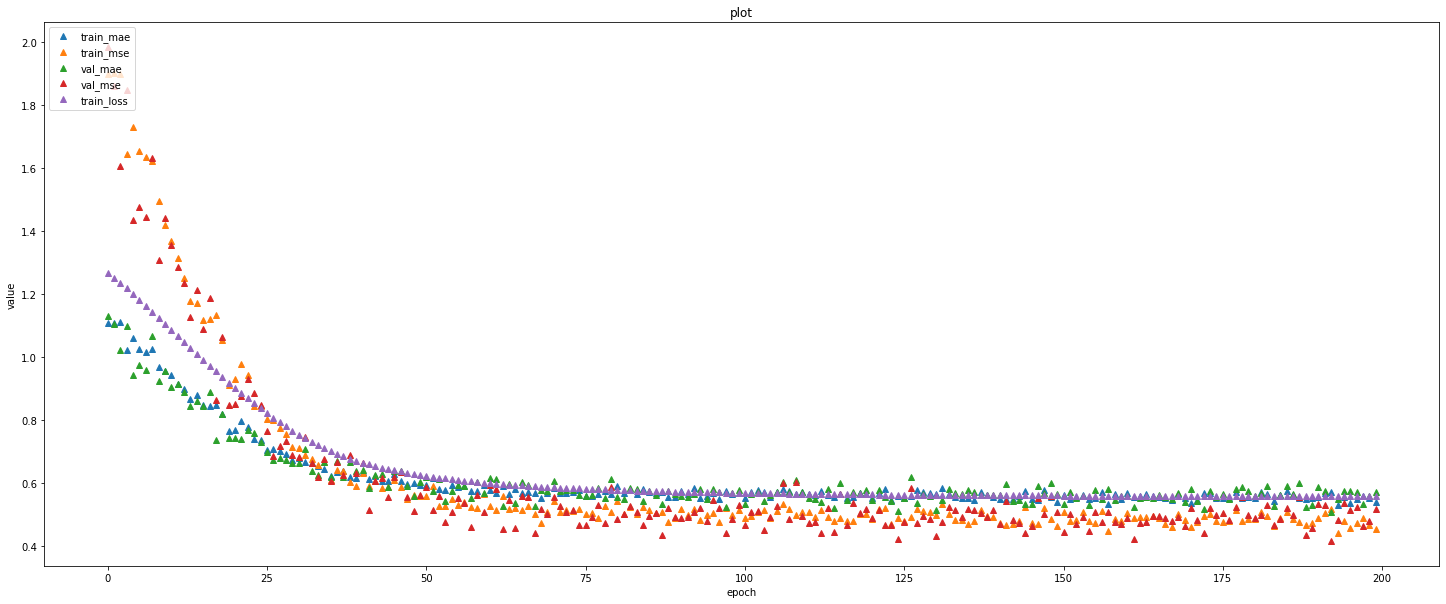

In [15]:
split1 = 'train'
split2 = 'val'
plot_df(raw_res[[f'{split1}_mae', f'{split1}_mse',
                 f'{split2}_mae', f'{split2}_mse',
                 f'{split1}_loss']], xlabel='epoch', ylabel='value')

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

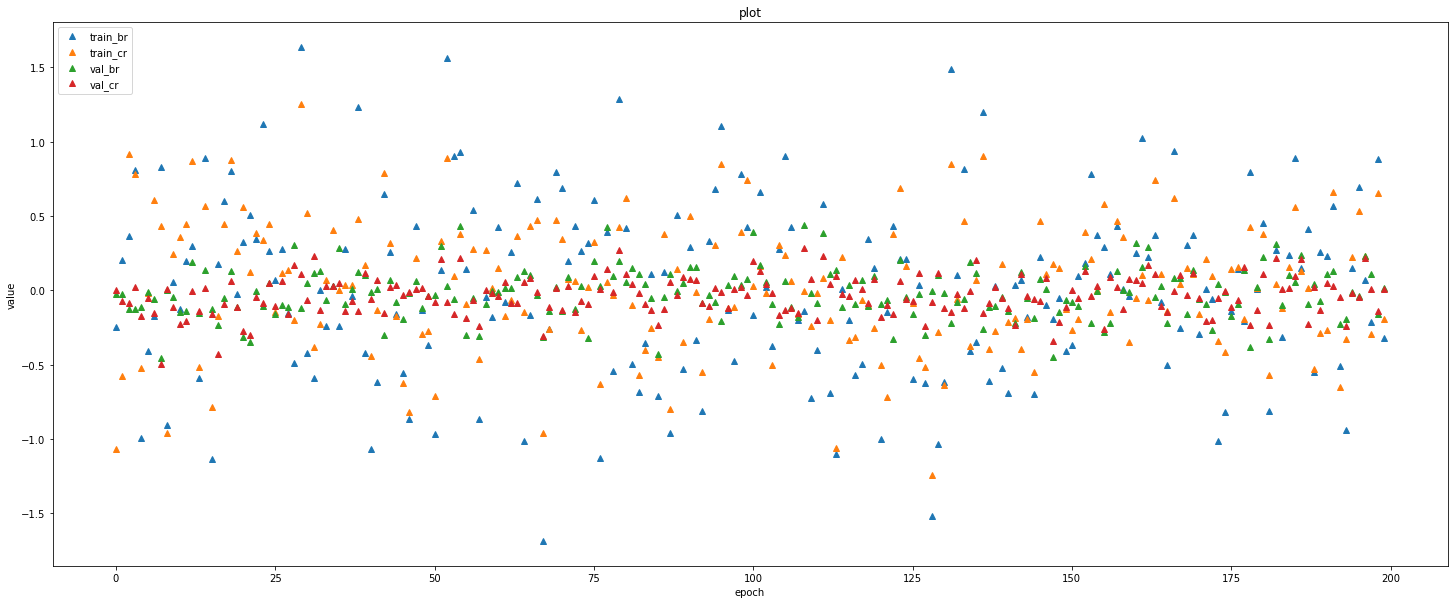

In [16]:
split1 = 'train'
split2 = 'val'
plot_df(raw_res[[f'{split1}_br', f'{split1}_cr',
                 f'{split2}_br', f'{split2}_cr']], xlabel='epoch', ylabel='value')

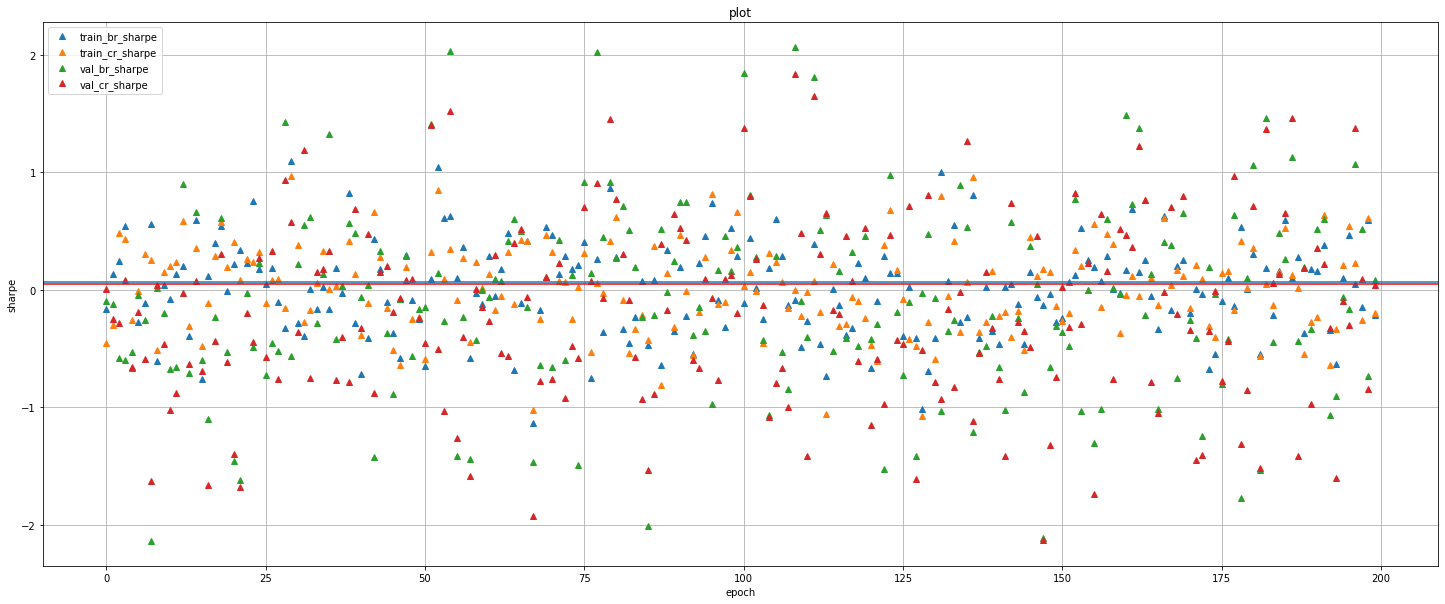

In [17]:
split1 = 'train'
split2 = 'val'
plot_df(raw_res[[f'{split1}_br_sharpe', f'{split1}_cr_sharpe',
                 f'{split2}_br_sharpe', f'{split2}_cr_sharpe']], xlabel='epoch', ylabel='sharpe')
plt.axhline(y=bench_res[f'{split2}_bs'])
plt.axhline(y=bench_res[f'{split2}_bsc'], color='r')
plt.grid()
plt.show()